In [1]:
from collections import defaultdict
import logging
from typing import cast, Dict, List, Tuple, Union, Callable
from typing_extensions import get_args, Literal
import sys
import os
import numpy as np
import random 
import seaborn as sns
from PIL import Image
import re

import torch
import torch.nn as nn
import torch.nn.functional as F

import yaml
import argparse
import pandas as pd
from tqdm.notebook import tqdm
from functools import partial

from torch.utils.data import DataLoader, TensorDataset

sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments/utils')
sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments')

from aheads import create_repeats_dataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
from transformers import BertConfig, BertForMaskedLM, AdamW

import matplotlib.style as style
style.use('ggplot')

/users/sanand14/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /oscar/home/sanand14/.local/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")


[2024-04-22 11:15:09,291] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
from utils.toy_utils import bin_train_loop, create_dataloaders_bin, Probe, POSVocabGenerator
from dataclasses import dataclass, field

In [3]:
from toy_model import TrainingPipeline

vocab size 10,000, amb 0.10, unif, stop forgetting after 20000

In [4]:
vocab_size = 10000
epochs=1
batch_size = 128
dataset_size = 71680 ## so that hits 560 steps
weight_decay=0.00
a = 1.5
prop_amb=0.50
bins=10

## SETTING UP PARAMETERS
num_random = vocab_size // 10
device = "cuda:0" if torch.cuda.is_available() else "cpu"

## SETTING UP TASK
sample_func = "zipfian"
if a == 0: ## just easier for me to write for loop
    sample_func = 'uniform'
dset_gen = POSVocabGenerator()
dset_gen.parameterize_pos_vocab(vocab_size, num_random, prop_amb=prop_amb, bins=bins, tail_only=False, a=a, sample_func=sample_func)

## SETTING UP MODEL
config = BertConfig(
    vocab_size=dset_gen.get_vocab_tokens(), ## args.vocab_size+3 if have null token
    hidden_size=64, # 128  
    num_hidden_layers=6, # 8
    num_attention_heads=1, # 8
    intermediate_size=8, # 512
)
toy_bert_model = BertForMaskedLM(config).to(device)
optimizer = torch.optim.AdamW(toy_bert_model.parameters(), lr=5e-5, weight_decay=weight_decay) 
print(optimizer.state_dict()['param_groups'][0]['weight_decay'], flush=True)
step_eval = list(range(0, 1000, 20)) + list(range(1000, 30000, 100))
max_num_steps = dataset_size *  epochs/batch_size
print('Max number of steps is ', max_num_steps, flush=True)

pipeline = TrainingPipeline(
    model=toy_bert_model,
    vocab_gen=dset_gen,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    train_dataloader=None, ## set to none so will automatically set up
    test_dataloader=None, ## set to none so will automatically set up
    device=device,
    batch_size=batch_size,
    epochs=epochs,
    num_train=dataset_size,
    num_val=10_000,
    step_eval=100,
    name=None, ## does not save model during training
    pca=['val', 'tail'],#['val', 'tail', 'random'],
    hist={},
    probe_results={},
    a=a,
    prop_amb=prop_amb,
    bins=bins,
    sample_func=sample_func
    )
    
# hist, probing_results = pipeline.train_loop()

0.0
Max number of steps is  560.0


In [5]:
pipeline.train_dataloader, pipeline.test_dataloader = pipeline._prepare_dataloaders()

DS [[10352, 10000, 10931, 10931, 10001, 10001, 10001], [10352, 10000, 10931, 10352, 10001, 10001, 10001]]
LS [[-100, -100, -100, -100, 10931, 10931, 10931], [-100, -100, -100, -100, 10931, 10352, 10352]]
bin maht 5000 10 500 0
bin maht 5000 10 500 1
bin maht 5000 10 500 2
bin maht 5000 10 500 3
bin maht 5000 10 500 4
bin maht 5000 10 500 5
bin maht 5000 10 500 6
bin maht 5000 10 500 7
bin maht 5000 10 500 8
bin maht 5000 10 500 9


In [31]:
not_same = pipeline.train_dataloader.dataset.tensors[0][((pipeline.train_dataloader.dataset.tensors[0][:, -4] < pipeline.adj_min).float() != (pipeline.train_dataloader.dataset.tensors[0][:, -4] != pipeline.train_dataloader.dataset.tensors[1][:, -3]).float())]
not_same_labels = pipeline.train_dataloader.dataset.tensors[1][((pipeline.train_dataloader.dataset.tensors[0][:, -4] < pipeline.adj_min).float() != (pipeline.train_dataloader.dataset.tensors[0][:, -4] != pipeline.train_dataloader.dataset.tensors[1][:, -3]).float())]

In [33]:
idx=0
not_same[idx], not_same_labels[idx]

(tensor([10000,    25,     1,    25, 10001, 10001, 10001], device='cuda:0'),
 tensor([-100, -100, -100, -100,   25,   25,   25], device='cuda:0'))

In [ ]:
assert ((examples[:, -4] < self.adj_min).float() == (examples[:, -4] != blabels[:, -3]).float()).all(), "Noun/Adj labels are not consistent"

In [6]:
hist, probing_results = pipeline.train_loop()

  0%|          | 0/1 [00:00<?, ?it/s]

Training step 0
Training step 1
Training step 2
Training step 3
Training step 4
Training step 5
Training step 6
Training step 7
Training step 8
Training step 9
Training step 10
Training step 11
Training step 12
Training step 13
Training step 14
Training step 15
Training step 16
Training step 17
Training step 18
Training step 19
Training step 20
Training step 21
Training step 22
Training step 23
Training step 24
Training step 25
Training step 26
Training step 27
Training step 28
Training step 29
Training step 30
Training step 31
Training step 32
Training step 33
Training step 34
Training step 35
Training step 36
Training step 37
Training step 38
Training step 39
Training step 40
Training step 41
Training step 42
Training step 43
Training step 44
Training step 45
Training step 46
Training step 47
Training step 48
Training step 49
Training step 50
Training step 51
Training step 52
Training step 53
Training step 54
Training step 55
Training step 56
Training step 57
Training step 58
Trainin

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Running validation for switch at step 100


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for holdout at step 100
Running validation for holdout_switch at step 100
Running validation for tail at step 100


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Running validation for tail_switch at step 100


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for unif_nonamb at step 100


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for unif_amb at step 100


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for bin_0_amb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Running validation for bin_0_nonamb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_0_nonamb_switch at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_1_amb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_1_nonamb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_1_nonamb_switch at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_2_amb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_2_nonamb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_2_nonamb_switch at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_3_amb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_3_nonamb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_3_nonamb_switch at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_4_amb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_4_nonamb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_4_nonamb_switch at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_5_amb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_5_nonamb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_5_nonamb_switch at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_6_amb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_6_nonamb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_6_nonamb_switch at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_7_amb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_7_nonamb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_7_nonamb_switch at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_8_amb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_8_nonamb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_8_nonamb_switch at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_9_amb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_9_nonamb at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_9_nonamb_switch at step 100


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training step 100
Training step 101
Training step 102
Training step 103
Training step 104
Training step 105
Training step 106
Training step 107
Training step 108
Training step 109
Training step 110
Training step 111
Training step 112
Training step 113
Training step 114
Training step 115
Training step 116
Training step 117
Training step 118
Training step 119
Training step 120
Training step 121
Training step 122
Training step 123
Training step 124
Training step 125
Training step 126
Training step 127
Training step 128
Training step 129
Training step 130
Training step 131
Training step 132
Training step 133
Training step 134
Training step 135
Training step 136
Training step 137
Training step 138
Training step 139
Training step 140
Training step 141
Training step 142
Training step 143
Training step 144
Training step 145
Training step 146
Training step 147
Training step 148
Training step 149
Training step 150
Training step 151
Training step 152
Training step 153
Training step 154
Training s

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Running validation for switch at step 200


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for holdout at step 200
Running validation for holdout_switch at step 200
Running validation for tail at step 200


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Running validation for tail_switch at step 200


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for unif_nonamb at step 200


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for unif_amb at step 200


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for bin_0_amb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_0_nonamb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_0_nonamb_switch at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_1_amb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_1_nonamb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_1_nonamb_switch at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_2_amb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_2_nonamb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_2_nonamb_switch at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_3_amb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_3_nonamb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_3_nonamb_switch at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_4_amb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_4_nonamb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_4_nonamb_switch at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_5_amb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_5_nonamb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_5_nonamb_switch at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_6_amb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_6_nonamb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_6_nonamb_switch at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_7_amb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_7_nonamb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_7_nonamb_switch at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_8_amb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_8_nonamb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_8_nonamb_switch at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_9_amb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_9_nonamb at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_9_nonamb_switch at step 200


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training step 200
Training step 201
Training step 202
Training step 203
Training step 204
Training step 205
Training step 206
Training step 207
Training step 208
Training step 209
Training step 210
Training step 211
Training step 212
Training step 213
Training step 214
Training step 215
Training step 216
Training step 217
Training step 218
Training step 219
Training step 220
Training step 221
Training step 222
Training step 223
Training step 224
Training step 225
Training step 226
Training step 227
Training step 228
Training step 229
Training step 230
Training step 231
Training step 232
Training step 233
Training step 234
Training step 235
Training step 236
Training step 237
Training step 238
Training step 239
Training step 240
Training step 241
Training step 242
Training step 243
Training step 244
Training step 245
Training step 246
Training step 247
Training step 248
Training step 249
Training step 250
Training step 251
Training step 252
Training step 253
Training step 254
Training s

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Running validation for switch at step 300


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for holdout at step 300
Running validation for holdout_switch at step 300
Running validation for tail at step 300


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Running validation for tail_switch at step 300


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for unif_nonamb at step 300


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for unif_amb at step 300


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for bin_0_amb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_0_nonamb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_0_nonamb_switch at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_1_amb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_1_nonamb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_1_nonamb_switch at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_2_amb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_2_nonamb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_2_nonamb_switch at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_3_amb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_3_nonamb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_3_nonamb_switch at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_4_amb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_4_nonamb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_4_nonamb_switch at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_5_amb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_5_nonamb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_5_nonamb_switch at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_6_amb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_6_nonamb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_6_nonamb_switch at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_7_amb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_7_nonamb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_7_nonamb_switch at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_8_amb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_8_nonamb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_8_nonamb_switch at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_9_amb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_9_nonamb at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_9_nonamb_switch at step 300


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training step 300
Training step 301
Training step 302
Training step 303
Training step 304
Training step 305
Training step 306
Training step 307
Training step 308
Training step 309
Training step 310
Training step 311
Training step 312
Training step 313
Training step 314
Training step 315
Training step 316
Training step 317
Training step 318
Training step 319
Training step 320
Training step 321
Training step 322
Training step 323
Training step 324
Training step 325
Training step 326
Training step 327
Training step 328
Training step 329
Training step 330
Training step 331
Training step 332
Training step 333
Training step 334
Training step 335
Training step 336
Training step 337
Training step 338
Training step 339
Training step 340
Training step 341
Training step 342
Training step 343
Training step 344
Training step 345
Training step 346
Training step 347
Training step 348
Training step 349
Training step 350
Training step 351
Training step 352
Training step 353
Training step 354
Training s

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Running validation for switch at step 400


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for holdout at step 400
Running validation for holdout_switch at step 400
Running validation for tail at step 400


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Running validation for tail_switch at step 400


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for unif_nonamb at step 400


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for unif_amb at step 400


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for bin_0_amb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_0_nonamb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_0_nonamb_switch at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_1_amb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_1_nonamb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_1_nonamb_switch at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_2_amb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_2_nonamb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_2_nonamb_switch at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_3_amb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_3_nonamb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_3_nonamb_switch at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_4_amb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_4_nonamb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_4_nonamb_switch at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_5_amb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_5_nonamb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_5_nonamb_switch at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_6_amb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_6_nonamb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_6_nonamb_switch at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_7_amb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_7_nonamb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_7_nonamb_switch at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_8_amb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_8_nonamb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_8_nonamb_switch at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_9_amb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_9_nonamb at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_9_nonamb_switch at step 400


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training step 400
Training step 401
Training step 402
Training step 403
Training step 404
Training step 405
Training step 406
Training step 407
Training step 408
Training step 409
Training step 410
Training step 411
Training step 412
Training step 413
Training step 414
Training step 415
Training step 416
Training step 417
Training step 418
Training step 419
Training step 420
Training step 421
Training step 422
Training step 423
Training step 424
Training step 425
Training step 426
Training step 427
Training step 428
Training step 429
Training step 430
Training step 431
Training step 432
Training step 433
Training step 434
Training step 435
Training step 436
Training step 437
Training step 438
Training step 439
Training step 440
Training step 441
Training step 442
Training step 443
Training step 444
Training step 445
Training step 446
Training step 447
Training step 448
Training step 449
Training step 450
Training step 451
Training step 452
Training step 453
Training step 454
Training s

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Running validation for switch at step 500


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for holdout at step 500
Running validation for holdout_switch at step 500
Running validation for tail at step 500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Running validation for tail_switch at step 500


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for unif_nonamb at step 500


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for unif_amb at step 500


  0%|          | 0/79 [00:00<?, ?it/s]

Running validation for bin_0_amb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_0_nonamb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_0_nonamb_switch at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_1_amb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_1_nonamb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_1_nonamb_switch at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_2_amb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_2_nonamb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_2_nonamb_switch at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_3_amb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_3_nonamb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_3_nonamb_switch at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_4_amb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_4_nonamb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_4_nonamb_switch at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_5_amb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_5_nonamb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_5_nonamb_switch at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_6_amb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_6_nonamb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_6_nonamb_switch at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_7_amb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_7_nonamb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_7_nonamb_switch at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_8_amb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_8_nonamb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_8_nonamb_switch at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_9_amb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_9_nonamb at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

Running validation for bin_9_nonamb_switch at step 500


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training step 500
Training step 501
Training step 502
Training step 503
Training step 504
Training step 505
Training step 506
Training step 507
Training step 508
Training step 509
Training step 510
Training step 511
Training step 512
Training step 513
Training step 514
Training step 515
Training step 516
Training step 517
Training step 518
Training step 519
Training step 520
Training step 521
Training step 522
Training step 523
Training step 524
Training step 525
Training step 526
Training step 527
Training step 528
Training step 529
Training step 530
Training step 531
Training step 532
Training step 533
Training step 534
Training step 535
Training step 536
Training step 537
Training step 538
Training step 539
Training step 540
Training step 541
Training step 542
Training step 543
Training step 544
Training step 545
Training step 546
Training step 547
Training step 548
Training step 549
Training step 550
Training step 551
Training step 552
Training step 553
Training step 554
Training s

In [10]:
from collections import defaultdict, Counter

pipeline.model.eval()
train_query_counts = Counter(pipeline.train_dataloader.dataset.tensors[0][:, -4].tolist())
new_test_dataloader = DataLoader(pipeline.test_dataloader['val'].dataset, batch_size=1, shuffle=False)

In [30]:
# -4 is the position of the query token
rank_freq_acc_entries= {}
with torch.no_grad():
    pbar = tqdm(new_test_dataloader)
    for val_batch in pbar:
        _, stats = pipeline.step(val_batch, hard_acc=True)
        curr_x, _ = val_batch
        query = curr_x.squeeze()[-4].item()
        # print(train_query_counts[query])
        if train_query_counts[query] not in rank_freq_acc_entries:
            rank_freq_acc_entries[train_query_counts[query]] = []
        rank_freq_acc_entries[train_query_counts[query]].append(stats["acc"]) 

  0%|          | 0/10000 [00:00<?, ?it/s]

In [26]:
rank_freq_mean = {key: np.mean(rank_freq_acc_entries[key]) for key in rank_freq_acc_entries}

In [29]:
import json
json.dump(rank_freq_acc_entries, open('rank_freq_acc.json', 'w'))

In [27]:
step_eval = 100

In [30]:
output_dir='.'
for key, probe_val in probing_results.items():
    df = pd.DataFrame(probe_val)
    df = df.transpose()
    if isinstance(step_eval, int):
        df.columns = [i*step_eval for i in range(len(df.columns))]
    else:
        df.columns = step_eval[:len(df.columns)]
    df = df[::-1]
    df.to_csv(os.path.join(output_dir, f'pos_probing_results_{key}.csv'))
    
    ax = sns.heatmap(df, annot=False)
    ax.set_xlabel("Step")
    ax.set_ylabel("Layer")
    ax.set_title(f"POS Probing {key}")
    plt.savefig(os.path.join(output_dir, f'pos_probing_steps_{key}.png'))
    plt.close()

<Axes: >

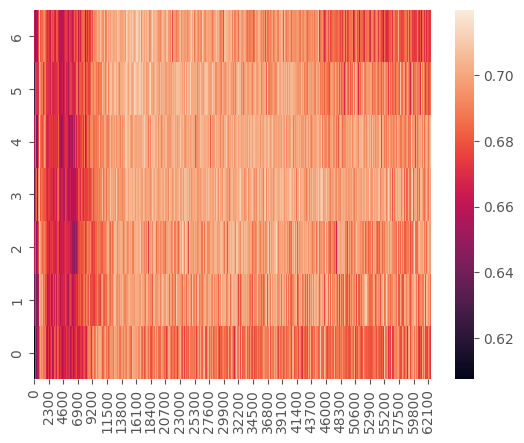

In [35]:
probing_zipf_forg = {'val': {0: [0.6775793650793651, 0.6076388888888888, 0.6696428571428571, 0.6825396825396826, 0.6468253968253969, 0.6577380952380952, 0.6403769841269841, 0.6626984126984127, 0.6502976190476191, 0.6850198412698413, 0.6974206349206349, 0.6760912698412699, 0.6924603174603174, 0.6944444444444444, 0.6770833333333334, 0.6865079365079365, 0.6870039682539683, 0.6850198412698413, 0.6884920634920635, 0.6879960317460317, 0.6651785714285714, 0.6567460317460317, 0.6641865079365079, 0.6726190476190477, 0.6577380952380952, 0.6671626984126984, 0.6701388888888888, 0.6671626984126984, 0.6780753968253969, 0.6597222222222222, 0.6870039682539683, 0.6631944444444444, 0.6820436507936508, 0.6577380952380952, 0.6785714285714286, 0.6671626984126984, 0.683531746031746, 0.6820436507936508, 0.6750992063492064, 0.6805555555555556, 0.6651785714285714, 0.6681547619047619, 0.6716269841269841, 0.6656746031746031, 0.6671626984126984, 0.6587301587301587, 0.6617063492063492, 0.6622023809523809, 0.6671626984126984, 0.6736111111111112, 0.6661706349206349, 0.6726190476190477, 0.6641865079365079, 0.6676587301587301, 0.6681547619047619, 0.658234126984127, 0.6726190476190477, 0.6552579365079365, 0.6666666666666666, 0.6661706349206349, 0.6641865079365079, 0.6716269841269841, 0.6527777777777778, 0.6651785714285714, 0.6676587301587301, 0.6701388888888888, 0.6780753968253969, 0.6765873015873016, 0.6636904761904762, 0.6661706349206349, 0.6656746031746031, 0.6750992063492064, 0.6646825396825397, 0.6721230158730159, 0.6696428571428571, 0.6726190476190477, 0.6671626984126984, 0.6810515873015873, 0.6760912698412699, 0.6795634920634921, 0.6845238095238095, 0.6716269841269841, 0.6755952380952381, 0.6656746031746031, 0.6840277777777778, 0.6701388888888888, 0.691468253968254, 0.6909722222222222, 0.6820436507936508, 0.6870039682539683, 0.6999007936507936, 0.6736111111111112, 0.691468253968254, 0.6795634920634921, 0.6994047619047619, 0.6845238095238095, 0.6984126984126984, 0.689484126984127, 0.7033730158730159, 0.6979166666666666, 0.691468253968254, 0.7033730158730159, 0.6984126984126984, 0.7013888888888888, 0.6964285714285714, 0.7013888888888888, 0.6964285714285714, 0.7008928571428571, 0.6815476190476191, 0.6840277777777778, 0.6964285714285714, 0.6949404761904762, 0.6870039682539683, 0.7013888888888888, 0.6875, 0.6884920634920635, 0.6934523809523809, 0.6800595238095238, 0.6964285714285714, 0.689484126984127, 0.6964285714285714, 0.6954365079365079, 0.6954365079365079, 0.6820436507936508, 0.6949404761904762, 0.6875, 0.685515873015873, 0.7018849206349206, 0.6984126984126984, 0.6999007936507936, 0.6984126984126984, 0.6909722222222222, 0.7018849206349206, 0.6989087301587301, 0.683531746031746, 0.6870039682539683, 0.6865079365079365, 0.6785714285714286, 0.6964285714285714, 0.6974206349206349, 0.685515873015873, 0.689484126984127, 0.6974206349206349, 0.6939484126984127, 0.6934523809523809, 0.6934523809523809, 0.6884920634920635, 0.7023809523809523, 0.6765873015873016, 0.6989087301587301, 0.6934523809523809, 0.6785714285714286, 0.6865079365079365, 0.6795634920634921, 0.6815476190476191, 0.7048611111111112, 0.6750992063492064, 0.6999007936507936, 0.7008928571428571, 0.6974206349206349, 0.6979166666666666, 0.6969246031746031, 0.6909722222222222, 0.7008928571428571, 0.6954365079365079, 0.691468253968254, 0.6924603174603174, 0.6830357142857143, 0.7033730158730159, 0.6865079365079365, 0.6850198412698413, 0.683531746031746, 0.6944444444444444, 0.6984126984126984, 0.6790674603174603, 0.689484126984127, 0.685515873015873, 0.6994047619047619, 0.6845238095238095, 0.6954365079365079, 0.6860119047619048, 0.6795634920634921, 0.6969246031746031, 0.6805555555555556, 0.6999007936507936, 0.6780753968253969, 0.6820436507936508, 0.6860119047619048, 0.6929563492063492, 0.6870039682539683, 0.6860119047619048, 0.7033730158730159, 0.6989087301587301, 0.6884920634920635, 0.7008928571428571, 0.689484126984127, 0.6850198412698413, 0.6870039682539683, 0.6830357142857143, 0.6845238095238095, 0.6865079365079365, 0.7003968253968254, 0.6939484126984127, 0.6969246031746031, 0.6904761904761905, 0.6845238095238095, 0.6825396825396826, 0.6865079365079365, 0.6775793650793651, 0.6736111111111112, 0.6845238095238095, 0.6790674603174603, 0.7008928571428571, 0.7013888888888888, 0.6919642857142857, 0.689484126984127, 0.6820436507936508, 0.6815476190476191, 0.6875, 0.6785714285714286, 0.6875, 0.6790674603174603, 0.6964285714285714, 0.689484126984127, 0.6870039682539683, 0.691468253968254, 0.6741071428571429, 0.6964285714285714, 0.6899801587301587, 0.6964285714285714, 0.6875, 0.7018849206349206, 0.6845238095238095, 0.6999007936507936, 0.6785714285714286, 0.6954365079365079, 0.6889880952380952, 0.6755952380952381, 0.6994047619047619, 0.6924603174603174, 0.6810515873015873, 0.6850198412698413, 0.6865079365079365, 0.6815476190476191, 0.6830357142857143, 0.6989087301587301, 0.6879960317460317, 0.6879960317460317, 0.6870039682539683, 0.683531746031746, 0.6870039682539683, 0.6899801587301587, 0.6810515873015873, 0.6845238095238095, 0.6934523809523809, 0.6805555555555556, 0.6746031746031746, 0.6909722222222222, 0.6825396825396826, 0.6969246031746031, 0.6939484126984127, 0.685515873015873, 0.6994047619047619, 0.6939484126984127, 0.6865079365079365, 0.6815476190476191, 0.6909722222222222, 0.7023809523809523, 0.7048611111111112, 0.6785714285714286, 0.6800595238095238, 0.6800595238095238, 0.6765873015873016, 0.6939484126984127, 0.6870039682539683, 0.7028769841269841, 0.6825396825396826, 0.6790674603174603, 0.6949404761904762, 0.6954365079365079, 0.685515873015873, 0.6959325396825397, 0.6875, 0.6820436507936508, 0.6865079365079365, 0.7033730158730159, 0.6889880952380952, 0.6865079365079365, 0.6909722222222222, 0.6994047619047619, 0.6785714285714286, 0.6815476190476191, 0.6726190476190477, 0.6795634920634921, 0.6830357142857143, 0.6805555555555556, 0.6825396825396826, 0.6865079365079365, 0.6929563492063492, 0.7013888888888888, 0.6840277777777778, 0.6969246031746031, 0.6865079365079365, 0.6820436507936508, 0.6741071428571429, 0.6800595238095238, 0.6989087301587301, 0.7018849206349206, 0.6795634920634921, 0.6845238095238095, 0.7008928571428571, 0.7033730158730159, 0.7063492063492064, 0.6909722222222222, 0.6800595238095238, 0.7058531746031746, 0.6691468253968254, 0.6875, 0.6805555555555556, 0.7058531746031746, 0.6884920634920635, 0.6711309523809523, 0.6865079365079365, 0.6830357142857143, 0.7033730158730159, 0.6785714285714286, 0.6820436507936508, 0.7058531746031746, 0.6800595238095238, 0.6785714285714286, 0.6840277777777778, 0.6830357142857143, 0.6865079365079365, 0.6904761904761905, 0.6875, 0.7028769841269841, 0.6815476190476191, 0.6929563492063492, 0.6899801587301587, 0.6775793650793651, 0.7003968253968254, 0.6944444444444444, 0.6989087301587301, 0.6820436507936508, 0.6780753968253969, 0.6860119047619048, 0.6909722222222222, 0.6780753968253969, 0.689484126984127, 0.6820436507936508, 0.6820436507936508, 0.689484126984127, 0.6909722222222222, 0.6879960317460317, 0.6820436507936508, 0.6884920634920635, 0.6879960317460317, 0.6810515873015873, 0.6820436507936508, 0.6815476190476191, 0.6865079365079365, 0.6984126984126984, 0.683531746031746, 0.6944444444444444, 0.6934523809523809, 0.6879960317460317, 0.6904761904761905, 0.6800595238095238, 0.6875, 0.6889880952380952, 0.6810515873015873, 0.7058531746031746, 0.6795634920634921, 0.6924603174603174, 0.6929563492063492, 0.6775793650793651, 0.6889880952380952, 0.6860119047619048, 0.6825396825396826, 0.7003968253968254, 0.6909722222222222, 0.691468253968254, 0.6979166666666666, 0.685515873015873, 0.6909722222222222, 0.6746031746031746, 0.6879960317460317, 0.6959325396825397, 0.683531746031746, 0.6870039682539683, 0.685515873015873, 0.6919642857142857, 0.6870039682539683, 0.6790674603174603, 0.6934523809523809, 0.685515873015873, 0.6944444444444444, 0.6810515873015873, 0.6815476190476191, 0.6879960317460317, 0.6845238095238095, 0.6879960317460317, 0.6919642857142857, 0.6865079365079365, 0.691468253968254, 0.6954365079365079, 0.6755952380952381, 0.7003968253968254, 0.6939484126984127, 0.7033730158730159, 0.6790674603174603, 0.6954365079365079, 0.6845238095238095, 0.6860119047619048, 0.6810515873015873, 0.6899801587301587, 0.685515873015873, 0.6770833333333334, 0.6954365079365079, 0.6860119047619048, 0.689484126984127, 0.6770833333333334, 0.6716269841269841, 0.6711309523809523, 0.6934523809523809, 0.6736111111111112, 0.6830357142857143, 0.6805555555555556, 0.6785714285714286, 0.6845238095238095, 0.6884920634920635, 0.6770833333333334, 0.6979166666666666, 0.6815476190476191, 0.6840277777777778, 0.7018849206349206, 0.6800595238095238, 0.6805555555555556, 0.6870039682539683, 0.6810515873015873, 0.6889880952380952, 0.7088293650793651, 0.6850198412698413, 0.6989087301587301, 0.6800595238095238, 0.6909722222222222, 0.691468253968254, 0.685515873015873, 0.6820436507936508, 0.7038690476190477, 0.6850198412698413, 0.7098214285714286, 0.683531746031746, 0.6850198412698413, 0.685515873015873, 0.6979166666666666, 0.6805555555555556, 0.6810515873015873, 0.7053571428571429, 0.6959325396825397, 0.6775793650793651, 0.6820436507936508, 0.6765873015873016, 0.6924603174603174, 0.6840277777777778, 0.6845238095238095, 0.6840277777777778, 0.6810515873015873, 0.6830357142857143, 0.6899801587301587, 0.683531746031746, 0.6830357142857143, 0.6815476190476191, 0.7023809523809523, 0.6934523809523809, 0.6805555555555556, 0.6865079365079365, 0.6795634920634921, 0.6865079365079365, 0.689484126984127, 0.6884920634920635, 0.6800595238095238, 0.7013888888888888, 0.6889880952380952, 0.6860119047619048, 0.6860119047619048, 0.6934523809523809, 0.6850198412698413, 0.689484126984127, 0.6860119047619048, 0.6889880952380952, 0.6820436507936508, 0.6795634920634921, 0.6795634920634921, 0.685515873015873, 0.6790674603174603, 0.6830357142857143, 0.6780753968253969, 0.6810515873015873, 0.6875, 0.6934523809523809, 0.7008928571428571, 0.6884920634920635, 0.6810515873015873, 0.7013888888888888, 0.7018849206349206, 0.6721230158730159, 0.6934523809523809, 0.6830357142857143, 0.6800595238095238, 0.6805555555555556, 0.6919642857142857, 0.6726190476190477, 0.6889880952380952, 0.6820436507936508, 0.6865079365079365, 0.6750992063492064, 0.6810515873015873, 0.6746031746031746, 0.6999007936507936, 0.6815476190476191, 0.685515873015873, 0.6840277777777778, 0.6815476190476191, 0.6800595238095238, 0.6825396825396826, 0.6795634920634921, 0.6800595238095238, 0.6795634920634921, 0.6790674603174603, 0.6785714285714286, 0.6904761904761905, 0.6790674603174603, 0.6810515873015873, 0.6760912698412699, 0.6875, 0.6879960317460317, 0.6934523809523809, 0.6865079365079365, 0.6785714285714286, 0.6865079365079365, 0.6924603174603174, 0.6840277777777778, 0.683531746031746, 0.6790674603174603, 0.6840277777777778, 0.6825396825396826, 0.6746031746031746, 0.6830357142857143, 0.683531746031746, 0.6736111111111112, 0.6820436507936508, 0.7088293650793651, 0.6879960317460317, 0.685515873015873, 0.6884920634920635, 0.6815476190476191, 0.6964285714285714, 0.6706349206349206, 0.6870039682539683, 0.6800595238095238, 0.6746031746031746, 0.6815476190476191, 0.7078373015873016, 0.6815476190476191, 0.6741071428571429, 0.6750992063492064, 0.7008928571428571, 0.6924603174603174, 0.6904761904761905, 0.6765873015873016, 0.6899801587301587, 0.6954365079365079, 0.6795634920634921, 0.6964285714285714, 0.6870039682539683, 0.6830357142857143, 0.6780753968253969, 0.6959325396825397, 0.6780753968253969, 0.6974206349206349, 0.6850198412698413, 0.6865079365079365, 0.6795634920634921, 0.6780753968253969, 0.6884920634920635, 0.6845238095238095, 0.689484126984127, 0.6696428571428571, 0.6800595238095238, 0.6994047619047619, 0.7073412698412699, 0.6879960317460317, 0.6785714285714286, 0.6746031746031746, 0.6919642857142857, 0.6954365079365079, 0.6825396825396826, 0.7018849206349206, 0.6870039682539683, 0.6929563492063492, 0.7023809523809523, 0.6889880952380952, 0.6850198412698413, 0.6939484126984127, 0.6949404761904762, 0.6746031746031746, 0.6711309523809523, 0.6889880952380952, 0.6805555555555556, 0.6716269841269841, 0.7018849206349206, 0.7003968253968254, 0.6845238095238095, 0.6825396825396826, 0.6984126984126984, 0.691468253968254, 0.6750992063492064, 0.6775793650793651, 0.6800595238095238, 0.6765873015873016, 0.691468253968254, 0.6989087301587301, 0.6820436507936508, 0.6716269841269841], 1: [0.6711309523809523, 0.6369047619047619, 0.6731150793650794, 0.6795634920634921, 0.6448412698412699, 0.6468253968253969, 0.6641865079365079, 0.6577380952380952, 0.7088293650793651, 0.7083333333333334, 0.7003968253968254, 0.6934523809523809, 0.6954365079365079, 0.7028769841269841, 0.6860119047619048, 0.6845238095238095, 0.6904761904761905, 0.6904761904761905, 0.6780753968253969, 0.689484126984127, 0.6775793650793651, 0.6597222222222222, 0.6661706349206349, 0.6636904761904762, 0.6646825396825397, 0.6646825396825397, 0.6736111111111112, 0.6671626984126984, 0.6577380952380952, 0.6641865079365079, 0.6795634920634921, 0.6765873015873016, 0.6646825396825397, 0.6701388888888888, 0.6790674603174603, 0.6626984126984127, 0.6765873015873016, 0.6795634920634921, 0.6691468253968254, 0.6731150793650794, 0.6691468253968254, 0.660218253968254, 0.6567460317460317, 0.6651785714285714, 0.6691468253968254, 0.6666666666666666, 0.6676587301587301, 0.6631944444444444, 0.6666666666666666, 0.6572420634920635, 0.6765873015873016, 0.6686507936507936, 0.6661706349206349, 0.6636904761904762, 0.6552579365079365, 0.6666666666666666, 0.6726190476190477, 0.6760912698412699, 0.6746031746031746, 0.6701388888888888, 0.6731150793650794, 0.6597222222222222, 0.660218253968254, 0.652281746031746, 0.6676587301587301, 0.6671626984126984, 0.6646825396825397, 0.6731150793650794, 0.6676587301587301, 0.6622023809523809, 0.6810515873015873, 0.6840277777777778, 0.6760912698412699, 0.6830357142857143, 0.6721230158730159, 0.6736111111111112, 0.6750992063492064, 0.6775793650793651, 0.6840277777777778, 0.6884920634920635, 0.6845238095238095, 0.6765873015873016, 0.6800595238095238, 0.6904761904761905, 0.6860119047619048, 0.6899801587301587, 0.6795634920634921, 0.6979166666666666, 0.6810515873015873, 0.6765873015873016, 0.6795634920634921, 0.6785714285714286, 0.6775793650793651, 0.6785714285714286, 0.6755952380952381, 0.6731150793650794, 0.6731150793650794, 0.6805555555555556, 0.6825396825396826, 0.6860119047619048, 0.691468253968254, 0.6840277777777778, 0.6815476190476191, 0.6800595238095238, 0.6785714285714286, 0.6750992063492064, 0.6939484126984127, 0.6979166666666666, 0.6999007936507936, 0.683531746031746, 0.6924603174603174, 0.6805555555555556, 0.7003968253968254, 0.6870039682539683, 0.6845238095238095, 0.6840277777777778, 0.6954365079365079, 0.7003968253968254, 0.7008928571428571, 0.689484126984127, 0.6850198412698413, 0.7073412698412699, 0.6934523809523809, 0.6994047619047619, 0.6884920634920635, 0.6984126984126984, 0.6989087301587301, 0.7073412698412699, 0.7058531746031746, 0.6954365079365079, 0.6959325396825397, 0.6909722222222222, 0.7013888888888888, 0.6979166666666666, 0.7003968253968254, 0.6919642857142857, 0.7013888888888888, 0.6999007936507936, 0.6979166666666666, 0.7048611111111112, 0.6934523809523809, 0.6964285714285714, 0.6924603174603174, 0.6989087301587301, 0.6899801587301587, 0.691468253968254, 0.6954365079365079, 0.6964285714285714, 0.6954365079365079, 0.7013888888888888, 0.7043650793650794, 0.7023809523809523, 0.6989087301587301, 0.7033730158730159, 0.6994047619047619, 0.6974206349206349, 0.7003968253968254, 0.6984126984126984, 0.6944444444444444, 0.7058531746031746, 0.7028769841269841, 0.7013888888888888, 0.7043650793650794, 0.7003968253968254, 0.689484126984127, 0.7018849206349206, 0.6964285714285714, 0.7058531746031746, 0.6964285714285714, 0.7063492063492064, 0.7018849206349206, 0.7008928571428571, 0.6994047619047619, 0.7023809523809523, 0.6939484126984127, 0.6954365079365079, 0.6870039682539683, 0.7033730158730159, 0.6979166666666666, 0.7028769841269841, 0.6934523809523809, 0.6775793650793651, 0.6959325396825397, 0.691468253968254, 0.7023809523809523, 0.6929563492063492, 0.7013888888888888, 0.6815476190476191, 0.7058531746031746, 0.7068452380952381, 0.7058531746031746, 0.6939484126984127, 0.7078373015873016, 0.6964285714285714, 0.6959325396825397, 0.6939484126984127, 0.6999007936507936, 0.7023809523809523, 0.7018849206349206, 0.6899801587301587, 0.7013888888888888, 0.6979166666666666, 0.7078373015873016, 0.6939484126984127, 0.7018849206349206, 0.6959325396825397, 0.7003968253968254, 0.6969246031746031, 0.6964285714285714, 0.7063492063492064, 0.7013888888888888, 0.6984126984126984, 0.7013888888888888, 0.683531746031746, 0.6860119047619048, 0.7013888888888888, 0.7028769841269841, 0.6969246031746031, 0.6860119047619048, 0.7028769841269841, 0.6959325396825397, 0.6934523809523809, 0.683531746031746, 0.683531746031746, 0.7093253968253969, 0.7063492063492064, 0.6994047619047619, 0.6999007936507936, 0.6974206349206349, 0.6974206349206349, 0.6929563492063492, 0.6959325396825397, 0.6929563492063492, 0.7028769841269841, 0.6840277777777778, 0.7028769841269841, 0.7023809523809523, 0.6939484126984127, 0.6934523809523809, 0.7008928571428571, 0.6840277777777778, 0.7028769841269841, 0.7013888888888888, 0.6969246031746031, 0.7018849206349206, 0.7038690476190477, 0.6969246031746031, 0.691468253968254, 0.6845238095238095, 0.7038690476190477, 0.7063492063492064, 0.691468253968254, 0.7058531746031746, 0.6904761904761905, 0.6979166666666666, 0.6989087301587301, 0.6860119047619048, 0.7028769841269841, 0.6845238095238095, 0.7063492063492064, 0.683531746031746, 0.6884920634920635, 0.6944444444444444, 0.7093253968253969, 0.6924603174603174, 0.6865079365079365, 0.7013888888888888, 0.6954365079365079, 0.7018849206349206, 0.6860119047619048, 0.7028769841269841, 0.7073412698412699, 0.6939484126984127, 0.6929563492063492, 0.6959325396825397, 0.7013888888888888, 0.6994047619047619, 0.6939484126984127, 0.7043650793650794, 0.6974206349206349, 0.6929563492063492, 0.6904761904761905, 0.6845238095238095, 0.7058531746031746, 0.6929563492063492, 0.691468253968254, 0.6979166666666666, 0.6954365079365079, 0.6815476190476191, 0.6969246031746031, 0.7058531746031746, 0.6825396825396826, 0.7023809523809523, 0.6974206349206349, 0.6924603174603174, 0.7113095238095238, 0.7043650793650794, 0.6994047619047619, 0.7018849206349206, 0.6979166666666666, 0.7033730158730159, 0.7038690476190477, 0.7018849206349206, 0.6899801587301587, 0.6999007936507936, 0.6949404761904762, 0.7013888888888888, 0.6810515873015873, 0.7068452380952381, 0.6860119047619048, 0.7113095238095238, 0.6999007936507936, 0.7043650793650794, 0.7068452380952381, 0.7013888888888888, 0.7108134920634921, 0.7013888888888888, 0.7043650793650794, 0.6780753968253969, 0.7023809523809523, 0.6969246031746031, 0.7003968253968254, 0.6765873015873016, 0.7033730158730159, 0.6994047619047619, 0.6805555555555556, 0.6845238095238095, 0.691468253968254, 0.7028769841269841, 0.6954365079365079, 0.6999007936507936, 0.7008928571428571, 0.6934523809523809, 0.6969246031746031, 0.7018849206349206, 0.7023809523809523, 0.6964285714285714, 0.6875, 0.6989087301587301, 0.6884920634920635, 0.6979166666666666, 0.6865079365079365, 0.6974206349206349, 0.6909722222222222, 0.6800595238095238, 0.6879960317460317, 0.7033730158730159, 0.6909722222222222, 0.6825396825396826, 0.6919642857142857, 0.6934523809523809, 0.6949404761904762, 0.7068452380952381, 0.6860119047619048, 0.6904761904761905, 0.691468253968254, 0.7028769841269841, 0.6944444444444444, 0.6820436507936508, 0.6944444444444444, 0.6934523809523809, 0.6820436507936508, 0.7028769841269841, 0.6879960317460317, 0.7023809523809523, 0.7028769841269841, 0.7073412698412699, 0.6994047619047619, 0.6790674603174603, 0.7038690476190477, 0.7023809523809523, 0.7003968253968254, 0.6889880952380952, 0.6909722222222222, 0.7098214285714286, 0.6889880952380952, 0.6959325396825397, 0.7023809523809523, 0.6795634920634921, 0.7003968253968254, 0.6999007936507936, 0.6889880952380952, 0.7058531746031746, 0.6924603174603174, 0.7043650793650794, 0.6929563492063492, 0.7048611111111112, 0.6954365079365079, 0.7033730158730159, 0.691468253968254, 0.6840277777777778, 0.7048611111111112, 0.691468253968254, 0.6999007936507936, 0.6939484126984127, 0.6959325396825397, 0.7058531746031746, 0.6984126984126984, 0.685515873015873, 0.7048611111111112, 0.685515873015873, 0.6860119047619048, 0.6999007936507936, 0.6850198412698413, 0.685515873015873, 0.6984126984126984, 0.6810515873015873, 0.6899801587301587, 0.6974206349206349, 0.6919642857142857, 0.6974206349206349, 0.7048611111111112, 0.7008928571428571, 0.7048611111111112, 0.6875, 0.6760912698412699, 0.6860119047619048, 0.6860119047619048, 0.7033730158730159, 0.6845238095238095, 0.6974206349206349, 0.7043650793650794, 0.6949404761904762, 0.6870039682539683, 0.6909722222222222, 0.7033730158730159, 0.6989087301587301, 0.6825396825396826, 0.6810515873015873, 0.6979166666666666, 0.7063492063492064, 0.6800595238095238, 0.7033730158730159, 0.7108134920634921, 0.685515873015873, 0.6999007936507936, 0.7058531746031746, 0.6934523809523809, 0.6964285714285714, 0.7048611111111112, 0.6909722222222222, 0.6929563492063492, 0.7058531746031746, 0.7013888888888888, 0.685515873015873, 0.6999007936507936, 0.7053571428571429, 0.6929563492063492, 0.6999007936507936, 0.6999007936507936, 0.6830357142857143, 0.6999007936507936, 0.6850198412698413, 0.7048611111111112, 0.6974206349206349, 0.6924603174603174, 0.7028769841269841, 0.6879960317460317, 0.6760912698412699, 0.6979166666666666, 0.6939484126984127, 0.7068452380952381, 0.7043650793650794, 0.689484126984127, 0.6845238095238095, 0.7073412698412699, 0.6924603174603174, 0.6825396825396826, 0.7093253968253969, 0.7093253968253969, 0.6884920634920635, 0.6934523809523809, 0.6964285714285714, 0.6909722222222222, 0.6840277777777778, 0.7018849206349206, 0.6934523809523809, 0.6944444444444444, 0.6810515873015873, 0.6879960317460317, 0.6984126984126984, 0.6741071428571429, 0.6765873015873016, 0.6994047619047619, 0.6830357142857143, 0.7028769841269841, 0.6899801587301587, 0.6810515873015873, 0.6845238095238095, 0.7048611111111112, 0.6959325396825397, 0.6875, 0.6800595238095238, 0.7013888888888888, 0.6785714285714286, 0.6939484126984127, 0.6845238095238095, 0.6780753968253969, 0.6964285714285714, 0.6999007936507936, 0.6875, 0.6924603174603174, 0.6989087301587301, 0.6934523809523809, 0.6865079365079365, 0.689484126984127, 0.7013888888888888, 0.6949404761904762, 0.6770833333333334, 0.7058531746031746, 0.6800595238095238, 0.6825396825396826, 0.6994047619047619, 0.6805555555555556, 0.6939484126984127, 0.6964285714285714, 0.6850198412698413, 0.6974206349206349, 0.6924603174603174, 0.6959325396825397, 0.6994047619047619, 0.7018849206349206, 0.7103174603174603, 0.7048611111111112, 0.7098214285714286, 0.6969246031746031, 0.6929563492063492, 0.691468253968254, 0.683531746031746, 0.6919642857142857, 0.6840277777777778, 0.6964285714285714, 0.6850198412698413, 0.6875, 0.7083333333333334, 0.7013888888888888, 0.6994047619047619, 0.6870039682539683, 0.6795634920634921, 0.689484126984127, 0.7028769841269841, 0.6994047619047619, 0.7028769841269841, 0.6919642857142857, 0.6959325396825397, 0.685515873015873, 0.6795634920634921, 0.6989087301587301, 0.6845238095238095, 0.7013888888888888, 0.7113095238095238, 0.6879960317460317, 0.6865079365079365, 0.6949404761904762, 0.689484126984127, 0.7123015873015873, 0.6979166666666666, 0.6989087301587301, 0.6884920634920635, 0.6875, 0.6939484126984127, 0.6850198412698413, 0.6875, 0.691468253968254, 0.6924603174603174, 0.691468253968254, 0.7003968253968254, 0.6954365079365079, 0.6969246031746031, 0.6949404761904762, 0.6964285714285714, 0.6870039682539683, 0.7053571428571429, 0.6979166666666666, 0.6810515873015873, 0.691468253968254, 0.6805555555555556, 0.7003968253968254, 0.6785714285714286, 0.6884920634920635, 0.6790674603174603, 0.6964285714285714, 0.6790674603174603, 0.7023809523809523, 0.7023809523809523, 0.7008928571428571, 0.7008928571428571, 0.6904761904761905, 0.6974206349206349, 0.6731150793650794, 0.6994047619047619, 0.6884920634920635, 0.689484126984127, 0.6795634920634921, 0.6825396825396826, 0.6909722222222222, 0.7008928571428571, 0.6845238095238095, 0.6989087301587301, 0.7053571428571429, 0.6919642857142857, 0.7043650793650794, 0.6884920634920635, 0.6820436507936508, 0.7053571428571429, 0.6770833333333334, 0.6785714285714286, 0.6870039682539683, 0.6954365079365079, 0.6924603174603174, 0.6944444444444444, 0.6870039682539683, 0.6870039682539683, 0.689484126984127, 0.6929563492063492, 0.7063492063492064, 0.6830357142857143, 0.6785714285714286, 0.7053571428571429, 0.6964285714285714, 0.7038690476190477, 0.6944444444444444, 0.6780753968253969, 0.6974206349206349, 0.6860119047619048], 2: [0.6299603174603174, 0.6597222222222222, 0.6790674603174603, 0.6820436507936508, 0.6458333333333334, 0.6607142857142857, 0.6547619047619048, 0.6765873015873016, 0.6984126984126984, 0.7152777777777778, 0.6989087301587301, 0.6875, 0.691468253968254, 0.6830357142857143, 0.6825396825396826, 0.6865079365079365, 0.6904761904761905, 0.683531746031746, 0.6840277777777778, 0.6924603174603174, 0.6785714285714286, 0.6681547619047619, 0.6726190476190477, 0.6706349206349206, 0.6617063492063492, 0.6741071428571429, 0.6741071428571429, 0.6726190476190477, 0.6711309523809523, 0.6741071428571429, 0.6656746031746031, 0.6691468253968254, 0.6681547619047619, 0.6760912698412699, 0.6646825396825397, 0.6681547619047619, 0.6731150793650794, 0.6765873015873016, 0.6825396825396826, 0.6770833333333334, 0.652281746031746, 0.6567460317460317, 0.6646825396825397, 0.6626984126984127, 0.65625, 0.6646825396825397, 0.6636904761904762, 0.6577380952380952, 0.6686507936507936, 0.6622023809523809, 0.6731150793650794, 0.6691468253968254, 0.6701388888888888, 0.6696428571428571, 0.6671626984126984, 0.6666666666666666, 0.6686507936507936, 0.6651785714285714, 0.6661706349206349, 0.6622023809523809, 0.6592261904761905, 0.6512896825396826, 0.6498015873015873, 0.6512896825396826, 0.6453373015873016, 0.6617063492063492, 0.6537698412698413, 0.6507936507936508, 0.6651785714285714, 0.6607142857142857, 0.6765873015873016, 0.683531746031746, 0.6780753968253969, 0.6805555555555556, 0.6780753968253969, 0.6785714285714286, 0.6810515873015873, 0.6795634920634921, 0.6800595238095238, 0.6875, 0.6755952380952381, 0.6716269841269841, 0.6746031746031746, 0.6800595238095238, 0.6924603174603174, 0.6726190476190477, 0.6870039682539683, 0.6860119047619048, 0.6944444444444444, 0.6909722222222222, 0.6780753968253969, 0.6790674603174603, 0.6741071428571429, 0.6780753968253969, 0.6775793650793651, 0.6755952380952381, 0.6785714285714286, 0.6840277777777778, 0.6830357142857143, 0.6904761904761905, 0.691468253968254, 0.6934523809523809, 0.6870039682539683, 0.6899801587301587, 0.6765873015873016, 0.685515873015873, 0.6825396825396826, 0.6944444444444444, 0.6800595238095238, 0.689484126984127, 0.6830357142857143, 0.6884920634920635, 0.6924603174603174, 0.689484126984127, 0.6939484126984127, 0.6924603174603174, 0.7018849206349206, 0.7033730158730159, 0.6840277777777778, 0.689484126984127, 0.6830357142857143, 0.6959325396825397, 0.6984126984126984, 0.6805555555555556, 0.6860119047619048, 0.6934523809523809, 0.6899801587301587, 0.7048611111111112, 0.7048611111111112, 0.6879960317460317, 0.7038690476190477, 0.6909722222222222, 0.7043650793650794, 0.7003968253968254, 0.6959325396825397, 0.6999007936507936, 0.7028769841269841, 0.6949404761904762, 0.7013888888888888, 0.6994047619047619, 0.6989087301587301, 0.6884920634920635, 0.6964285714285714, 0.6954365079365079, 0.7033730158730159, 0.6949404761904762, 0.6999007936507936, 0.6909722222222222, 0.6974206349206349, 0.6944444444444444, 0.7038690476190477, 0.685515873015873, 0.6974206349206349, 0.6949404761904762, 0.7018849206349206, 0.6899801587301587, 0.6984126984126984, 0.689484126984127, 0.7003968253968254, 0.7058531746031746, 0.7023809523809523, 0.7023809523809523, 0.6989087301587301, 0.7043650793650794, 0.6994047619047619, 0.6999007936507936, 0.7028769841269841, 0.7043650793650794, 0.7098214285714286, 0.6934523809523809, 0.6979166666666666, 0.6984126984126984, 0.6974206349206349, 0.6884920634920635, 0.6909722222222222, 0.7023809523809523, 0.6944444444444444, 0.6904761904761905, 0.6964285714285714, 0.7003968253968254, 0.6741071428571429, 0.7038690476190477, 0.7028769841269841, 0.6979166666666666, 0.6994047619047619, 0.7008928571428571, 0.6954365079365079, 0.6924603174603174, 0.7043650793650794, 0.6984126984126984, 0.7053571428571429, 0.7043650793650794, 0.7003968253968254, 0.6845238095238095, 0.6954365079365079, 0.7008928571428571, 0.6939484126984127, 0.7013888888888888, 0.6989087301587301, 0.6904761904761905, 0.6865079365079365, 0.6959325396825397, 0.6974206349206349, 0.6909722222222222, 0.6899801587301587, 0.6919642857142857, 0.6979166666666666, 0.6830357142857143, 0.7033730158730159, 0.6979166666666666, 0.6984126984126984, 0.6964285714285714, 0.7018849206349206, 0.7003968253968254, 0.689484126984127, 0.7008928571428571, 0.7063492063492064, 0.689484126984127, 0.6939484126984127, 0.6989087301587301, 0.7093253968253969, 0.6875, 0.7048611111111112, 0.689484126984127, 0.6994047619047619, 0.7033730158730159, 0.6924603174603174, 0.7058531746031746, 0.683531746031746, 0.6954365079365079, 0.7003968253968254, 0.7053571428571429, 0.6984126984126984, 0.7003968253968254, 0.7127976190476191, 0.7058531746031746, 0.7043650793650794, 0.6909722222222222, 0.7003968253968254, 0.7142857142857143, 0.7038690476190477, 0.6830357142857143, 0.6989087301587301, 0.6775793650793651, 0.7008928571428571, 0.7093253968253969, 0.6999007936507936, 0.6974206349206349, 0.6979166666666666, 0.6939484126984127, 0.6989087301587301, 0.6944444444444444, 0.7008928571428571, 0.7033730158730159, 0.6969246031746031, 0.6860119047619048, 0.6989087301587301, 0.6919642857142857, 0.6909722222222222, 0.6954365079365079, 0.7073412698412699, 0.7003968253968254, 0.7008928571428571, 0.6959325396825397, 0.6875, 0.6884920634920635, 0.6919642857142857, 0.7028769841269841, 0.6870039682539683, 0.6954365079365079, 0.7033730158730159, 0.6889880952380952, 0.7043650793650794, 0.6919642857142857, 0.6939484126984127, 0.6924603174603174, 0.6924603174603174, 0.6974206349206349, 0.7008928571428571, 0.6879960317460317, 0.7028769841269841, 0.6974206349206349, 0.7008928571428571, 0.6954365079365079, 0.7033730158730159, 0.6984126984126984, 0.7038690476190477, 0.7043650793650794, 0.7003968253968254, 0.6959325396825397, 0.6944444444444444, 0.6989087301587301, 0.6974206349206349, 0.7013888888888888, 0.7048611111111112, 0.7073412698412699, 0.6760912698412699, 0.7038690476190477, 0.6974206349206349, 0.7048611111111112, 0.6870039682539683, 0.6860119047619048, 0.7058531746031746, 0.6979166666666666, 0.6979166666666666, 0.6795634920634921, 0.7028769841269841, 0.6939484126984127, 0.7013888888888888, 0.7048611111111112, 0.7013888888888888, 0.7033730158730159, 0.7043650793650794, 0.7068452380952381, 0.7063492063492064, 0.7048611111111112, 0.7018849206349206, 0.6899801587301587, 0.7018849206349206, 0.7093253968253969, 0.7078373015873016, 0.6959325396825397, 0.7013888888888888, 0.7023809523809523, 0.6979166666666666, 0.6929563492063492, 0.6939484126984127, 0.7058531746031746, 0.7068452380952381, 0.7038690476190477, 0.6969246031746031, 0.7058531746031746, 0.6969246031746031, 0.7018849206349206, 0.7038690476190477, 0.7058531746031746, 0.7013888888888888, 0.6984126984126984, 0.6979166666666666, 0.6959325396825397, 0.6954365079365079, 0.7003968253968254, 0.6989087301587301, 0.7008928571428571, 0.6850198412698413, 0.7013888888888888, 0.6924603174603174, 0.6929563492063492, 0.6825396825396826, 0.689484126984127, 0.6929563492063492, 0.6964285714285714, 0.7068452380952381, 0.7068452380952381, 0.7023809523809523, 0.6944444444444444, 0.6964285714285714, 0.6899801587301587, 0.6974206349206349, 0.7003968253968254, 0.6989087301587301, 0.6909722222222222, 0.6979166666666666, 0.7008928571428571, 0.6785714285714286, 0.6919642857142857, 0.6944444444444444, 0.7043650793650794, 0.7038690476190477, 0.7093253968253969, 0.7018849206349206, 0.6875, 0.7063492063492064, 0.685515873015873, 0.6954365079365079, 0.6949404761904762, 0.7013888888888888, 0.6999007936507936, 0.7103174603174603, 0.7058531746031746, 0.7058531746031746, 0.7013888888888888, 0.7132936507936508, 0.7023809523809523, 0.6994047619047619, 0.6889880952380952, 0.7003968253968254, 0.7003968253968254, 0.6989087301587301, 0.6979166666666666, 0.7018849206349206, 0.6969246031746031, 0.6989087301587301, 0.7033730158730159, 0.7088293650793651, 0.6939484126984127, 0.6979166666666666, 0.6959325396825397, 0.7023809523809523, 0.6919642857142857, 0.7028769841269841, 0.6989087301587301, 0.6830357142857143, 0.683531746031746, 0.689484126984127, 0.6974206349206349, 0.6860119047619048, 0.7028769841269841, 0.6999007936507936, 0.6994047619047619, 0.7073412698412699, 0.6984126984126984, 0.6919642857142857, 0.7048611111111112, 0.691468253968254, 0.6810515873015873, 0.7073412698412699, 0.7023809523809523, 0.6929563492063492, 0.7058531746031746, 0.6984126984126984, 0.6979166666666666, 0.7013888888888888, 0.6974206349206349, 0.7058531746031746, 0.6884920634920635, 0.6979166666666666, 0.6979166666666666, 0.7023809523809523, 0.6999007936507936, 0.7028769841269841, 0.7053571428571429, 0.6939484126984127, 0.6974206349206349, 0.7018849206349206, 0.6984126984126984, 0.6929563492063492, 0.6969246031746031, 0.7058531746031746, 0.6879960317460317, 0.6944444444444444, 0.7023809523809523, 0.6969246031746031, 0.7038690476190477, 0.6999007936507936, 0.6865079365079365, 0.6969246031746031, 0.7048611111111112, 0.7073412698412699, 0.7048611111111112, 0.6860119047619048, 0.6949404761904762, 0.6994047619047619, 0.6939484126984127, 0.6974206349206349, 0.6884920634920635, 0.6934523809523809, 0.683531746031746, 0.6899801587301587, 0.7123015873015873, 0.7033730158730159, 0.6944444444444444, 0.7018849206349206, 0.6820436507936508, 0.689484126984127, 0.683531746031746, 0.6884920634920635, 0.6820436507936508, 0.7078373015873016, 0.6964285714285714, 0.6924603174603174, 0.6989087301587301, 0.6904761904761905, 0.6825396825396826, 0.6820436507936508, 0.6899801587301587, 0.6666666666666666, 0.685515873015873, 0.6994047619047619, 0.691468253968254, 0.7038690476190477, 0.7028769841269841, 0.6904761904761905, 0.6974206349206349, 0.7023809523809523, 0.691468253968254, 0.7018849206349206, 0.7023809523809523, 0.689484126984127, 0.7018849206349206, 0.6785714285714286, 0.6889880952380952, 0.6899801587301587, 0.7033730158730159, 0.6755952380952381, 0.7028769841269841, 0.6879960317460317, 0.6879960317460317, 0.6974206349206349, 0.6889880952380952, 0.6845238095238095, 0.6999007936507936, 0.6909722222222222, 0.7003968253968254, 0.6954365079365079, 0.6889880952380952, 0.6954365079365079, 0.6909722222222222, 0.7058531746031746, 0.7008928571428571, 0.6919642857142857, 0.6989087301587301, 0.6889880952380952, 0.6979166666666666, 0.6934523809523809, 0.7018849206349206, 0.6959325396825397, 0.6899801587301587, 0.6999007936507936, 0.6884920634920635, 0.7008928571428571, 0.7008928571428571, 0.6820436507936508, 0.7088293650793651, 0.6904761904761905, 0.6954365079365079, 0.6939484126984127, 0.6825396825396826, 0.6889880952380952, 0.6800595238095238, 0.6870039682539683, 0.689484126984127, 0.6999007936507936, 0.683531746031746, 0.7043650793650794, 0.7053571428571429, 0.6969246031746031, 0.7003968253968254, 0.7013888888888888, 0.6875, 0.7028769841269841, 0.6815476190476191, 0.6934523809523809, 0.6870039682539683, 0.6815476190476191, 0.6850198412698413, 0.6989087301587301, 0.6969246031746031, 0.6974206349206349, 0.6840277777777778, 0.6949404761904762, 0.7008928571428571, 0.6889880952380952, 0.6879960317460317, 0.6974206349206349, 0.6989087301587301, 0.6875, 0.6964285714285714, 0.7048611111111112, 0.7028769841269841, 0.6929563492063492, 0.7043650793650794, 0.6825396825396826, 0.7008928571428571, 0.6969246031746031, 0.6934523809523809, 0.691468253968254, 0.7003968253968254, 0.6904761904761905, 0.6884920634920635, 0.6944444444444444, 0.6860119047619048, 0.7078373015873016, 0.6934523809523809, 0.6830357142857143, 0.6845238095238095, 0.6939484126984127, 0.683531746031746, 0.6904761904761905, 0.7008928571428571, 0.6875, 0.6845238095238095, 0.6964285714285714, 0.6954365079365079, 0.6820436507936508, 0.6800595238095238, 0.6909722222222222, 0.6879960317460317, 0.689484126984127, 0.6860119047619048, 0.6889880952380952, 0.6964285714285714, 0.6875, 0.6780753968253969, 0.6919642857142857, 0.6899801587301587, 0.683531746031746, 0.6974206349206349, 0.6944444444444444, 0.7152777777777778, 0.6840277777777778, 0.685515873015873, 0.685515873015873, 0.6969246031746031, 0.6845238095238095, 0.6879960317460317, 0.7013888888888888, 0.7053571428571429, 0.6884920634920635, 0.6994047619047619, 0.7008928571428571, 0.7023809523809523, 0.6984126984126984, 0.7048611111111112, 0.6909722222222222, 0.689484126984127, 0.6909722222222222, 0.6979166666666666, 0.6850198412698413, 0.6919642857142857, 0.6989087301587301, 0.7068452380952381, 0.6875, 0.6969246031746031, 0.6984126984126984], 3: [0.6617063492063492, 0.6388888888888888, 0.6726190476190477, 0.6770833333333334, 0.6825396825396826, 0.6453373015873016, 0.6755952380952381, 0.6934523809523809, 0.7008928571428571, 0.7127976190476191, 0.6805555555555556, 0.6909722222222222, 0.6879960317460317, 0.683531746031746, 0.6840277777777778, 0.6820436507936508, 0.6795634920634921, 0.6865079365079365, 0.6800595238095238, 0.6785714285714286, 0.6716269841269841, 0.6676587301587301, 0.6617063492063492, 0.6741071428571429, 0.6736111111111112, 0.6701388888888888, 0.6706349206349206, 0.65625, 0.6686507936507936, 0.6706349206349206, 0.6770833333333334, 0.6631944444444444, 0.6686507936507936, 0.660218253968254, 0.6716269841269841, 0.6646825396825397, 0.6681547619047619, 0.6815476190476191, 0.6850198412698413, 0.6850198412698413, 0.6656746031746031, 0.6612103174603174, 0.6587301587301587, 0.6666666666666666, 0.6577380952380952, 0.6651785714285714, 0.6607142857142857, 0.6552579365079365, 0.6567460317460317, 0.6696428571428571, 0.6765873015873016, 0.6696428571428571, 0.6651785714285714, 0.6636904761904762, 0.6577380952380952, 0.6597222222222222, 0.6592261904761905, 0.6646825396825397, 0.6517857142857143, 0.6552579365079365, 0.6532738095238095, 0.6592261904761905, 0.6537698412698413, 0.6473214285714286, 0.660218253968254, 0.6587301587301587, 0.652281746031746, 0.6646825396825397, 0.6646825396825397, 0.6691468253968254, 0.6810515873015873, 0.6696428571428571, 0.6770833333333334, 0.6696428571428571, 0.6741071428571429, 0.6840277777777778, 0.6765873015873016, 0.6706349206349206, 0.6681547619047619, 0.6780753968253969, 0.6716269841269841, 0.6736111111111112, 0.6741071428571429, 0.6741071428571429, 0.6755952380952381, 0.6820436507936508, 0.6790674603174603, 0.6750992063492064, 0.6815476190476191, 0.6750992063492064, 0.6899801587301587, 0.6820436507936508, 0.6909722222222222, 0.6790674603174603, 0.6780753968253969, 0.6865079365079365, 0.6964285714285714, 0.6875, 0.6884920634920635, 0.6870039682539683, 0.6879960317460317, 0.6840277777777778, 0.6919642857142857, 0.6875, 0.6884920634920635, 0.6924603174603174, 0.6899801587301587, 0.6860119047619048, 0.7058531746031746, 0.6860119047619048, 0.6889880952380952, 0.6949404761904762, 0.6879960317460317, 0.6989087301587301, 0.6865079365079365, 0.6899801587301587, 0.6984126984126984, 0.6954365079365079, 0.683531746031746, 0.6959325396825397, 0.7083333333333334, 0.7018849206349206, 0.6984126984126984, 0.6974206349206349, 0.7008928571428571, 0.6979166666666666, 0.6949404761904762, 0.7003968253968254, 0.6924603174603174, 0.6889880952380952, 0.7108134920634921, 0.6959325396825397, 0.7008928571428571, 0.6934523809523809, 0.7003968253968254, 0.6984126984126984, 0.6954365079365079, 0.7038690476190477, 0.6954365079365079, 0.691468253968254, 0.7023809523809523, 0.6959325396825397, 0.6949404761904762, 0.6959325396825397, 0.7018849206349206, 0.6974206349206349, 0.7078373015873016, 0.7058531746031746, 0.7033730158730159, 0.6989087301587301, 0.7058531746031746, 0.7008928571428571, 0.7033730158730159, 0.6994047619047619, 0.7053571428571429, 0.7008928571428571, 0.6984126984126984, 0.7048611111111112, 0.7048611111111112, 0.6994047619047619, 0.6959325396825397, 0.7038690476190477, 0.6999007936507936, 0.7023809523809523, 0.7008928571428571, 0.6999007936507936, 0.7048611111111112, 0.6959325396825397, 0.7023809523809523, 0.6979166666666666, 0.7048611111111112, 0.6969246031746031, 0.7083333333333334, 0.7038690476190477, 0.7028769841269841, 0.7018849206349206, 0.6949404761904762, 0.6989087301587301, 0.6944444444444444, 0.7003968253968254, 0.6984126984126984, 0.7053571428571429, 0.6999007936507936, 0.6929563492063492, 0.7003968253968254, 0.6979166666666666, 0.7013888888888888, 0.7083333333333334, 0.7028769841269841, 0.6954365079365079, 0.6999007936507936, 0.7053571428571429, 0.6989087301587301, 0.7013888888888888, 0.6994047619047619, 0.7048611111111112, 0.6954365079365079, 0.6989087301587301, 0.6984126984126984, 0.7003968253968254, 0.6984126984126984, 0.7033730158730159, 0.7003968253968254, 0.6944444444444444, 0.6979166666666666, 0.7073412698412699, 0.7038690476190477, 0.6979166666666666, 0.6999007936507936, 0.6969246031746031, 0.7003968253968254, 0.6964285714285714, 0.691468253968254, 0.7083333333333334, 0.6929563492063492, 0.7033730158730159, 0.7028769841269841, 0.7018849206349206, 0.6949404761904762, 0.7048611111111112, 0.6989087301587301, 0.7063492063492064, 0.6994047619047619, 0.6979166666666666, 0.6984126984126984, 0.6939484126984127, 0.7003968253968254, 0.7058531746031746, 0.7023809523809523, 0.7088293650793651, 0.7008928571428571, 0.6974206349206349, 0.6974206349206349, 0.6989087301587301, 0.7058531746031746, 0.6959325396825397, 0.7083333333333334, 0.7073412698412699, 0.7023809523809523, 0.7053571428571429, 0.7053571428571429, 0.7018849206349206, 0.7013888888888888, 0.7053571428571429, 0.7078373015873016, 0.6959325396825397, 0.7043650793650794, 0.6924603174603174, 0.6934523809523809, 0.7038690476190477, 0.6984126984126984, 0.7023809523809523, 0.6934523809523809, 0.6994047619047619, 0.7018849206349206, 0.7088293650793651, 0.7013888888888888, 0.6944444444444444, 0.7003968253968254, 0.6954365079365079, 0.7023809523809523, 0.6989087301587301, 0.6959325396825397, 0.6944444444444444, 0.6999007936507936, 0.7038690476190477, 0.6994047619047619, 0.6999007936507936, 0.6999007936507936, 0.6979166666666666, 0.6979166666666666, 0.6969246031746031, 0.7053571428571429, 0.7003968253968254, 0.6999007936507936, 0.7063492063492064, 0.7028769841269841, 0.6959325396825397, 0.6974206349206349, 0.7008928571428571, 0.7028769841269841, 0.6974206349206349, 0.7043650793650794, 0.6984126984126984, 0.7038690476190477, 0.7003968253968254, 0.6964285714285714, 0.7078373015873016, 0.6979166666666666, 0.7033730158730159, 0.7018849206349206, 0.6934523809523809, 0.7083333333333334, 0.6974206349206349, 0.6994047619047619, 0.7003968253968254, 0.7093253968253969, 0.6949404761904762, 0.7083333333333334, 0.6994047619047619, 0.7048611111111112, 0.7043650793650794, 0.7028769841269841, 0.6979166666666666, 0.6929563492063492, 0.6944444444444444, 0.6999007936507936, 0.7063492063492064, 0.6865079365079365, 0.6994047619047619, 0.691468253968254, 0.7038690476190477, 0.7048611111111112, 0.7043650793650794, 0.6979166666666666, 0.7088293650793651, 0.6989087301587301, 0.6989087301587301, 0.6969246031746031, 0.7008928571428571, 0.7048611111111112, 0.6999007936507936, 0.7003968253968254, 0.6954365079365079, 0.7068452380952381, 0.7113095238095238, 0.691468253968254, 0.7018849206349206, 0.6999007936507936, 0.7063492063492064, 0.7018849206349206, 0.6934523809523809, 0.7113095238095238, 0.6954365079365079, 0.7068452380952381, 0.6999007936507936, 0.7093253968253969, 0.7063492063492064, 0.6924603174603174, 0.6999007936507936, 0.6979166666666666, 0.7008928571428571, 0.6969246031746031, 0.7038690476190477, 0.7078373015873016, 0.7013888888888888, 0.7008928571428571, 0.6919642857142857, 0.6979166666666666, 0.6984126984126984, 0.6934523809523809, 0.7073412698412699, 0.7038690476190477, 0.7008928571428571, 0.7063492063492064, 0.6969246031746031, 0.6974206349206349, 0.7053571428571429, 0.6994047619047619, 0.7043650793650794, 0.6999007936507936, 0.689484126984127, 0.7073412698412699, 0.7073412698412699, 0.7023809523809523, 0.7123015873015873, 0.6904761904761905, 0.6999007936507936, 0.7063492063492064, 0.6999007936507936, 0.7038690476190477, 0.7048611111111112, 0.6999007936507936, 0.6984126984126984, 0.6979166666666666, 0.6979166666666666, 0.7018849206349206, 0.6934523809523809, 0.7023809523809523, 0.7008928571428571, 0.7053571428571429, 0.7023809523809523, 0.7043650793650794, 0.7023809523809523, 0.7083333333333334, 0.6999007936507936, 0.7003968253968254, 0.7003968253968254, 0.7068452380952381, 0.6984126984126984, 0.7033730158730159, 0.7063492063492064, 0.7043650793650794, 0.7043650793650794, 0.7033730158730159, 0.6944444444444444, 0.7043650793650794, 0.7088293650793651, 0.6989087301587301, 0.7028769841269841, 0.6919642857142857, 0.7018849206349206, 0.7063492063492064, 0.6974206349206349, 0.7098214285714286, 0.7003968253968254, 0.7043650793650794, 0.7008928571428571, 0.7053571428571429, 0.7048611111111112, 0.6994047619047619, 0.7033730158730159, 0.7033730158730159, 0.6865079365079365, 0.6959325396825397, 0.7013888888888888, 0.7048611111111112, 0.7003968253968254, 0.7137896825396826, 0.7033730158730159, 0.6994047619047619, 0.7018849206349206, 0.7053571428571429, 0.7033730158730159, 0.7018849206349206, 0.7008928571428571, 0.6954365079365079, 0.7018849206349206, 0.6964285714285714, 0.6884920634920635, 0.6984126984126984, 0.6969246031746031, 0.7043650793650794, 0.7008928571428571, 0.691468253968254, 0.7028769841269841, 0.7018849206349206, 0.6964285714285714, 0.6979166666666666, 0.7048611111111112, 0.6989087301587301, 0.7013888888888888, 0.7008928571428571, 0.6974206349206349, 0.7003968253968254, 0.7043650793650794, 0.7013888888888888, 0.7013888888888888, 0.7093253968253969, 0.6989087301587301, 0.6979166666666666, 0.7063492063492064, 0.6964285714285714, 0.7118055555555556, 0.7088293650793651, 0.7063492063492064, 0.6964285714285714, 0.7098214285714286, 0.7003968253968254, 0.7003968253968254, 0.7033730158730159, 0.7078373015873016, 0.6999007936507936, 0.6949404761904762, 0.7028769841269841, 0.6944444444444444, 0.6974206349206349, 0.6899801587301587, 0.7048611111111112, 0.6999007936507936, 0.6964285714285714, 0.6939484126984127, 0.6979166666666666, 0.7038690476190477, 0.7043650793650794, 0.6949404761904762, 0.6924603174603174, 0.6954365079365079, 0.7038690476190477, 0.6999007936507936, 0.6954365079365079, 0.6944444444444444, 0.7003968253968254, 0.6924603174603174, 0.7028769841269841, 0.6939484126984127, 0.7028769841269841, 0.6994047619047619, 0.6994047619047619, 0.7013888888888888, 0.7008928571428571, 0.6984126984126984, 0.6959325396825397, 0.7043650793650794, 0.7008928571428571, 0.6954365079365079, 0.6979166666666666, 0.6964285714285714, 0.6989087301587301, 0.7003968253968254, 0.6969246031746031, 0.7013888888888888, 0.7023809523809523, 0.6949404761904762, 0.6904761904761905, 0.6889880952380952, 0.7003968253968254, 0.6979166666666666, 0.6959325396825397, 0.7023809523809523, 0.6954365079365079, 0.7003968253968254, 0.7048611111111112, 0.7003968253968254, 0.6989087301587301, 0.7033730158730159, 0.6964285714285714, 0.7043650793650794, 0.7023809523809523, 0.6989087301587301, 0.6949404761904762, 0.6994047619047619, 0.7063492063492064, 0.7038690476190477, 0.6969246031746031, 0.6999007936507936, 0.7108134920634921, 0.6984126984126984, 0.7113095238095238, 0.6875, 0.6994047619047619, 0.6865079365079365, 0.6949404761904762, 0.6964285714285714, 0.6994047619047619, 0.7073412698412699, 0.6994047619047619, 0.6999007936507936, 0.7018849206349206, 0.7008928571428571, 0.7013888888888888, 0.6984126984126984, 0.6979166666666666, 0.7063492063492064, 0.7083333333333334, 0.6919642857142857, 0.6909722222222222, 0.6984126984126984, 0.6755952380952381, 0.6999007936507936, 0.6974206349206349, 0.6875, 0.7043650793650794, 0.7058531746031746, 0.7053571428571429, 0.689484126984127, 0.6949404761904762, 0.6979166666666666, 0.7132936507936508, 0.7028769841269841, 0.7028769841269841, 0.6929563492063492, 0.6934523809523809, 0.7063492063492064, 0.6934523809523809, 0.6800595238095238, 0.7008928571428571, 0.6919642857142857, 0.6875, 0.6974206349206349, 0.7038690476190477, 0.7043650793650794, 0.6999007936507936, 0.6984126984126984, 0.7043650793650794, 0.6969246031746031, 0.7038690476190477, 0.7028769841269841, 0.6954365079365079, 0.6904761904761905, 0.7013888888888888, 0.7043650793650794, 0.7053571428571429, 0.7043650793650794, 0.6825396825396826, 0.7038690476190477, 0.6964285714285714, 0.6810515873015873, 0.6850198412698413, 0.7063492063492064, 0.7013888888888888, 0.6875, 0.6989087301587301, 0.6850198412698413, 0.6810515873015873, 0.7063492063492064, 0.7113095238095238, 0.6999007936507936, 0.6820436507936508, 0.6989087301587301, 0.7073412698412699, 0.6999007936507936, 0.7018849206349206, 0.6770833333333334, 0.6860119047619048, 0.6979166666666666, 0.6974206349206349, 0.683531746031746, 0.6944444444444444, 0.7048611111111112, 0.7048611111111112, 0.6840277777777778, 0.6989087301587301, 0.6904761904761905, 0.7043650793650794, 0.685515873015873, 0.6979166666666666, 0.6939484126984127, 0.7048611111111112, 0.7048611111111112, 0.6934523809523809, 0.6870039682539683, 0.6944444444444444, 0.7043650793650794, 0.6984126984126984], 4: [0.6433531746031746, 0.6532738095238095, 0.6830357142857143, 0.6830357142857143, 0.6413690476190477, 0.6458333333333334, 0.6388888888888888, 0.6755952380952381, 0.7003968253968254, 0.7197420634920635, 0.6860119047619048, 0.685515873015873, 0.6810515873015873, 0.6785714285714286, 0.6904761904761905, 0.6840277777777778, 0.6969246031746031, 0.6884920634920635, 0.6899801587301587, 0.6795634920634921, 0.6686507936507936, 0.6671626984126984, 0.6666666666666666, 0.6686507936507936, 0.6736111111111112, 0.6755952380952381, 0.6736111111111112, 0.6726190476190477, 0.6706349206349206, 0.6746031746031746, 0.6721230158730159, 0.6676587301587301, 0.6731150793650794, 0.6775793650793651, 0.6706349206349206, 0.6731150793650794, 0.6741071428571429, 0.6686507936507936, 0.6676587301587301, 0.6845238095238095, 0.6557539682539683, 0.6517857142857143, 0.6552579365079365, 0.6438492063492064, 0.6597222222222222, 0.654265873015873, 0.660218253968254, 0.6587301587301587, 0.6671626984126984, 0.6617063492063492, 0.6711309523809523, 0.6706349206349206, 0.6676587301587301, 0.6691468253968254, 0.65625, 0.6676587301587301, 0.6512896825396826, 0.6607142857142857, 0.6731150793650794, 0.658234126984127, 0.6488095238095238, 0.6527777777777778, 0.6691468253968254, 0.6716269841269841, 0.6607142857142857, 0.6775793650793651, 0.6626984126984127, 0.6666666666666666, 0.6785714285714286, 0.6741071428571429, 0.6721230158730159, 0.6691468253968254, 0.6711309523809523, 0.6750992063492064, 0.6691468253968254, 0.6770833333333334, 0.6810515873015873, 0.6666666666666666, 0.6716269841269841, 0.6889880952380952, 0.6706349206349206, 0.658234126984127, 0.6765873015873016, 0.6726190476190477, 0.6860119047619048, 0.6860119047619048, 0.6850198412698413, 0.6760912698412699, 0.6815476190476191, 0.6919642857142857, 0.6934523809523809, 0.6924603174603174, 0.6929563492063492, 0.6889880952380952, 0.685515873015873, 0.6860119047619048, 0.6865079365079365, 0.6884920634920635, 0.6870039682539683, 0.6875, 0.6899801587301587, 0.6909722222222222, 0.6909722222222222, 0.7038690476190477, 0.691468253968254, 0.6875, 0.6909722222222222, 0.6984126984126984, 0.6919642857142857, 0.6899801587301587, 0.6879960317460317, 0.7003968253968254, 0.6889880952380952, 0.6999007936507936, 0.6919642857142857, 0.6974206349206349, 0.6884920634920635, 0.689484126984127, 0.7038690476190477, 0.6954365079365079, 0.7053571428571429, 0.7043650793650794, 0.6944444444444444, 0.7043650793650794, 0.6974206349206349, 0.7003968253968254, 0.6949404761904762, 0.6964285714285714, 0.7038690476190477, 0.7003968253968254, 0.6934523809523809, 0.7008928571428571, 0.7068452380952381, 0.6989087301587301, 0.7008928571428571, 0.6969246031746031, 0.6899801587301587, 0.7018849206349206, 0.7018849206349206, 0.6924603174603174, 0.6865079365079365, 0.6999007936507936, 0.6979166666666666, 0.7108134920634921, 0.7113095238095238, 0.7023809523809523, 0.7098214285714286, 0.7043650793650794, 0.7003968253968254, 0.7028769841269841, 0.7078373015873016, 0.6984126984126984, 0.6979166666666666, 0.6989087301587301, 0.6934523809523809, 0.6969246031746031, 0.7033730158730159, 0.7043650793650794, 0.7018849206349206, 0.6974206349206349, 0.6989087301587301, 0.6984126984126984, 0.6959325396825397, 0.7008928571428571, 0.7028769841269841, 0.7003968253968254, 0.7003968253968254, 0.6984126984126984, 0.6999007936507936, 0.6999007936507936, 0.7073412698412699, 0.7043650793650794, 0.7038690476190477, 0.6969246031746031, 0.7103174603174603, 0.6989087301587301, 0.7023809523809523, 0.7018849206349206, 0.6969246031746031, 0.6999007936507936, 0.6889880952380952, 0.6994047619047619, 0.7028769841269841, 0.6919642857142857, 0.6994047619047619, 0.7078373015873016, 0.7053571428571429, 0.7033730158730159, 0.7063492063492064, 0.6999007936507936, 0.7053571428571429, 0.7003968253968254, 0.7008928571428571, 0.7008928571428571, 0.7073412698412699, 0.6944444444444444, 0.6934523809523809, 0.7003968253968254, 0.7048611111111112, 0.7003968253968254, 0.7028769841269841, 0.6899801587301587, 0.6979166666666666, 0.6929563492063492, 0.7028769841269841, 0.6979166666666666, 0.7073412698412699, 0.7043650793650794, 0.6989087301587301, 0.7048611111111112, 0.6954365079365079, 0.7023809523809523, 0.6959325396825397, 0.6954365079365079, 0.7058531746031746, 0.6949404761904762, 0.6989087301587301, 0.6999007936507936, 0.7033730158730159, 0.6919642857142857, 0.7023809523809523, 0.7058531746031746, 0.6994047619047619, 0.6974206349206349, 0.7023809523809523, 0.6959325396825397, 0.6959325396825397, 0.7008928571428571, 0.7013888888888888, 0.6994047619047619, 0.6919642857142857, 0.7093253968253969, 0.7023809523809523, 0.6944444444444444, 0.7003968253968254, 0.7053571428571429, 0.6974206349206349, 0.6954365079365079, 0.7053571428571429, 0.6934523809523809, 0.6989087301587301, 0.6994047619047619, 0.7018849206349206, 0.6994047619047619, 0.7038690476190477, 0.7033730158730159, 0.6974206349206349, 0.6969246031746031, 0.6999007936507936, 0.6944444444444444, 0.7033730158730159, 0.7008928571428571, 0.6954365079365079, 0.7013888888888888, 0.6805555555555556, 0.7028769841269841, 0.6944444444444444, 0.6944444444444444, 0.7028769841269841, 0.6969246031746031, 0.6949404761904762, 0.6984126984126984, 0.7073412698412699, 0.7038690476190477, 0.7043650793650794, 0.7038690476190477, 0.6974206349206349, 0.7033730158730159, 0.7008928571428571, 0.7003968253968254, 0.7013888888888888, 0.7043650793650794, 0.7028769841269841, 0.7013888888888888, 0.7013888888888888, 0.6974206349206349, 0.7058531746031746, 0.6919642857142857, 0.6815476190476191, 0.7013888888888888, 0.7018849206349206, 0.6954365079365079, 0.7018849206349206, 0.6954365079365079, 0.6974206349206349, 0.7033730158730159, 0.7073412698412699, 0.7003968253968254, 0.6989087301587301, 0.7028769841269841, 0.7028769841269841, 0.6994047619047619, 0.7013888888888888, 0.6989087301587301, 0.6899801587301587, 0.7013888888888888, 0.7038690476190477, 0.6979166666666666, 0.6929563492063492, 0.6964285714285714, 0.7043650793650794, 0.6924603174603174, 0.7018849206349206, 0.7088293650793651, 0.7003968253968254, 0.6999007936507936, 0.6934523809523809, 0.6989087301587301, 0.7013888888888888, 0.6974206349206349, 0.7023809523809523, 0.7043650793650794, 0.6924603174603174, 0.6999007936507936, 0.7063492063492064, 0.7058531746031746, 0.6944444444444444, 0.6999007936507936, 0.6969246031746031, 0.7023809523809523, 0.7053571428571429, 0.7123015873015873, 0.6974206349206349, 0.7028769841269841, 0.7038690476190477, 0.7033730158730159, 0.6939484126984127, 0.6974206349206349, 0.7003968253968254, 0.7008928571428571, 0.7003968253968254, 0.7018849206349206, 0.6984126984126984, 0.7003968253968254, 0.6964285714285714, 0.7008928571428571, 0.6974206349206349, 0.6964285714285714, 0.7053571428571429, 0.6974206349206349, 0.7013888888888888, 0.7048611111111112, 0.7023809523809523, 0.7048611111111112, 0.6979166666666666, 0.6999007936507936, 0.7063492063492064, 0.7063492063492064, 0.7078373015873016, 0.7013888888888888, 0.7003968253968254, 0.7063492063492064, 0.7003968253968254, 0.685515873015873, 0.7023809523809523, 0.7038690476190477, 0.7018849206349206, 0.6939484126984127, 0.7033730158730159, 0.7053571428571429, 0.7003968253968254, 0.6969246031746031, 0.7083333333333334, 0.7038690476190477, 0.6984126984126984, 0.7063492063492064, 0.7003968253968254, 0.7013888888888888, 0.6994047619047619, 0.7083333333333334, 0.7013888888888888, 0.7038690476190477, 0.6954365079365079, 0.6974206349206349, 0.7013888888888888, 0.7008928571428571, 0.7083333333333334, 0.6984126984126984, 0.7038690476190477, 0.6969246031746031, 0.7008928571428571, 0.7033730158730159, 0.6984126984126984, 0.7008928571428571, 0.6999007936507936, 0.6979166666666666, 0.6964285714285714, 0.6989087301587301, 0.7003968253968254, 0.6994047619047619, 0.6959325396825397, 0.7058531746031746, 0.6974206349206349, 0.6994047619047619, 0.7023809523809523, 0.6969246031746031, 0.7078373015873016, 0.6994047619047619, 0.6919642857142857, 0.6999007936507936, 0.7008928571428571, 0.6989087301587301, 0.6959325396825397, 0.7048611111111112, 0.6994047619047619, 0.6994047619047619, 0.7063492063492064, 0.7038690476190477, 0.7058531746031746, 0.6884920634920635, 0.7003968253968254, 0.6969246031746031, 0.6949404761904762, 0.7003968253968254, 0.7018849206349206, 0.7008928571428571, 0.6949404761904762, 0.7028769841269841, 0.6984126984126984, 0.6959325396825397, 0.7028769841269841, 0.6944444444444444, 0.7003968253968254, 0.6964285714285714, 0.6954365079365079, 0.7008928571428571, 0.7013888888888888, 0.7003968253968254, 0.6904761904761905, 0.7013888888888888, 0.7008928571428571, 0.7038690476190477, 0.6954365079365079, 0.6954365079365079, 0.7053571428571429, 0.6949404761904762, 0.6909722222222222, 0.6889880952380952, 0.6984126984126984, 0.6969246031746031, 0.7003968253968254, 0.6929563492063492, 0.6979166666666666, 0.6984126984126984, 0.7003968253968254, 0.6994047619047619, 0.7043650793650794, 0.7063492063492064, 0.7038690476190477, 0.7038690476190477, 0.6974206349206349, 0.6974206349206349, 0.6994047619047619, 0.7088293650793651, 0.689484126984127, 0.6949404761904762, 0.7008928571428571, 0.7088293650793651, 0.6939484126984127, 0.6899801587301587, 0.6979166666666666, 0.6924603174603174, 0.6989087301587301, 0.7008928571428571, 0.6879960317460317, 0.6860119047619048, 0.6974206349206349, 0.6974206349206349, 0.6889880952380952, 0.6984126984126984, 0.7013888888888888, 0.683531746031746, 0.691468253968254, 0.6939484126984127, 0.6979166666666666, 0.6994047619047619, 0.6865079365079365, 0.6999007936507936, 0.6954365079365079, 0.683531746031746, 0.6815476190476191, 0.6994047619047619, 0.7033730158730159, 0.7043650793650794, 0.6984126984126984, 0.7038690476190477, 0.6860119047619048, 0.6924603174603174, 0.7083333333333334, 0.6919642857142857, 0.6944444444444444, 0.6929563492063492, 0.6989087301587301, 0.6924603174603174, 0.6979166666666666, 0.7003968253968254, 0.6899801587301587, 0.6974206349206349, 0.6979166666666666, 0.6984126984126984, 0.7053571428571429, 0.7008928571428571, 0.6924603174603174, 0.6999007936507936, 0.6934523809523809, 0.7038690476190477, 0.7038690476190477, 0.6810515873015873, 0.6994047619047619, 0.6979166666666666, 0.6934523809523809, 0.6919642857142857, 0.6944444444444444, 0.7063492063492064, 0.7038690476190477, 0.6979166666666666, 0.7033730158730159, 0.7058531746031746, 0.6999007936507936, 0.7008928571428571, 0.6954365079365079, 0.6929563492063492, 0.7008928571428571, 0.691468253968254, 0.6929563492063492, 0.7028769841269841, 0.6984126984126984, 0.7048611111111112, 0.6974206349206349, 0.6999007936507936, 0.7043650793650794, 0.6989087301587301, 0.691468253968254, 0.7058531746031746, 0.6969246031746031, 0.6954365079365079, 0.7008928571428571, 0.6954365079365079, 0.6934523809523809, 0.6974206349206349, 0.6984126984126984, 0.6979166666666666, 0.7023809523809523, 0.6954365079365079, 0.7078373015873016, 0.6939484126984127, 0.7048611111111112, 0.6770833333333334, 0.6969246031746031, 0.7023809523809523, 0.7008928571428571, 0.6949404761904762, 0.6875, 0.6959325396825397, 0.6954365079365079, 0.6875, 0.6934523809523809, 0.6999007936507936, 0.6934523809523809, 0.6979166666666666, 0.7028769841269841, 0.6939484126984127, 0.7018849206349206, 0.6919642857142857, 0.6999007936507936, 0.6964285714285714, 0.689484126984127, 0.6929563492063492, 0.6934523809523809, 0.6999007936507936, 0.6964285714285714, 0.6884920634920635, 0.7033730158730159, 0.6899801587301587, 0.6974206349206349, 0.7028769841269841, 0.6954365079365079, 0.6875, 0.6979166666666666, 0.6870039682539683, 0.6954365079365079, 0.6909722222222222, 0.6949404761904762, 0.6860119047619048, 0.6904761904761905, 0.6860119047619048, 0.6919642857142857, 0.6959325396825397, 0.6984126984126984, 0.7053571428571429, 0.685515873015873, 0.6889880952380952, 0.6924603174603174, 0.6865079365079365, 0.6865079365079365, 0.7118055555555556, 0.6954365079365079, 0.691468253968254, 0.6969246031746031, 0.6964285714285714, 0.6999007936507936, 0.6755952380952381, 0.6974206349206349, 0.6820436507936508, 0.6860119047619048, 0.6889880952380952, 0.6964285714285714, 0.6999007936507936, 0.6909722222222222, 0.6984126984126984, 0.7038690476190477, 0.6840277777777778, 0.6904761904761905, 0.7048611111111112, 0.6969246031746031, 0.6860119047619048, 0.7008928571428571, 0.6989087301587301, 0.7018849206349206, 0.7063492063492064, 0.6999007936507936, 0.6875, 0.7053571428571429, 0.6994047619047619, 0.7068452380952381], 5: [0.6185515873015873, 0.6294642857142857, 0.6760912698412699, 0.6731150793650794, 0.6701388888888888, 0.6701388888888888, 0.6631944444444444, 0.6711309523809523, 0.7058531746031746, 0.7093253968253969, 0.6959325396825397, 0.6954365079365079, 0.6850198412698413, 0.6899801587301587, 0.6830357142857143, 0.6706349206349206, 0.683531746031746, 0.6755952380952381, 0.689484126984127, 0.6765873015873016, 0.6716269841269841, 0.6726190476190477, 0.6755952380952381, 0.6706349206349206, 0.6716269841269841, 0.6760912698412699, 0.6646825396825397, 0.6716269841269841, 0.6800595238095238, 0.6686507936507936, 0.6780753968253969, 0.6671626984126984, 0.6691468253968254, 0.6701388888888888, 0.6691468253968254, 0.6706349206349206, 0.6726190476190477, 0.6736111111111112, 0.6780753968253969, 0.6785714285714286, 0.6498015873015873, 0.6612103174603174, 0.6592261904761905, 0.660218253968254, 0.6622023809523809, 0.6636904761904762, 0.6547619047619048, 0.6597222222222222, 0.6661706349206349, 0.6631944444444444, 0.6760912698412699, 0.6651785714285714, 0.6716269841269841, 0.6681547619047619, 0.6572420634920635, 0.6646825396825397, 0.6716269841269841, 0.6760912698412699, 0.6810515873015873, 0.6741071428571429, 0.6597222222222222, 0.6686507936507936, 0.6671626984126984, 0.6666666666666666, 0.6656746031746031, 0.6711309523809523, 0.6820436507936508, 0.6865079365079365, 0.685515873015873, 0.6780753968253969, 0.6641865079365079, 0.6726190476190477, 0.6800595238095238, 0.6820436507936508, 0.6825396825396826, 0.6785714285714286, 0.6760912698412699, 0.6845238095238095, 0.6850198412698413, 0.6884920634920635, 0.6532738095238095, 0.6666666666666666, 0.6800595238095238, 0.6815476190476191, 0.6820436507936508, 0.6785714285714286, 0.6746031746031746, 0.6750992063492064, 0.6795634920634921, 0.6820436507936508, 0.6870039682539683, 0.6964285714285714, 0.6924603174603174, 0.683531746031746, 0.6889880952380952, 0.6969246031746031, 0.689484126984127, 0.6949404761904762, 0.6875, 0.6924603174603174, 0.6904761904761905, 0.6969246031746031, 0.6850198412698413, 0.6899801587301587, 0.6875, 0.6884920634920635, 0.6879960317460317, 0.6959325396825397, 0.7063492063492064, 0.6979166666666666, 0.6944444444444444, 0.6994047619047619, 0.6959325396825397, 0.689484126984127, 0.6999007936507936, 0.6924603174603174, 0.7088293650793651, 0.6904761904761905, 0.7098214285714286, 0.7023809523809523, 0.7078373015873016, 0.7123015873015873, 0.7073412698412699, 0.7063492063492064, 0.6989087301587301, 0.6989087301587301, 0.6974206349206349, 0.7068452380952381, 0.7093253968253969, 0.7003968253968254, 0.7003968253968254, 0.7063492063492064, 0.7018849206349206, 0.6989087301587301, 0.7063492063492064, 0.6899801587301587, 0.7013888888888888, 0.7063492063492064, 0.7018849206349206, 0.7013888888888888, 0.7078373015873016, 0.7043650793650794, 0.7033730158730159, 0.7113095238095238, 0.7083333333333334, 0.6999007936507936, 0.7103174603174603, 0.7043650793650794, 0.7093253968253969, 0.6979166666666666, 0.7078373015873016, 0.6964285714285714, 0.7083333333333334, 0.6959325396825397, 0.7013888888888888, 0.6984126984126984, 0.7083333333333334, 0.7013888888888888, 0.7127976190476191, 0.7038690476190477, 0.7098214285714286, 0.7073412698412699, 0.7003968253968254, 0.7028769841269841, 0.7048611111111112, 0.7053571428571429, 0.7098214285714286, 0.7063492063492064, 0.7093253968253969, 0.7018849206349206, 0.7018849206349206, 0.7103174603174603, 0.6984126984126984, 0.6974206349206349, 0.7018849206349206, 0.7023809523809523, 0.7063492063492064, 0.6954365079365079, 0.6979166666666666, 0.6979166666666666, 0.6994047619047619, 0.6999007936507936, 0.7078373015873016, 0.7152777777777778, 0.7058531746031746, 0.6994047619047619, 0.7093253968253969, 0.7003968253968254, 0.6954365079365079, 0.6959325396825397, 0.7018849206349206, 0.7073412698412699, 0.6954365079365079, 0.7033730158730159, 0.7003968253968254, 0.7118055555555556, 0.6994047619047619, 0.7048611111111112, 0.6939484126984127, 0.7058531746031746, 0.7023809523809523, 0.6989087301587301, 0.7028769841269841, 0.6969246031746031, 0.7013888888888888, 0.7023809523809523, 0.7093253968253969, 0.6954365079365079, 0.7038690476190477, 0.6969246031746031, 0.7008928571428571, 0.7008928571428571, 0.6994047619047619, 0.6959325396825397, 0.6954365079365079, 0.7008928571428571, 0.689484126984127, 0.6959325396825397, 0.7038690476190477, 0.7073412698412699, 0.6999007936507936, 0.7038690476190477, 0.7043650793650794, 0.7008928571428571, 0.7063492063492064, 0.6974206349206349, 0.7073412698412699, 0.7043650793650794, 0.7073412698412699, 0.7048611111111112, 0.7038690476190477, 0.7033730158730159, 0.7048611111111112, 0.7038690476190477, 0.6974206349206349, 0.7043650793650794, 0.7013888888888888, 0.6949404761904762, 0.7033730158730159, 0.7118055555555556, 0.6969246031746031, 0.6974206349206349, 0.7048611111111112, 0.7033730158730159, 0.6989087301587301, 0.7003968253968254, 0.7142857142857143, 0.7063492063492064, 0.6999007936507936, 0.6989087301587301, 0.7008928571428571, 0.7013888888888888, 0.7048611111111112, 0.7013888888888888, 0.6989087301587301, 0.7073412698412699, 0.7028769841269841, 0.6909722222222222, 0.6984126984126984, 0.7008928571428571, 0.6984126984126984, 0.6974206349206349, 0.7078373015873016, 0.6964285714285714, 0.6994047619047619, 0.7003968253968254, 0.7033730158730159, 0.6964285714285714, 0.7048611111111112, 0.7073412698412699, 0.7073412698412699, 0.7033730158730159, 0.7093253968253969, 0.7063492063492064, 0.6969246031746031, 0.6994047619047619, 0.6974206349206349, 0.6949404761904762, 0.6964285714285714, 0.6969246031746031, 0.6979166666666666, 0.7093253968253969, 0.6994047619047619, 0.7013888888888888, 0.7048611111111112, 0.6974206349206349, 0.6919642857142857, 0.6929563492063492, 0.7098214285714286, 0.6989087301587301, 0.7038690476190477, 0.6984126984126984, 0.6989087301587301, 0.7018849206349206, 0.6919642857142857, 0.6884920634920635, 0.7068452380952381, 0.7043650793650794, 0.6979166666666666, 0.7053571428571429, 0.6954365079365079, 0.7018849206349206, 0.6929563492063492, 0.6989087301587301, 0.6949404761904762, 0.7033730158730159, 0.6979166666666666, 0.7083333333333334, 0.7073412698412699, 0.7013888888888888, 0.7013888888888888, 0.6954365079365079, 0.6949404761904762, 0.6984126984126984, 0.689484126984127, 0.7008928571428571, 0.6999007936507936, 0.6884920634920635, 0.6964285714285714, 0.7018849206349206, 0.7038690476190477, 0.6974206349206349, 0.7098214285714286, 0.7088293650793651, 0.7038690476190477, 0.7058531746031746, 0.691468253968254, 0.6904761904761905, 0.6989087301587301, 0.7033730158730159, 0.6860119047619048, 0.6974206349206349, 0.6974206349206349, 0.6999007936507936, 0.6969246031746031, 0.7033730158730159, 0.6964285714285714, 0.6924603174603174, 0.6959325396825397, 0.6999007936507936, 0.6919642857142857, 0.7018849206349206, 0.6924603174603174, 0.6969246031746031, 0.689484126984127, 0.6984126984126984, 0.6999007936507936, 0.7018849206349206, 0.7008928571428571, 0.7053571428571429, 0.6964285714285714, 0.6974206349206349, 0.6959325396825397, 0.6964285714285714, 0.6994047619047619, 0.7033730158730159, 0.6969246031746031, 0.7038690476190477, 0.689484126984127, 0.7018849206349206, 0.6974206349206349, 0.6984126984126984, 0.7018849206349206, 0.7003968253968254, 0.6979166666666666, 0.7023809523809523, 0.6815476190476191, 0.7008928571428571, 0.7103174603174603, 0.689484126984127, 0.7063492063492064, 0.6879960317460317, 0.6934523809523809, 0.6994047619047619, 0.6909722222222222, 0.6984126984126984, 0.6959325396825397, 0.6984126984126984, 0.6974206349206349, 0.6939484126984127, 0.6909722222222222, 0.7038690476190477, 0.6919642857142857, 0.7033730158730159, 0.7013888888888888, 0.7088293650793651, 0.7008928571428571, 0.6994047619047619, 0.6979166666666666, 0.7023809523809523, 0.7053571428571429, 0.7033730158730159, 0.7038690476190477, 0.6979166666666666, 0.6969246031746031, 0.7033730158730159, 0.6989087301587301, 0.6904761904761905, 0.7058531746031746, 0.6949404761904762, 0.6974206349206349, 0.7053571428571429, 0.6969246031746031, 0.7018849206349206, 0.7043650793650794, 0.6984126984126984, 0.7043650793650794, 0.7038690476190477, 0.7078373015873016, 0.7033730158730159, 0.7013888888888888, 0.6969246031746031, 0.6994047619047619, 0.6974206349206349, 0.7088293650793651, 0.6949404761904762, 0.7063492063492064, 0.6944444444444444, 0.6954365079365079, 0.6994047619047619, 0.6939484126984127, 0.7053571428571429, 0.7023809523809523, 0.6979166666666666, 0.7018849206349206, 0.6979166666666666, 0.6889880952380952, 0.6974206349206349, 0.6939484126984127, 0.6909722222222222, 0.6929563492063492, 0.6850198412698413, 0.7023809523809523, 0.6865079365079365, 0.6969246031746031, 0.6979166666666666, 0.6949404761904762, 0.6959325396825397, 0.6919642857142857, 0.6984126984126984, 0.6979166666666666, 0.6924603174603174, 0.6909722222222222, 0.689484126984127, 0.6840277777777778, 0.7033730158730159, 0.6984126984126984, 0.7038690476190477, 0.6939484126984127, 0.689484126984127, 0.7033730158730159, 0.6879960317460317, 0.6949404761904762, 0.6924603174603174, 0.6879960317460317, 0.6860119047619048, 0.6944444444444444, 0.6750992063492064, 0.6820436507936508, 0.6944444444444444, 0.6974206349206349, 0.6889880952380952, 0.6865079365079365, 0.6676587301587301, 0.6840277777777778, 0.6780753968253969, 0.6780753968253969, 0.6939484126984127, 0.6622023809523809, 0.6989087301587301, 0.6969246031746031, 0.6879960317460317, 0.6939484126984127, 0.6884920634920635, 0.6909722222222222, 0.7043650793650794, 0.6924603174603174, 0.6865079365079365, 0.6884920634920635, 0.6780753968253969, 0.6974206349206349, 0.6800595238095238, 0.6949404761904762, 0.6939484126984127, 0.6825396825396826, 0.6884920634920635, 0.6875, 0.6879960317460317, 0.6984126984126984, 0.6691468253968254, 0.6795634920634921, 0.6865079365079365, 0.6999007936507936, 0.6994047619047619, 0.6875, 0.6815476190476191, 0.6974206349206349, 0.6994047619047619, 0.6800595238095238, 0.689484126984127, 0.689484126984127, 0.6889880952380952, 0.6860119047619048, 0.7053571428571429, 0.6879960317460317, 0.6865079365079365, 0.7098214285714286, 0.6949404761904762, 0.6994047619047619, 0.689484126984127, 0.7008928571428571, 0.6691468253968254, 0.6875, 0.6924603174603174, 0.6840277777777778, 0.6840277777777778, 0.6964285714285714, 0.6954365079365079, 0.6974206349206349, 0.7068452380952381, 0.6984126984126984, 0.6899801587301587, 0.6865079365079365, 0.7033730158730159, 0.6964285714285714, 0.6969246031746031, 0.691468253968254, 0.6964285714285714, 0.6959325396825397, 0.6934523809523809, 0.6994047619047619, 0.6929563492063492, 0.7008928571428571, 0.6830357142857143, 0.6845238095238095, 0.6924603174603174, 0.6889880952380952, 0.6954365079365079, 0.6904761904761905, 0.6984126984126984, 0.6899801587301587, 0.6884920634920635, 0.6919642857142857, 0.683531746031746, 0.6944444444444444, 0.6939484126984127, 0.691468253968254, 0.6820436507936508, 0.6949404761904762, 0.6929563492063492, 0.6860119047619048, 0.6785714285714286, 0.6999007936507936, 0.6731150793650794, 0.6939484126984127, 0.6884920634920635, 0.6860119047619048, 0.6929563492063492, 0.6741071428571429, 0.7023809523809523, 0.6979166666666666, 0.6850198412698413, 0.6875, 0.691468253968254, 0.6805555555555556, 0.6820436507936508, 0.6845238095238095, 0.6865079365079365, 0.6899801587301587, 0.6785714285714286, 0.6825396825396826, 0.6899801587301587, 0.6919642857142857, 0.6944444444444444, 0.6884920634920635, 0.6800595238095238, 0.6810515873015873, 0.7083333333333334, 0.6860119047619048, 0.6884920634920635, 0.6845238095238095, 0.6820436507936508, 0.6994047619047619, 0.6785714285714286, 0.6974206349206349, 0.6770833333333334, 0.6889880952380952, 0.6889880952380952, 0.6999007936507936, 0.6750992063492064, 0.6919642857142857, 0.6820436507936508, 0.6825396825396826, 0.6666666666666666, 0.6865079365079365, 0.6904761904761905, 0.7003968253968254, 0.6755952380952381, 0.6790674603174603, 0.6870039682539683, 0.6741071428571429, 0.6870039682539683, 0.6934523809523809, 0.6934523809523809, 0.6879960317460317, 0.6909722222222222, 0.6889880952380952, 0.6870039682539683, 0.6795634920634921, 0.6721230158730159, 0.7063492063492064, 0.6989087301587301, 0.6899801587301587, 0.7008928571428571, 0.6790674603174603, 0.6865079365079365, 0.6879960317460317, 0.6731150793650794, 0.6860119047619048, 0.6899801587301587, 0.6860119047619048, 0.6765873015873016, 0.6780753968253969, 0.6805555555555556, 0.6865079365079365], 6: [0.6121031746031746, 0.660218253968254, 0.6468253968253969, 0.6448412698412699, 0.6547619047619048, 0.6512896825396826, 0.6741071428571429, 0.6785714285714286, 0.6726190476190477, 0.7118055555555556, 0.6805555555555556, 0.6810515873015873, 0.6845238095238095, 0.6840277777777778, 0.6825396825396826, 0.6904761904761905, 0.6944444444444444, 0.6845238095238095, 0.685515873015873, 0.6770833333333334, 0.6755952380952381, 0.6701388888888888, 0.6701388888888888, 0.6746031746031746, 0.6676587301587301, 0.6795634920634921, 0.6641865079365079, 0.6661706349206349, 0.6825396825396826, 0.6755952380952381, 0.6830357142857143, 0.6795634920634921, 0.6691468253968254, 0.6815476190476191, 0.6646825396825397, 0.6800595238095238, 0.6760912698412699, 0.6800595238095238, 0.6626984126984127, 0.6676587301587301, 0.6572420634920635, 0.6557539682539683, 0.660218253968254, 0.6552579365079365, 0.6577380952380952, 0.658234126984127, 0.658234126984127, 0.6626984126984127, 0.6686507936507936, 0.6577380952380952, 0.6736111111111112, 0.6741071428571429, 0.6597222222222222, 0.6706349206349206, 0.6597222222222222, 0.6726190476190477, 0.6746031746031746, 0.6706349206349206, 0.6651785714285714, 0.6701388888888888, 0.660218253968254, 0.6631944444444444, 0.6676587301587301, 0.6701388888888888, 0.6815476190476191, 0.6731150793650794, 0.6785714285714286, 0.6780753968253969, 0.6830357142857143, 0.6805555555555556, 0.6622023809523809, 0.6696428571428571, 0.6765873015873016, 0.6676587301587301, 0.6850198412698413, 0.6785714285714286, 0.6850198412698413, 0.6686507936507936, 0.6850198412698413, 0.6840277777777778, 0.6691468253968254, 0.6552579365079365, 0.6701388888888888, 0.6800595238095238, 0.6686507936507936, 0.6676587301587301, 0.6810515873015873, 0.6721230158730159, 0.6726190476190477, 0.6746031746031746, 0.6860119047619048, 0.6865079365079365, 0.6790674603174603, 0.6870039682539683, 0.6969246031746031, 0.6909722222222222, 0.6989087301587301, 0.6924603174603174, 0.6949404761904762, 0.6909722222222222, 0.7023809523809523, 0.6949404761904762, 0.6989087301587301, 0.6974206349206349, 0.6969246031746031, 0.7073412698412699, 0.7008928571428571, 0.6954365079365079, 0.6939484126984127, 0.6934523809523809, 0.6929563492063492, 0.7063492063492064, 0.6969246031746031, 0.6870039682539683, 0.6929563492063492, 0.7118055555555556, 0.7053571428571429, 0.6969246031746031, 0.7073412698412699, 0.7018849206349206, 0.6979166666666666, 0.7033730158730159, 0.7033730158730159, 0.7043650793650794, 0.7033730158730159, 0.6984126984126984, 0.7058531746031746, 0.6999007936507936, 0.7033730158730159, 0.6984126984126984, 0.6984126984126984, 0.7093253968253969, 0.7068452380952381, 0.7048611111111112, 0.7068452380952381, 0.7038690476190477, 0.6979166666666666, 0.6884920634920635, 0.6974206349206349, 0.6989087301587301, 0.7048611111111112, 0.7003968253968254, 0.7018849206349206, 0.7058531746031746, 0.6959325396825397, 0.6929563492063492, 0.7132936507936508, 0.7078373015873016, 0.7033730158730159, 0.7018849206349206, 0.7048611111111112, 0.7063492063492064, 0.7073412698412699, 0.7038690476190477, 0.7043650793650794, 0.7098214285714286, 0.7068452380952381, 0.7043650793650794, 0.6989087301587301, 0.6994047619047619, 0.7043650793650794, 0.7127976190476191, 0.6989087301587301, 0.7127976190476191, 0.7132936507936508, 0.7068452380952381, 0.7028769841269841, 0.7033730158730159, 0.7127976190476191, 0.6934523809523809, 0.6939484126984127, 0.7043650793650794, 0.7058531746031746, 0.689484126984127, 0.6989087301587301, 0.7068452380952381, 0.7078373015873016, 0.7003968253968254, 0.6964285714285714, 0.7058531746031746, 0.7048611111111112, 0.6934523809523809, 0.691468253968254, 0.6949404761904762, 0.7078373015873016, 0.7033730158730159, 0.7018849206349206, 0.7118055555555556, 0.7028769841269841, 0.6984126984126984, 0.7028769841269841, 0.7048611111111112, 0.7098214285714286, 0.7028769841269841, 0.6994047619047619, 0.691468253968254, 0.6949404761904762, 0.7018849206349206, 0.6949404761904762, 0.691468253968254, 0.6909722222222222, 0.6979166666666666, 0.7053571428571429, 0.7018849206349206, 0.7033730158730159, 0.6994047619047619, 0.7028769841269841, 0.6949404761904762, 0.7048611111111112, 0.7078373015873016, 0.7068452380952381, 0.6944444444444444, 0.6964285714285714, 0.6964285714285714, 0.6815476190476191, 0.691468253968254, 0.6919642857142857, 0.7068452380952381, 0.6775793650793651, 0.6954365079365079, 0.6989087301587301, 0.6974206349206349, 0.6984126984126984, 0.6944444444444444, 0.6884920634920635, 0.6974206349206349, 0.6939484126984127, 0.7003968253968254, 0.6944444444444444, 0.7003968253968254, 0.6904761904761905, 0.7068452380952381, 0.6934523809523809, 0.7003968253968254, 0.6994047619047619, 0.6989087301587301, 0.6949404761904762, 0.6964285714285714, 0.7038690476190477, 0.6964285714285714, 0.6989087301587301, 0.7033730158730159, 0.6924603174603174, 0.6969246031746031, 0.6909722222222222, 0.6984126984126984, 0.7038690476190477, 0.6939484126984127, 0.7103174603174603, 0.6870039682539683, 0.6994047619047619, 0.7083333333333334, 0.6850198412698413, 0.6875, 0.6974206349206349, 0.6969246031746031, 0.7038690476190477, 0.6969246031746031, 0.6944444444444444, 0.6904761904761905, 0.6999007936507936, 0.6994047619047619, 0.6934523809523809, 0.6959325396825397, 0.6904761904761905, 0.7098214285714286, 0.7003968253968254, 0.7023809523809523, 0.6939484126984127, 0.6919642857142857, 0.6924603174603174, 0.6889880952380952, 0.6994047619047619, 0.7003968253968254, 0.6909722222222222, 0.6979166666666666, 0.7003968253968254, 0.7003968253968254, 0.6989087301587301, 0.6979166666666666, 0.6969246031746031, 0.6875, 0.6984126984126984, 0.6949404761904762, 0.6999007936507936, 0.7043650793650794, 0.7008928571428571, 0.7078373015873016, 0.7038690476190477, 0.6999007936507936, 0.6999007936507936, 0.7038690476190477, 0.6939484126984127, 0.6944444444444444, 0.6879960317460317, 0.6909722222222222, 0.6959325396825397, 0.6944444444444444, 0.6785714285714286, 0.6954365079365079, 0.7063492063492064, 0.6800595238095238, 0.7078373015873016, 0.7038690476190477, 0.7013888888888888, 0.7038690476190477, 0.7003968253968254, 0.7078373015873016, 0.6989087301587301, 0.7028769841269841, 0.7068452380952381, 0.7048611111111112, 0.6984126984126984, 0.6899801587301587, 0.7028769841269841, 0.6994047619047619, 0.689484126984127, 0.6899801587301587, 0.6934523809523809, 0.6974206349206349, 0.6964285714285714, 0.6999007936507936, 0.685515873015873, 0.691468253968254, 0.7023809523809523, 0.7033730158730159, 0.6999007936507936, 0.6969246031746031, 0.6944444444444444, 0.6810515873015873, 0.6974206349206349, 0.7018849206349206, 0.7023809523809523, 0.6994047619047619, 0.7008928571428571, 0.6899801587301587, 0.6860119047619048, 0.683531746031746, 0.691468253968254, 0.6875, 0.6845238095238095, 0.6884920634920635, 0.6939484126984127, 0.691468253968254, 0.691468253968254, 0.6989087301587301, 0.6805555555555556, 0.6870039682539683, 0.689484126984127, 0.7013888888888888, 0.6949404761904762, 0.7013888888888888, 0.6954365079365079, 0.6954365079365079, 0.7033730158730159, 0.7038690476190477, 0.6924603174603174, 0.6964285714285714, 0.6904761904761905, 0.6959325396825397, 0.6959325396825397, 0.6884920634920635, 0.6879960317460317, 0.6964285714285714, 0.6924603174603174, 0.6775793650793651, 0.6979166666666666, 0.6934523809523809, 0.685515873015873, 0.6865079365079365, 0.6954365079365079, 0.6949404761904762, 0.689484126984127, 0.6899801587301587, 0.6939484126984127, 0.691468253968254, 0.6989087301587301, 0.6865079365079365, 0.6929563492063492, 0.6934523809523809, 0.6984126984126984, 0.6850198412698413, 0.6994047619047619, 0.6909722222222222, 0.6909722222222222, 0.6889880952380952, 0.6979166666666666, 0.7013888888888888, 0.6994047619047619, 0.6934523809523809, 0.7048611111111112, 0.7013888888888888, 0.6879960317460317, 0.6815476190476191, 0.6870039682539683, 0.7058531746031746, 0.6954365079365079, 0.6820436507936508, 0.6879960317460317, 0.6944444444444444, 0.6924603174603174, 0.6934523809523809, 0.6999007936507936, 0.6969246031746031, 0.6959325396825397, 0.6959325396825397, 0.6845238095238095, 0.6954365079365079, 0.6810515873015873, 0.6939484126984127, 0.6939484126984127, 0.6979166666666666, 0.6929563492063492, 0.6959325396825397, 0.6984126984126984, 0.6969246031746031, 0.6954365079365079, 0.6954365079365079, 0.6879960317460317, 0.6879960317460317, 0.6879960317460317, 0.6999007936507936, 0.6949404761904762, 0.6934523809523809, 0.6899801587301587, 0.6939484126984127, 0.6974206349206349, 0.6979166666666666, 0.6974206349206349, 0.691468253968254, 0.6899801587301587, 0.683531746031746, 0.691468253968254, 0.6875, 0.6934523809523809, 0.6919642857142857, 0.6969246031746031, 0.6959325396825397, 0.6954365079365079, 0.6919642857142857, 0.6984126984126984, 0.7018849206349206, 0.6879960317460317, 0.6944444444444444, 0.6884920634920635, 0.6954365079365079, 0.6949404761904762, 0.6879960317460317, 0.7068452380952381, 0.6954365079365079, 0.6726190476190477, 0.6865079365079365, 0.6964285714285714, 0.6909722222222222, 0.6934523809523809, 0.6810515873015873, 0.6825396825396826, 0.6919642857142857, 0.6686507936507936, 0.6780753968253969, 0.6840277777777778, 0.6909722222222222, 0.6929563492063492, 0.6909722222222222, 0.6800595238095238, 0.6929563492063492, 0.6755952380952381, 0.6765873015873016, 0.6919642857142857, 0.6820436507936508, 0.6850198412698413, 0.6760912698412699, 0.6875, 0.6860119047619048, 0.6919642857142857, 0.683531746031746, 0.6810515873015873, 0.6870039682539683, 0.683531746031746, 0.7033730158730159, 0.6879960317460317, 0.6825396825396826, 0.6989087301587301, 0.6765873015873016, 0.6830357142857143, 0.6949404761904762, 0.6736111111111112, 0.6865079365079365, 0.6924603174603174, 0.691468253968254, 0.6671626984126984, 0.6696428571428571, 0.6904761904761905, 0.6840277777777778, 0.6731150793650794, 0.6785714285714286, 0.6636904761904762, 0.6870039682539683, 0.6860119047619048, 0.6711309523809523, 0.6875, 0.6875, 0.6899801587301587, 0.6666666666666666, 0.6879960317460317, 0.6746031746031746, 0.689484126984127, 0.6879960317460317, 0.6939484126984127, 0.6790674603174603, 0.6726190476190477, 0.6850198412698413, 0.6875, 0.6641865079365079, 0.685515873015873, 0.6845238095238095, 0.6840277777777778, 0.6845238095238095, 0.6994047619047619, 0.6765873015873016, 0.683531746031746, 0.6706349206349206, 0.6904761904761905, 0.685515873015873, 0.685515873015873, 0.6879960317460317, 0.6840277777777778, 0.6884920634920635, 0.6755952380952381, 0.6860119047619048, 0.6701388888888888, 0.6889880952380952, 0.6909722222222222, 0.691468253968254, 0.6780753968253969, 0.6860119047619048, 0.6716269841269841, 0.6765873015873016, 0.6865079365079365, 0.6924603174603174, 0.6825396825396826, 0.689484126984127, 0.6790674603174603, 0.6736111111111112, 0.6884920634920635, 0.6870039682539683, 0.683531746031746, 0.6770833333333334, 0.6830357142857143, 0.6741071428571429, 0.6631944444444444, 0.6755952380952381, 0.6850198412698413, 0.65625, 0.6750992063492064, 0.6681547619047619, 0.6875, 0.6691468253968254, 0.6731150793650794, 0.6845238095238095, 0.6810515873015873, 0.6810515873015873, 0.6701388888888888, 0.6850198412698413, 0.6760912698412699, 0.6726190476190477, 0.691468253968254, 0.6731150793650794, 0.6889880952380952, 0.6805555555555556, 0.6875, 0.6815476190476191, 0.6815476190476191, 0.7003968253968254, 0.7028769841269841, 0.683531746031746, 0.6790674603174603, 0.6795634920634921, 0.6661706349206349, 0.6755952380952381, 0.6760912698412699, 0.6716269841269841, 0.6775793650793651, 0.6810515873015873, 0.6845238095238095, 0.6875, 0.6934523809523809, 0.6870039682539683, 0.6750992063492064, 0.6875, 0.6924603174603174, 0.6721230158730159, 0.6770833333333334, 0.685515873015873, 0.6726190476190477, 0.6865079365079365, 0.6726190476190477, 0.6840277777777778, 0.6755952380952381, 0.6726190476190477, 0.6825396825396826, 0.6736111111111112, 0.6746031746031746, 0.689484126984127, 0.6904761904761905, 0.6775793650793651, 0.6746031746031746, 0.6676587301587301, 0.6815476190476191, 0.6795634920634921, 0.6612103174603174, 0.6711309523809523, 0.683531746031746, 0.6860119047619048, 0.6850198412698413, 0.6706349206349206, 0.6755952380952381, 0.6840277777777778, 0.6696428571428571, 0.6691468253968254, 0.6790674603174603, 0.6765873015873016, 0.6845238095238095, 0.6716269841269841, 0.6731150793650794]}, 'tail': {0: [0.5337301587301587, 0.5416666666666666, 0.5287698412698413, 0.5560515873015873, 0.5877976190476191, 0.558531746031746, 0.5734126984126984, 0.5749007936507936, 0.5868055555555556, 0.6011904761904762, 0.5376984126984127, 0.5267857142857143, 0.533234126984127, 0.5243055555555556, 0.5327380952380952, 0.5302579365079365, 0.5347222222222222, 0.5322420634920635, 0.527281746031746, 0.5396825396825397, 0.5431547619047619, 0.5381944444444444, 0.5446428571428571, 0.5396825396825397, 0.5411706349206349, 0.5441468253968254, 0.5391865079365079, 0.5471230158730159, 0.5431547619047619, 0.5302579365079365, 0.5148809523809523, 0.5163690476190477, 0.5089285714285714, 0.5252976190476191, 0.5193452380952381, 0.5183531746031746, 0.5218253968253969, 0.5124007936507936, 0.5252976190476191, 0.5099206349206349, 0.5451388888888888, 0.5481150793650794, 0.5515873015873016, 0.5510912698412699, 0.5580357142857143, 0.560515873015873, 0.5530753968253969, 0.5466269841269841, 0.558531746031746, 0.5545634920634921, 0.5629960317460317, 0.5689484126984127, 0.5610119047619048, 0.5634920634920635, 0.5595238095238095, 0.5684523809523809, 0.5709325396825397, 0.5694444444444444, 0.5615079365079365, 0.5580357142857143, 0.5411706349206349, 0.5481150793650794, 0.5446428571428571, 0.5426587301587301, 0.5500992063492064, 0.5471230158730159, 0.5476190476190477, 0.5610119047619048, 0.5471230158730159, 0.5431547619047619, 0.5669642857142857, 0.5704365079365079, 0.5753968253968254, 0.558531746031746, 0.5639880952380952, 0.5729166666666666, 0.5595238095238095, 0.5615079365079365, 0.560515873015873, 0.5580357142857143, 0.5500992063492064, 0.5471230158730159, 0.5456349206349206, 0.5421626984126984, 0.5515873015873016, 0.5436507936507936, 0.5406746031746031, 0.5386904761904762, 0.5401785714285714, 0.5555555555555556, 0.5287698412698413, 0.5243055555555556, 0.5262896825396826, 0.5381944444444444, 0.5297619047619048, 0.5337301587301587, 0.5357142857142857, 0.5168650793650794, 0.5287698412698413, 0.5163690476190477, 0.5257936507936508, 0.5302579365079365, 0.5381944444444444, 0.5133928571428571, 0.53125, 0.5252976190476191, 0.5297619047619048, 0.5228174603174603, 0.5317460317460317, 0.5297619047619048, 0.5386904761904762, 0.5391865079365079, 0.527281746031746, 0.5168650793650794, 0.5342261904761905, 0.5188492063492064, 0.5228174603174603, 0.529265873015873, 0.533234126984127, 0.5357142857142857, 0.5228174603174603, 0.53125, 0.53125, 0.535218253968254, 0.5347222222222222, 0.5376984126984127, 0.5362103174603174, 0.5307539682539683, 0.5481150793650794, 0.5128968253968254, 0.5372023809523809, 0.5198412698412699, 0.529265873015873, 0.5347222222222222, 0.5372023809523809, 0.5233134920634921, 0.5342261904761905, 0.5277777777777778, 0.5322420634920635, 0.5297619047619048, 0.5153769841269841, 0.5267857142857143, 0.5267857142857143, 0.5337301587301587, 0.5208333333333334, 0.5441468253968254, 0.5372023809523809, 0.5267857142857143, 0.5322420634920635, 0.5307539682539683, 0.5257936507936508, 0.5302579365079365, 0.5228174603174603, 0.5193452380952381, 0.5257936507936508, 0.5277777777777778, 0.5297619047619048, 0.5262896825396826, 0.5362103174603174, 0.5406746031746031, 0.5228174603174603, 0.5248015873015873, 0.5213293650793651, 0.5262896825396826, 0.5114087301587301, 0.5327380952380952, 0.5327380952380952, 0.535218253968254, 0.5530753968253969, 0.5252976190476191, 0.5347222222222222, 0.5307539682539683, 0.5372023809523809, 0.5208333333333334, 0.5357142857142857, 0.5213293650793651, 0.5262896825396826, 0.5257936507936508, 0.5372023809523809, 0.5193452380952381, 0.5198412698412699, 0.533234126984127, 0.5317460317460317, 0.5322420634920635, 0.5208333333333334, 0.5381944444444444, 0.5406746031746031, 0.5297619047619048, 0.5277777777777778, 0.5396825396825397, 0.5213293650793651, 0.5158730158730159, 0.5441468253968254, 0.5213293650793651, 0.5257936507936508, 0.5153769841269841, 0.5357142857142857, 0.5282738095238095, 0.5451388888888888, 0.5287698412698413, 0.5287698412698413, 0.5252976190476191, 0.527281746031746, 0.535218253968254, 0.5406746031746031, 0.5119047619047619, 0.5252976190476191, 0.5287698412698413, 0.5307539682539683, 0.5337301587301587, 0.5342261904761905, 0.529265873015873, 0.5248015873015873, 0.5317460317460317, 0.5138888888888888, 0.5297619047619048, 0.5327380952380952, 0.5302579365079365, 0.5277777777777778, 0.5411706349206349, 0.5287698412698413, 0.5421626984126984, 0.5347222222222222, 0.535218253968254, 0.5238095238095238, 0.5441468253968254, 0.5257936507936508, 0.5228174603174603, 0.5327380952380952, 0.5317460317460317, 0.5233134920634921, 0.5362103174603174, 0.5238095238095238, 0.5327380952380952, 0.5183531746031746, 0.5252976190476191, 0.5267857142857143, 0.5317460317460317, 0.5277777777777778, 0.527281746031746, 0.5347222222222222, 0.5357142857142857, 0.535218253968254, 0.5381944444444444, 0.5228174603174603, 0.5267857142857143, 0.5367063492063492, 0.5257936507936508, 0.527281746031746, 0.5198412698412699, 0.535218253968254, 0.5282738095238095, 0.527281746031746, 0.5357142857142857, 0.5456349206349206, 0.5297619047619048, 0.5287698412698413, 0.5347222222222222, 0.5243055555555556, 0.529265873015873, 0.5401785714285714, 0.5367063492063492, 0.5322420634920635, 0.5302579365079365, 0.5198412698412699, 0.5446428571428571, 0.53125, 0.5307539682539683, 0.5297619047619048, 0.5143849206349206, 0.5372023809523809, 0.535218253968254, 0.527281746031746, 0.5257936507936508, 0.5302579365079365, 0.5282738095238095, 0.5357142857142857, 0.5406746031746031, 0.5277777777777778, 0.5381944444444444, 0.5252976190476191, 0.5248015873015873, 0.5252976190476191, 0.5257936507936508, 0.5277777777777778, 0.5307539682539683, 0.5228174603174603, 0.5317460317460317, 0.5, 0.5213293650793651, 0.5297619047619048, 0.5416666666666666, 0.5411706349206349, 0.5208333333333334, 0.5302579365079365, 0.5233134920634921, 0.5451388888888888, 0.5431547619047619, 0.5297619047619048, 0.5441468253968254, 0.5426587301587301, 0.5252976190476191, 0.5426587301587301, 0.5168650793650794, 0.5168650793650794, 0.5431547619047619, 0.5337301587301587, 0.5337301587301587, 0.5178571428571429, 0.5406746031746031, 0.5337301587301587, 0.5381944444444444, 0.5109126984126984, 0.5252976190476191, 0.5376984126984127, 0.5153769841269841, 0.529265873015873, 0.5322420634920635, 0.5233134920634921, 0.5347222222222222, 0.5287698412698413, 0.5262896825396826, 0.5223214285714286, 0.5267857142857143, 0.5109126984126984, 0.527281746031746, 0.5287698412698413, 0.5342261904761905, 0.5391865079365079, 0.5252976190476191, 0.5277777777777778, 0.5357142857142857, 0.5257936507936508, 0.5431547619047619, 0.5317460317460317, 0.5252976190476191, 0.5436507936507936, 0.5188492063492064, 0.533234126984127, 0.5228174603174603, 0.5426587301587301, 0.5337301587301587, 0.5376984126984127, 0.5322420634920635, 0.5357142857142857, 0.5367063492063492, 0.5262896825396826, 0.5257936507936508, 0.5183531746031746, 0.53125, 0.53125, 0.529265873015873, 0.527281746031746, 0.529265873015873, 0.5203373015873016, 0.533234126984127, 0.5367063492063492, 0.5183531746031746, 0.5223214285714286, 0.5267857142857143, 0.5317460317460317, 0.5297619047619048, 0.5153769841269841, 0.5282738095238095, 0.5248015873015873, 0.5317460317460317, 0.53125, 0.5252976190476191, 0.5238095238095238, 0.529265873015873, 0.5243055555555556, 0.5342261904761905, 0.527281746031746, 0.5277777777777778, 0.5267857142857143, 0.5277777777777778, 0.5248015873015873, 0.5362103174603174, 0.5128968253968254, 0.5252976190476191, 0.5337301587301587, 0.5213293650793651, 0.5193452380952381, 0.5277777777777778, 0.5223214285714286, 0.5267857142857143, 0.5327380952380952, 0.527281746031746, 0.5257936507936508, 0.5297619047619048, 0.5416666666666666, 0.5277777777777778, 0.5376984126984127, 0.5327380952380952, 0.5282738095238095, 0.5362103174603174, 0.5372023809523809, 0.5287698412698413, 0.5362103174603174, 0.5287698412698413, 0.5421626984126984, 0.5228174603174603, 0.535218253968254, 0.5287698412698413, 0.5451388888888888, 0.5327380952380952, 0.5322420634920635, 0.5094246031746031, 0.5342261904761905, 0.5203373015873016, 0.53125, 0.5416666666666666, 0.5173611111111112, 0.5218253968253969, 0.5327380952380952, 0.527281746031746, 0.5362103174603174, 0.5367063492063492, 0.5282738095238095, 0.5198412698412699, 0.5287698412698413, 0.5238095238095238, 0.5347222222222222, 0.53125, 0.5277777777777778, 0.5277777777777778, 0.53125, 0.5347222222222222, 0.5362103174603174, 0.5257936507936508, 0.5317460317460317, 0.529265873015873, 0.5277777777777778, 0.5133928571428571, 0.529265873015873, 0.5163690476190477, 0.5347222222222222, 0.5277777777777778, 0.5347222222222222, 0.5228174603174603, 0.5203373015873016, 0.5367063492063492, 0.5262896825396826, 0.5302579365079365, 0.535218253968254, 0.529265873015873, 0.5223214285714286, 0.5228174603174603, 0.5342261904761905, 0.5114087301587301, 0.5426587301587301, 0.529265873015873, 0.5357142857142857, 0.533234126984127, 0.5421626984126984, 0.529265873015873, 0.5307539682539683, 0.5228174603174603, 0.5218253968253969, 0.533234126984127, 0.5178571428571429, 0.5188492063492064, 0.5322420634920635, 0.5342261904761905, 0.5357142857142857, 0.5228174603174603, 0.5143849206349206, 0.5257936507936508, 0.5153769841269841, 0.5233134920634921, 0.5322420634920635, 0.529265873015873, 0.5257936507936508, 0.529265873015873, 0.5277777777777778, 0.5119047619047619, 0.5282738095238095, 0.529265873015873, 0.5287698412698413, 0.5248015873015873, 0.529265873015873, 0.5317460317460317, 0.5386904761904762, 0.5143849206349206, 0.5357142857142857, 0.5367063492063492, 0.5262896825396826, 0.5426587301587301, 0.5337301587301587, 0.5386904761904762, 0.5248015873015873, 0.5277777777777778, 0.5213293650793651, 0.5322420634920635, 0.5198412698412699, 0.53125, 0.529265873015873, 0.5372023809523809, 0.5173611111111112, 0.53125, 0.5342261904761905, 0.5406746031746031, 0.5267857142857143, 0.5233134920634921, 0.5262896825396826, 0.535218253968254, 0.5277777777777778, 0.5238095238095238, 0.5282738095238095, 0.5287698412698413, 0.5282738095238095, 0.5317460317460317, 0.5208333333333334, 0.53125, 0.5188492063492064, 0.527281746031746, 0.5357142857142857, 0.5381944444444444, 0.5248015873015873, 0.5416666666666666, 0.533234126984127, 0.5357142857142857, 0.5327380952380952, 0.5248015873015873, 0.53125, 0.5391865079365079, 0.5372023809523809, 0.5337301587301587, 0.529265873015873, 0.5238095238095238, 0.5243055555555556, 0.5451388888888888, 0.5337301587301587, 0.5367063492063492, 0.5342261904761905, 0.5198412698412699, 0.5148809523809523, 0.5188492063492064, 0.5223214285714286, 0.5163690476190477, 0.5277777777777778, 0.5381944444444444, 0.5238095238095238, 0.5252976190476191, 0.5347222222222222, 0.5297619047619048, 0.5257936507936508, 0.5158730158730159, 0.5307539682539683, 0.5218253968253969, 0.527281746031746, 0.5342261904761905, 0.529265873015873, 0.5287698412698413, 0.5218253968253969, 0.5248015873015873, 0.5367063492063492, 0.5262896825396826, 0.5362103174603174, 0.5213293650793651, 0.5337301587301587, 0.5213293650793651, 0.533234126984127, 0.5193452380952381, 0.5238095238095238, 0.5302579365079365, 0.5372023809523809, 0.5178571428571429, 0.5252976190476191, 0.5431547619047619, 0.5347222222222222, 0.5367063492063492, 0.5386904761904762, 0.5277777777777778, 0.5367063492063492, 0.5342261904761905, 0.5297619047619048, 0.5317460317460317, 0.5193452380952381, 0.5248015873015873, 0.5262896825396826, 0.5441468253968254, 0.5386904761904762, 0.5287698412698413, 0.53125, 0.5124007936507936, 0.5307539682539683, 0.5243055555555556, 0.5163690476190477, 0.5347222222222222, 0.5198412698412699, 0.5327380952380952, 0.5302579365079365, 0.5302579365079365, 0.5337301587301587, 0.5262896825396826, 0.5436507936507936, 0.5282738095238095, 0.5302579365079365, 0.5322420634920635, 0.5248015873015873, 0.5213293650793651, 0.5218253968253969, 0.5218253968253969, 0.5248015873015873, 0.5277777777777778, 0.533234126984127, 0.5267857142857143, 0.5257936507936508, 0.5238095238095238, 0.5297619047619048, 0.5347222222222222, 0.53125, 0.5218253968253969, 0.53125, 0.5287698412698413, 0.5183531746031746, 0.5153769841269841, 0.5327380952380952, 0.5347222222222222, 0.5406746031746031, 0.5208333333333334, 0.5376984126984127, 0.5257936507936508, 0.5198412698412699], 1: [0.527281746031746, 0.53125, 0.5610119047619048, 0.5972222222222222, 0.5987103174603174, 0.5793650793650794, 0.6041666666666666, 0.5639880952380952, 0.6066468253968254, 0.5848214285714286, 0.5297619047619048, 0.5322420634920635, 0.5218253968253969, 0.5252976190476191, 0.5158730158730159, 0.5327380952380952, 0.5302579365079365, 0.5223214285714286, 0.5347222222222222, 0.5347222222222222, 0.5411706349206349, 0.5520833333333334, 0.5505952380952381, 0.5505952380952381, 0.5436507936507936, 0.5461309523809523, 0.5401785714285714, 0.5451388888888888, 0.5406746031746031, 0.5431547619047619, 0.5104166666666666, 0.5203373015873016, 0.5257936507936508, 0.5238095238095238, 0.5124007936507936, 0.5104166666666666, 0.5143849206349206, 0.5277777777777778, 0.5282738095238095, 0.5054563492063492, 0.5411706349206349, 0.5396825396825397, 0.5500992063492064, 0.5505952380952381, 0.5515873015873016, 0.5456349206349206, 0.5525793650793651, 0.5625, 0.5560515873015873, 0.5555555555555556, 0.560515873015873, 0.5615079365079365, 0.5649801587301587, 0.5719246031746031, 0.5654761904761905, 0.5639880952380952, 0.5615079365079365, 0.5679563492063492, 0.5545634920634921, 0.5535714285714286, 0.5491071428571429, 0.5381944444444444, 0.5476190476190477, 0.5456349206349206, 0.5426587301587301, 0.5342261904761905, 0.5421626984126984, 0.5550595238095238, 0.5481150793650794, 0.5461309523809523, 0.5491071428571429, 0.5476190476190477, 0.5798611111111112, 0.5610119047619048, 0.5555555555555556, 0.5535714285714286, 0.5714285714285714, 0.564484126984127, 0.5625, 0.5714285714285714, 0.5545634920634921, 0.5337301587301587, 0.5545634920634921, 0.5436507936507936, 0.5446428571428571, 0.5337301587301587, 0.5436507936507936, 0.533234126984127, 0.5367063492063492, 0.5376984126984127, 0.5267857142857143, 0.5213293650793651, 0.5307539682539683, 0.5252976190476191, 0.535218253968254, 0.5297619047619048, 0.5307539682539683, 0.5327380952380952, 0.5297619047619048, 0.5322420634920635, 0.5411706349206349, 0.527281746031746, 0.5357142857142857, 0.5188492063492064, 0.527281746031746, 0.5302579365079365, 0.5411706349206349, 0.5257936507936508, 0.53125, 0.5376984126984127, 0.5367063492063492, 0.5248015873015873, 0.529265873015873, 0.5262896825396826, 0.5262896825396826, 0.5297619047619048, 0.5168650793650794, 0.5203373015873016, 0.529265873015873, 0.5302579365079365, 0.5317460317460317, 0.5327380952380952, 0.5416666666666666, 0.5282738095238095, 0.5386904761904762, 0.5262896825396826, 0.5243055555555556, 0.53125, 0.5431547619047619, 0.5461309523809523, 0.5391865079365079, 0.5376984126984127, 0.5198412698412699, 0.5322420634920635, 0.5252976190476191, 0.527281746031746, 0.5446428571428571, 0.5406746031746031, 0.527281746031746, 0.5223214285714286, 0.5243055555555556, 0.5391865079365079, 0.5500992063492064, 0.5267857142857143, 0.527281746031746, 0.5267857142857143, 0.5362103174603174, 0.5337301587301587, 0.5287698412698413, 0.527281746031746, 0.5342261904761905, 0.5228174603174603, 0.5257936507936508, 0.5327380952380952, 0.5287698412698413, 0.5178571428571429, 0.535218253968254, 0.5307539682539683, 0.533234126984127, 0.5248015873015873, 0.5257936507936508, 0.53125, 0.5307539682539683, 0.5347222222222222, 0.5277777777777778, 0.533234126984127, 0.5386904761904762, 0.5421626984126984, 0.5342261904761905, 0.5297619047619048, 0.5381944444444444, 0.5386904761904762, 0.53125, 0.5411706349206349, 0.5416666666666666, 0.5436507936507936, 0.5342261904761905, 0.5307539682539683, 0.5248015873015873, 0.535218253968254, 0.5277777777777778, 0.5238095238095238, 0.529265873015873, 0.5248015873015873, 0.5243055555555556, 0.5481150793650794, 0.5262896825396826, 0.5376984126984127, 0.5287698412698413, 0.5381944444444444, 0.5277777777777778, 0.5208333333333334, 0.5252976190476191, 0.5367063492063492, 0.5287698412698413, 0.5178571428571429, 0.5297619047619048, 0.5322420634920635, 0.5213293650793651, 0.5381944444444444, 0.53125, 0.5267857142857143, 0.5337301587301587, 0.5307539682539683, 0.5391865079365079, 0.533234126984127, 0.5376984126984127, 0.5267857142857143, 0.5297619047619048, 0.5342261904761905, 0.5252976190476191, 0.5337301587301587, 0.5372023809523809, 0.527281746031746, 0.5257936507936508, 0.5347222222222222, 0.5322420634920635, 0.5297619047619048, 0.5277777777777778, 0.5357142857142857, 0.5347222222222222, 0.5367063492063492, 0.5267857142857143, 0.5376984126984127, 0.5282738095238095, 0.5362103174603174, 0.5376984126984127, 0.5267857142857143, 0.5322420634920635, 0.5302579365079365, 0.5223214285714286, 0.5391865079365079, 0.5367063492063492, 0.5322420634920635, 0.5322420634920635, 0.5347222222222222, 0.5421626984126984, 0.5218253968253969, 0.5411706349206349, 0.5252976190476191, 0.5376984126984127, 0.5218253968253969, 0.527281746031746, 0.5297619047619048, 0.53125, 0.5426587301587301, 0.5317460317460317, 0.5223214285714286, 0.5337301587301587, 0.5104166666666666, 0.5267857142857143, 0.5084325396825397, 0.5347222222222222, 0.533234126984127, 0.535218253968254, 0.5282738095238095, 0.5391865079365079, 0.5213293650793651, 0.5342261904761905, 0.5252976190476191, 0.5238095238095238, 0.5193452380952381, 0.5362103174603174, 0.5233134920634921, 0.5446428571428571, 0.5436507936507936, 0.5362103174603174, 0.53125, 0.5183531746031746, 0.5376984126984127, 0.5406746031746031, 0.5302579365079365, 0.529265873015873, 0.535218253968254, 0.5277777777777778, 0.5347222222222222, 0.5297619047619048, 0.5491071428571429, 0.5173611111111112, 0.53125, 0.5287698412698413, 0.5277777777777778, 0.5342261904761905, 0.5302579365079365, 0.5317460317460317, 0.5411706349206349, 0.5228174603174603, 0.5391865079365079, 0.5203373015873016, 0.5287698412698413, 0.5307539682539683, 0.5446428571428571, 0.5391865079365079, 0.5362103174603174, 0.5416666666666666, 0.5277777777777778, 0.5347222222222222, 0.5277777777777778, 0.5372023809523809, 0.5431547619047619, 0.529265873015873, 0.5322420634920635, 0.535218253968254, 0.5426587301587301, 0.5362103174603174, 0.5282738095238095, 0.5347222222222222, 0.5252976190476191, 0.5213293650793651, 0.5327380952380952, 0.5252976190476191, 0.5243055555555556, 0.5367063492063492, 0.535218253968254, 0.5297619047619048, 0.5193452380952381, 0.5248015873015873, 0.5337301587301587, 0.5362103174603174, 0.5461309523809523, 0.533234126984127, 0.5213293650793651, 0.5337301587301587, 0.5248015873015873, 0.5406746031746031, 0.5213293650793651, 0.5322420634920635, 0.5317460317460317, 0.5257936507936508, 0.5372023809523809, 0.5327380952380952, 0.5401785714285714, 0.5342261904761905, 0.5178571428571429, 0.5362103174603174, 0.5372023809523809, 0.53125, 0.5347222222222222, 0.5342261904761905, 0.5282738095238095, 0.5307539682539683, 0.5223214285714286, 0.5337301587301587, 0.5411706349206349, 0.5367063492063492, 0.5396825396825397, 0.5347222222222222, 0.5262896825396826, 0.5431547619047619, 0.5347222222222222, 0.5337301587301587, 0.5466269841269841, 0.5381944444444444, 0.53125, 0.5357142857142857, 0.5218253968253969, 0.5267857142857143, 0.5282738095238095, 0.5302579365079365, 0.5282738095238095, 0.5277777777777778, 0.5401785714285714, 0.5158730158730159, 0.5362103174603174, 0.5322420634920635, 0.5252976190476191, 0.5396825396825397, 0.5178571428571429, 0.5367063492063492, 0.5347222222222222, 0.529265873015873, 0.5277777777777778, 0.5461309523809523, 0.5381944444444444, 0.5277777777777778, 0.5282738095238095, 0.5381944444444444, 0.5287698412698413, 0.5248015873015873, 0.5322420634920635, 0.53125, 0.5307539682539683, 0.5277777777777778, 0.527281746031746, 0.53125, 0.5193452380952381, 0.5248015873015873, 0.5520833333333334, 0.5347222222222222, 0.5297619047619048, 0.5287698412698413, 0.5416666666666666, 0.5223214285714286, 0.5297619047619048, 0.5262896825396826, 0.5257936507936508, 0.53125, 0.5233134920634921, 0.5367063492063492, 0.5317460317460317, 0.5391865079365079, 0.5396825396825397, 0.5342261904761905, 0.527281746031746, 0.5386904761904762, 0.5456349206349206, 0.5406746031746031, 0.53125, 0.5178571428571429, 0.535218253968254, 0.527281746031746, 0.5322420634920635, 0.5238095238095238, 0.5287698412698413, 0.5143849206349206, 0.5307539682539683, 0.5208333333333334, 0.5337301587301587, 0.5282738095238095, 0.5500992063492064, 0.5257936507936508, 0.5376984126984127, 0.5436507936507936, 0.5327380952380952, 0.5297619047619048, 0.5431547619047619, 0.5262896825396826, 0.5238095238095238, 0.5243055555555556, 0.5317460317460317, 0.5441468253968254, 0.5347222222222222, 0.5337301587301587, 0.5257936507936508, 0.5372023809523809, 0.5282738095238095, 0.5347222222222222, 0.527281746031746, 0.5421626984126984, 0.5168650793650794, 0.5401785714285714, 0.5173611111111112, 0.529265873015873, 0.5347222222222222, 0.5193452380952381, 0.5347222222222222, 0.533234126984127, 0.5302579365079365, 0.5297619047619048, 0.5238095238095238, 0.5327380952380952, 0.5327380952380952, 0.5372023809523809, 0.5357142857142857, 0.5406746031746031, 0.5431547619047619, 0.5297619047619048, 0.527281746031746, 0.5376984126984127, 0.5262896825396826, 0.5391865079365079, 0.5500992063492064, 0.5376984126984127, 0.5307539682539683, 0.5317460317460317, 0.5530753968253969, 0.5322420634920635, 0.5421626984126984, 0.5223214285714286, 0.5317460317460317, 0.533234126984127, 0.5267857142857143, 0.5367063492063492, 0.5243055555555556, 0.5342261904761905, 0.5203373015873016, 0.5243055555555556, 0.5238095238095238, 0.5138888888888888, 0.5223214285714286, 0.5262896825396826, 0.5406746031746031, 0.5481150793650794, 0.5198412698412699, 0.5267857142857143, 0.5238095238095238, 0.5302579365079365, 0.5436507936507936, 0.5282738095238095, 0.5282738095238095, 0.5376984126984127, 0.527281746031746, 0.5248015873015873, 0.5282738095238095, 0.5262896825396826, 0.5282738095238095, 0.5362103174603174, 0.5297619047619048, 0.5367063492063492, 0.5386904761904762, 0.535218253968254, 0.5277777777777778, 0.5357142857142857, 0.5342261904761905, 0.5317460317460317, 0.5193452380952381, 0.5307539682539683, 0.5297619047619048, 0.5401785714285714, 0.533234126984127, 0.5238095238095238, 0.5287698412698413, 0.535218253968254, 0.5362103174603174, 0.5307539682539683, 0.5347222222222222, 0.5143849206349206, 0.5386904761904762, 0.5381944444444444, 0.527281746031746, 0.533234126984127, 0.53125, 0.5262896825396826, 0.5218253968253969, 0.5277777777777778, 0.5267857142857143, 0.5248015873015873, 0.5218253968253969, 0.527281746031746, 0.5252976190476191, 0.5218253968253969, 0.5277777777777778, 0.535218253968254, 0.5362103174603174, 0.5322420634920635, 0.5257936507936508, 0.5431547619047619, 0.527281746031746, 0.5347222222222222, 0.5248015873015873, 0.5386904761904762, 0.5322420634920635, 0.5183531746031746, 0.5282738095238095, 0.5446428571428571, 0.5327380952380952, 0.5257936507936508, 0.5381944444444444, 0.5396825396825397, 0.5228174603174603, 0.5357142857142857, 0.5252976190476191, 0.5267857142857143, 0.5391865079365079, 0.5203373015873016, 0.5178571428571429, 0.5252976190476191, 0.5376984126984127, 0.5372023809523809, 0.5476190476190477, 0.5461309523809523, 0.533234126984127, 0.5441468253968254, 0.5401785714285714, 0.5248015873015873, 0.5277777777777778, 0.5471230158730159, 0.5307539682539683, 0.5168650793650794, 0.5203373015873016, 0.5213293650793651, 0.5466269841269841, 0.5386904761904762, 0.527281746031746, 0.5238095238095238, 0.5267857142857143, 0.5223214285714286, 0.533234126984127, 0.5411706349206349, 0.5322420634920635, 0.5357142857142857, 0.5496031746031746, 0.5372023809523809, 0.5297619047619048, 0.5322420634920635, 0.5248015873015873, 0.529265873015873, 0.5322420634920635, 0.5386904761904762, 0.5362103174603174, 0.533234126984127, 0.5124007936507936, 0.5257936507936508, 0.5451388888888888, 0.5302579365079365, 0.5287698412698413, 0.5277777777777778, 0.5376984126984127, 0.5337301587301587, 0.5381944444444444, 0.5317460317460317, 0.5386904761904762, 0.5342261904761905, 0.5337301587301587, 0.5446428571428571, 0.5431547619047619, 0.5367063492063492, 0.5208333333333334, 0.5337301587301587, 0.5297619047619048, 0.5342261904761905, 0.5396825396825397, 0.5198412698412699, 0.5411706349206349, 0.5233134920634921, 0.5297619047619048, 0.535218253968254, 0.5376984126984127, 0.5233134920634921, 0.5252976190476191, 0.5376984126984127, 0.5228174603174603, 0.5282738095238095, 0.5282738095238095, 0.5421626984126984], 2: [0.560515873015873, 0.5426587301587301, 0.5476190476190477, 0.5833333333333334, 0.5932539682539683, 0.5853174603174603, 0.5768849206349206, 0.5967261904761905, 0.6175595238095238, 0.6016865079365079, 0.53125, 0.5138888888888888, 0.5203373015873016, 0.5297619047619048, 0.5277777777777778, 0.53125, 0.5168650793650794, 0.5223214285714286, 0.5163690476190477, 0.5267857142857143, 0.5342261904761905, 0.5461309523809523, 0.5491071428571429, 0.5391865079365079, 0.5461309523809523, 0.5535714285714286, 0.5535714285714286, 0.5451388888888888, 0.5426587301587301, 0.5481150793650794, 0.5203373015873016, 0.5213293650793651, 0.5124007936507936, 0.5124007936507936, 0.5133928571428571, 0.5099206349206349, 0.5188492063492064, 0.5124007936507936, 0.5208333333333334, 0.5233134920634921, 0.5535714285714286, 0.5416666666666666, 0.5436507936507936, 0.560515873015873, 0.5565476190476191, 0.5466269841269841, 0.5530753968253969, 0.5540674603174603, 0.5500992063492064, 0.5411706349206349, 0.5540674603174603, 0.5520833333333334, 0.558531746031746, 0.5535714285714286, 0.5649801587301587, 0.5520833333333334, 0.5625, 0.5446428571428571, 0.5674603174603174, 0.5749007936507936, 0.5491071428571429, 0.535218253968254, 0.5347222222222222, 0.5401785714285714, 0.5342261904761905, 0.5421626984126984, 0.5426587301587301, 0.5401785714285714, 0.5396825396825397, 0.5486111111111112, 0.558531746031746, 0.5481150793650794, 0.5515873015873016, 0.5411706349206349, 0.5625, 0.5659722222222222, 0.5625, 0.5590277777777778, 0.5476190476190477, 0.5496031746031746, 0.5441468253968254, 0.5481150793650794, 0.5426587301587301, 0.5362103174603174, 0.5406746031746031, 0.5421626984126984, 0.5476190476190477, 0.5520833333333334, 0.5347222222222222, 0.5515873015873016, 0.5466269841269841, 0.5317460317460317, 0.5376984126984127, 0.5401785714285714, 0.5342261904761905, 0.533234126984127, 0.5297619047619048, 0.5401785714285714, 0.5342261904761905, 0.533234126984127, 0.5367063492063492, 0.5416666666666666, 0.5401785714285714, 0.53125, 0.5307539682539683, 0.5342261904761905, 0.5347222222222222, 0.5277777777777778, 0.5367063492063492, 0.5327380952380952, 0.5287698412698413, 0.5297619047619048, 0.5322420634920635, 0.5357142857142857, 0.5357142857142857, 0.535218253968254, 0.5431547619047619, 0.5406746031746031, 0.5367063492063492, 0.5357142857142857, 0.5248015873015873, 0.5322420634920635, 0.5416666666666666, 0.5342261904761905, 0.5347222222222222, 0.5342261904761905, 0.5446428571428571, 0.5372023809523809, 0.5302579365079365, 0.5381944444444444, 0.5486111111111112, 0.5376984126984127, 0.535218253968254, 0.5376984126984127, 0.5416666666666666, 0.5337301587301587, 0.5431547619047619, 0.5421626984126984, 0.5411706349206349, 0.5287698412698413, 0.5416666666666666, 0.5317460317460317, 0.5322420634920635, 0.5386904761904762, 0.5277777777777778, 0.5327380952380952, 0.5327380952380952, 0.53125, 0.5446428571428571, 0.5456349206349206, 0.5421626984126984, 0.5451388888888888, 0.5505952380952381, 0.5347222222222222, 0.5406746031746031, 0.5302579365079365, 0.5376984126984127, 0.5372023809523809, 0.5451388888888888, 0.527281746031746, 0.5327380952380952, 0.5327380952380952, 0.5391865079365079, 0.5391865079365079, 0.5297619047619048, 0.5416666666666666, 0.527281746031746, 0.5357142857142857, 0.5342261904761905, 0.5342261904761905, 0.53125, 0.5381944444444444, 0.5381944444444444, 0.5327380952380952, 0.5277777777777778, 0.535218253968254, 0.5376984126984127, 0.5406746031746031, 0.5357142857142857, 0.527281746031746, 0.5376984126984127, 0.535218253968254, 0.5461309523809523, 0.5376984126984127, 0.5302579365079365, 0.5322420634920635, 0.5431547619047619, 0.5267857142857143, 0.5421626984126984, 0.533234126984127, 0.5481150793650794, 0.5257936507936508, 0.5208333333333334, 0.5416666666666666, 0.5267857142857143, 0.5357142857142857, 0.5362103174603174, 0.5431547619047619, 0.5451388888888888, 0.5302579365079365, 0.5297619047619048, 0.5367063492063492, 0.5401785714285714, 0.5386904761904762, 0.5372023809523809, 0.5337301587301587, 0.5396825396825397, 0.533234126984127, 0.5372023809523809, 0.5431547619047619, 0.5396825396825397, 0.533234126984127, 0.5287698412698413, 0.5208333333333334, 0.53125, 0.5337301587301587, 0.5233134920634921, 0.5367063492063492, 0.5421626984126984, 0.5362103174603174, 0.5342261904761905, 0.5441468253968254, 0.5307539682539683, 0.527281746031746, 0.5406746031746031, 0.5391865079365079, 0.5372023809523809, 0.5441468253968254, 0.5322420634920635, 0.5426587301587301, 0.5362103174603174, 0.5357142857142857, 0.5396825396825397, 0.5347222222222222, 0.5446428571428571, 0.5426587301587301, 0.5297619047619048, 0.5223214285714286, 0.533234126984127, 0.5426587301587301, 0.5401785714285714, 0.5376984126984127, 0.5441468253968254, 0.5267857142857143, 0.5287698412698413, 0.5411706349206349, 0.5530753968253969, 0.5337301587301587, 0.5372023809523809, 0.5406746031746031, 0.5342261904761905, 0.5347222222222222, 0.5486111111111112, 0.5297619047619048, 0.5431547619047619, 0.5347222222222222, 0.5307539682539683, 0.5535714285714286, 0.529265873015873, 0.5471230158730159, 0.535218253968254, 0.5347222222222222, 0.533234126984127, 0.53125, 0.5381944444444444, 0.5431547619047619, 0.5238095238095238, 0.529265873015873, 0.5461309523809523, 0.5252976190476191, 0.5386904761904762, 0.5376984126984127, 0.5248015873015873, 0.5302579365079365, 0.5277777777777778, 0.5342261904761905, 0.5456349206349206, 0.5396825396825397, 0.535218253968254, 0.5391865079365079, 0.5367063492063492, 0.5426587301587301, 0.5257936507936508, 0.5391865079365079, 0.5282738095238095, 0.5317460317460317, 0.5203373015873016, 0.5342261904761905, 0.5357142857142857, 0.5322420634920635, 0.5416666666666666, 0.5342261904761905, 0.5381944444444444, 0.5441468253968254, 0.5302579365079365, 0.5372023809523809, 0.527281746031746, 0.527281746031746, 0.5342261904761905, 0.5317460317460317, 0.5362103174603174, 0.5456349206349206, 0.5411706349206349, 0.5401785714285714, 0.5496031746031746, 0.5322420634920635, 0.5252976190476191, 0.5372023809523809, 0.5372023809523809, 0.5307539682539683, 0.5451388888888888, 0.5337301587301587, 0.5441468253968254, 0.529265873015873, 0.5381944444444444, 0.5372023809523809, 0.5322420634920635, 0.5381944444444444, 0.5317460317460317, 0.535218253968254, 0.5367063492063492, 0.5322420634920635, 0.5466269841269841, 0.5252976190476191, 0.5347222222222222, 0.5372023809523809, 0.5376984126984127, 0.5381944444444444, 0.5327380952380952, 0.5248015873015873, 0.535218253968254, 0.5372023809523809, 0.5257936507936508, 0.5396825396825397, 0.5357142857142857, 0.5441468253968254, 0.53125, 0.5307539682539683, 0.5386904761904762, 0.5426587301587301, 0.5372023809523809, 0.5262896825396826, 0.53125, 0.5391865079365079, 0.5287698412698413, 0.5327380952380952, 0.5317460317460317, 0.5228174603174603, 0.5486111111111112, 0.5441468253968254, 0.5327380952380952, 0.5213293650793651, 0.5193452380952381, 0.535218253968254, 0.5347222222222222, 0.5431547619047619, 0.5302579365079365, 0.5372023809523809, 0.5347222222222222, 0.5223214285714286, 0.5362103174603174, 0.527281746031746, 0.533234126984127, 0.535218253968254, 0.5317460317460317, 0.5362103174603174, 0.5277777777777778, 0.529265873015873, 0.5401785714285714, 0.5337301587301587, 0.5243055555555556, 0.5441468253968254, 0.5262896825396826, 0.5302579365079365, 0.5367063492063492, 0.53125, 0.5307539682539683, 0.5327380952380952, 0.5381944444444444, 0.5446428571428571, 0.5233134920634921, 0.53125, 0.5411706349206349, 0.5327380952380952, 0.5297619047619048, 0.5406746031746031, 0.5193452380952381, 0.5396825396825397, 0.5376984126984127, 0.5297619047619048, 0.533234126984127, 0.5252976190476191, 0.527281746031746, 0.533234126984127, 0.5297619047619048, 0.5456349206349206, 0.533234126984127, 0.5327380952380952, 0.5411706349206349, 0.5302579365079365, 0.5406746031746031, 0.5372023809523809, 0.5243055555555556, 0.5282738095238095, 0.5267857142857143, 0.5317460317460317, 0.5287698412698413, 0.535218253968254, 0.5391865079365079, 0.5297619047619048, 0.5267857142857143, 0.5386904761904762, 0.5451388888888888, 0.5367063492063492, 0.5317460317460317, 0.5257936507936508, 0.5421626984126984, 0.5367063492063492, 0.5302579365079365, 0.5367063492063492, 0.5337301587301587, 0.5362103174603174, 0.5342261904761905, 0.5257936507936508, 0.5466269841269841, 0.5302579365079365, 0.53125, 0.5406746031746031, 0.5267857142857143, 0.5362103174603174, 0.5396825396825397, 0.5342261904761905, 0.5252976190476191, 0.5401785714285714, 0.529265873015873, 0.5441468253968254, 0.5257936507936508, 0.535218253968254, 0.5252976190476191, 0.5223214285714286, 0.5381944444444444, 0.5287698412698413, 0.5441468253968254, 0.5267857142857143, 0.5362103174603174, 0.529265873015873, 0.5327380952380952, 0.5481150793650794, 0.5416666666666666, 0.5421626984126984, 0.5376984126984127, 0.5317460317460317, 0.5367063492063492, 0.5267857142857143, 0.5401785714285714, 0.5322420634920635, 0.5545634920634921, 0.5252976190476191, 0.5357142857142857, 0.5362103174603174, 0.5223214285714286, 0.5262896825396826, 0.5302579365079365, 0.5381944444444444, 0.5302579365079365, 0.5282738095238095, 0.5367063492063492, 0.5307539682539683, 0.5481150793650794, 0.5282738095238095, 0.5282738095238095, 0.5277777777777778, 0.5441468253968254, 0.5267857142857143, 0.5248015873015873, 0.5297619047619048, 0.5446428571428571, 0.5446428571428571, 0.5277777777777778, 0.5357142857142857, 0.5267857142857143, 0.5327380952380952, 0.5347222222222222, 0.533234126984127, 0.5183531746031746, 0.5297619047619048, 0.5262896825396826, 0.5243055555555556, 0.5337301587301587, 0.5262896825396826, 0.5213293650793651, 0.5347222222222222, 0.5362103174603174, 0.535218253968254, 0.5391865079365079, 0.5451388888888888, 0.5347222222222222, 0.533234126984127, 0.5302579365079365, 0.5342261904761905, 0.5436507936507936, 0.5267857142857143, 0.5347222222222222, 0.5297619047619048, 0.5327380952380952, 0.5342261904761905, 0.5282738095238095, 0.5297619047619048, 0.5391865079365079, 0.5262896825396826, 0.5257936507936508, 0.529265873015873, 0.5302579365079365, 0.5297619047619048, 0.5391865079365079, 0.5322420634920635, 0.5362103174603174, 0.5248015873015873, 0.5342261904761905, 0.5297619047619048, 0.5322420634920635, 0.5178571428571429, 0.5302579365079365, 0.5342261904761905, 0.53125, 0.5307539682539683, 0.533234126984127, 0.5317460317460317, 0.5178571428571429, 0.5381944444444444, 0.5287698412698413, 0.5297619047619048, 0.5188492063492064, 0.533234126984127, 0.5317460317460317, 0.5426587301587301, 0.5243055555555556, 0.5302579365079365, 0.5198412698412699, 0.5386904761904762, 0.5486111111111112, 0.5337301587301587, 0.5396825396825397, 0.53125, 0.5421626984126984, 0.527281746031746, 0.5277777777777778, 0.5248015873015873, 0.527281746031746, 0.5173611111111112, 0.5362103174603174, 0.5376984126984127, 0.5163690476190477, 0.5451388888888888, 0.5213293650793651, 0.5401785714285714, 0.5158730158730159, 0.5327380952380952, 0.5386904761904762, 0.5372023809523809, 0.527281746031746, 0.5406746031746031, 0.5451388888888888, 0.5218253968253969, 0.5386904761904762, 0.5277777777777778, 0.5337301587301587, 0.5362103174603174, 0.5327380952380952, 0.5476190476190477, 0.5357142857142857, 0.5307539682539683, 0.5347222222222222, 0.5322420634920635, 0.5347222222222222, 0.5347222222222222, 0.5342261904761905, 0.5411706349206349, 0.5416666666666666, 0.5391865079365079, 0.5446428571428571, 0.5421626984126984, 0.5416666666666666, 0.5431547619047619, 0.5342261904761905, 0.5243055555555556, 0.5297619047619048, 0.5357142857142857, 0.5287698412698413, 0.535218253968254, 0.5500992063492064, 0.5416666666666666, 0.5362103174603174, 0.5411706349206349, 0.53125, 0.5322420634920635, 0.535218253968254, 0.5401785714285714, 0.5347222222222222, 0.533234126984127, 0.5287698412698413, 0.5367063492063492, 0.5357142857142857, 0.5342261904761905, 0.5386904761904762, 0.5372023809523809, 0.5421626984126984, 0.5391865079365079, 0.533234126984127, 0.5228174603174603, 0.5277777777777778, 0.5233134920634921, 0.535218253968254, 0.5456349206349206, 0.5322420634920635, 0.5277777777777778, 0.5436507936507936, 0.5317460317460317, 0.5327380952380952, 0.5381944444444444, 0.5362103174603174, 0.5362103174603174, 0.5297619047619048, 0.5262896825396826, 0.529265873015873], 3: [0.5163690476190477, 0.5486111111111112, 0.5545634920634921, 0.5912698412698413, 0.5768849206349206, 0.5778769841269841, 0.6101190476190477, 0.5823412698412699, 0.6175595238095238, 0.6021825396825397, 0.5302579365079365, 0.5183531746031746, 0.5233134920634921, 0.5213293650793651, 0.533234126984127, 0.5218253968253969, 0.5183531746031746, 0.5233134920634921, 0.5228174603174603, 0.5391865079365079, 0.5441468253968254, 0.5481150793650794, 0.5520833333333334, 0.5481150793650794, 0.5411706349206349, 0.5416666666666666, 0.5481150793650794, 0.5471230158730159, 0.5446428571428571, 0.5629960317460317, 0.5208333333333334, 0.5099206349206349, 0.5138888888888888, 0.5173611111111112, 0.5218253968253969, 0.5213293650793651, 0.5138888888888888, 0.5233134920634921, 0.5193452380952381, 0.5193452380952381, 0.5421626984126984, 0.5560515873015873, 0.5520833333333334, 0.5515873015873016, 0.5367063492063492, 0.5426587301587301, 0.5461309523809523, 0.5446428571428571, 0.5555555555555556, 0.5505952380952381, 0.5734126984126984, 0.5580357142857143, 0.5674603174603174, 0.558531746031746, 0.5625, 0.5570436507936508, 0.5520833333333334, 0.5639880952380952, 0.5600198412698413, 0.5625, 0.5515873015873016, 0.529265873015873, 0.5322420634920635, 0.5367063492063492, 0.5416666666666666, 0.5416666666666666, 0.5396825396825397, 0.5431547619047619, 0.5406746031746031, 0.5426587301587301, 0.5362103174603174, 0.5510912698412699, 0.558531746031746, 0.5386904761904762, 0.5466269841269841, 0.5500992063492064, 0.5451388888888888, 0.5446428571428571, 0.5386904761904762, 0.5406746031746031, 0.5337301587301587, 0.5451388888888888, 0.5386904761904762, 0.5520833333333334, 0.5496031746031746, 0.5431547619047619, 0.5411706349206349, 0.5505952380952381, 0.5481150793650794, 0.5570436507936508, 0.5391865079365079, 0.5347222222222222, 0.53125, 0.5302579365079365, 0.5372023809523809, 0.5347222222222222, 0.5381944444444444, 0.5287698412698413, 0.527281746031746, 0.5322420634920635, 0.5456349206349206, 0.533234126984127, 0.5257936507936508, 0.53125, 0.535218253968254, 0.5277777777777778, 0.5277777777777778, 0.5411706349206349, 0.5406746031746031, 0.5347222222222222, 0.53125, 0.5337301587301587, 0.5307539682539683, 0.5391865079365079, 0.5317460317460317, 0.5342261904761905, 0.5372023809523809, 0.5357142857142857, 0.5262896825396826, 0.5262896825396826, 0.5391865079365079, 0.53125, 0.5233134920634921, 0.529265873015873, 0.5386904761904762, 0.5406746031746031, 0.5267857142857143, 0.5302579365079365, 0.5262896825396826, 0.5372023809523809, 0.5317460317460317, 0.5372023809523809, 0.5381944444444444, 0.5466269841269841, 0.5426587301587301, 0.5376984126984127, 0.5416666666666666, 0.5451388888888888, 0.5302579365079365, 0.5327380952380952, 0.5277777777777778, 0.5317460317460317, 0.5342261904761905, 0.529265873015873, 0.533234126984127, 0.5406746031746031, 0.5496031746031746, 0.535218253968254, 0.5347222222222222, 0.5302579365079365, 0.5436507936507936, 0.5357142857142857, 0.5471230158730159, 0.5337301587301587, 0.5456349206349206, 0.5416666666666666, 0.5372023809523809, 0.5391865079365079, 0.5243055555555556, 0.5277777777777778, 0.5406746031746031, 0.5376984126984127, 0.5267857142857143, 0.5282738095238095, 0.5357142857142857, 0.5456349206349206, 0.5252976190476191, 0.5376984126984127, 0.5337301587301587, 0.529265873015873, 0.5347222222222222, 0.5277777777777778, 0.5337301587301587, 0.5248015873015873, 0.5372023809523809, 0.5367063492063492, 0.5347222222222222, 0.5337301587301587, 0.529265873015873, 0.5476190476190477, 0.5376984126984127, 0.5446428571428571, 0.5307539682539683, 0.5396825396825397, 0.5391865079365079, 0.5376984126984127, 0.5362103174603174, 0.5481150793650794, 0.5431547619047619, 0.5426587301587301, 0.5486111111111112, 0.5381944444444444, 0.533234126984127, 0.5337301587301587, 0.5297619047619048, 0.5322420634920635, 0.5342261904761905, 0.5396825396825397, 0.5406746031746031, 0.5446428571428571, 0.5411706349206349, 0.5282738095238095, 0.5456349206349206, 0.5396825396825397, 0.5307539682539683, 0.5337301587301587, 0.5381944444444444, 0.5451388888888888, 0.5401785714285714, 0.5337301587301587, 0.5357142857142857, 0.5570436507936508, 0.5461309523809523, 0.5287698412698413, 0.5421626984126984, 0.5302579365079365, 0.5337301587301587, 0.533234126984127, 0.533234126984127, 0.5362103174603174, 0.5302579365079365, 0.5456349206349206, 0.5347222222222222, 0.5426587301587301, 0.5421626984126984, 0.5456349206349206, 0.5362103174603174, 0.5337301587301587, 0.5381944444444444, 0.5362103174603174, 0.5386904761904762, 0.5386904761904762, 0.5347222222222222, 0.5357142857142857, 0.5441468253968254, 0.5411706349206349, 0.5347222222222222, 0.5381944444444444, 0.5267857142857143, 0.5466269841269841, 0.5381944444444444, 0.5401785714285714, 0.5376984126984127, 0.5277777777777778, 0.5401785714285714, 0.5431547619047619, 0.5342261904761905, 0.5416666666666666, 0.5357142857142857, 0.53125, 0.527281746031746, 0.5421626984126984, 0.5282738095238095, 0.5500992063492064, 0.53125, 0.5337301587301587, 0.5337301587301587, 0.5426587301587301, 0.5267857142857143, 0.5461309523809523, 0.5431547619047619, 0.5262896825396826, 0.5297619047619048, 0.5223214285714286, 0.53125, 0.5302579365079365, 0.53125, 0.5426587301587301, 0.5431547619047619, 0.533234126984127, 0.5248015873015873, 0.5322420634920635, 0.5362103174603174, 0.5456349206349206, 0.5426587301587301, 0.5481150793650794, 0.5362103174603174, 0.5381944444444444, 0.5436507936507936, 0.5367063492063492, 0.5406746031746031, 0.5317460317460317, 0.5193452380952381, 0.5347222222222222, 0.529265873015873, 0.5515873015873016, 0.5362103174603174, 0.5297619047619048, 0.53125, 0.5456349206349206, 0.5372023809523809, 0.5401785714285714, 0.535218253968254, 0.5248015873015873, 0.5307539682539683, 0.5342261904761905, 0.529265873015873, 0.5416666666666666, 0.5451388888888888, 0.5342261904761905, 0.5441468253968254, 0.5163690476190477, 0.5342261904761905, 0.5421626984126984, 0.529265873015873, 0.5471230158730159, 0.5342261904761905, 0.5391865079365079, 0.5317460317460317, 0.5401785714285714, 0.5322420634920635, 0.5337301587301587, 0.5416666666666666, 0.5362103174603174, 0.5342261904761905, 0.5367063492063492, 0.5500992063492064, 0.5496031746031746, 0.5505952380952381, 0.5297619047619048, 0.5213293650793651, 0.5391865079365079, 0.5267857142857143, 0.527281746031746, 0.5342261904761905, 0.5416666666666666, 0.5386904761904762, 0.533234126984127, 0.5327380952380952, 0.5386904761904762, 0.5218253968253969, 0.5302579365079365, 0.5431547619047619, 0.5213293650793651, 0.5238095238095238, 0.5287698412698413, 0.5337301587301587, 0.5406746031746031, 0.5376984126984127, 0.5297619047619048, 0.5317460317460317, 0.5396825396825397, 0.5416666666666666, 0.5357142857142857, 0.5302579365079365, 0.5372023809523809, 0.5362103174603174, 0.5322420634920635, 0.53125, 0.5372023809523809, 0.53125, 0.5431547619047619, 0.5198412698412699, 0.5391865079365079, 0.5376984126984127, 0.5297619047619048, 0.535218253968254, 0.5257936507936508, 0.5367063492063492, 0.5357142857142857, 0.5218253968253969, 0.533234126984127, 0.533234126984127, 0.5322420634920635, 0.5391865079365079, 0.5431547619047619, 0.5287698412698413, 0.527281746031746, 0.527281746031746, 0.533234126984127, 0.5342261904761905, 0.5327380952380952, 0.5431547619047619, 0.5381944444444444, 0.5282738095238095, 0.5451388888888888, 0.5317460317460317, 0.529265873015873, 0.5381944444444444, 0.5173611111111112, 0.5302579365079365, 0.5367063492063492, 0.5317460317460317, 0.5262896825396826, 0.5406746031746031, 0.5426587301587301, 0.5337301587301587, 0.5277777777777778, 0.5228174603174603, 0.5376984126984127, 0.527281746031746, 0.5357142857142857, 0.5376984126984127, 0.5357142857142857, 0.5238095238095238, 0.5327380952380952, 0.5357142857142857, 0.533234126984127, 0.5267857142857143, 0.5153769841269841, 0.5262896825396826, 0.5277777777777778, 0.5481150793650794, 0.5436507936507936, 0.5347222222222222, 0.5267857142857143, 0.5411706349206349, 0.5376984126984127, 0.5347222222222222, 0.5218253968253969, 0.5436507936507936, 0.5362103174603174, 0.5481150793650794, 0.5362103174603174, 0.5327380952380952, 0.5446428571428571, 0.5386904761904762, 0.5401785714285714, 0.5297619047619048, 0.5262896825396826, 0.5228174603174603, 0.5342261904761905, 0.5223214285714286, 0.5376984126984127, 0.5406746031746031, 0.5431547619047619, 0.535218253968254, 0.5401785714285714, 0.5297619047619048, 0.5327380952380952, 0.5322420634920635, 0.5218253968253969, 0.5426587301587301, 0.5372023809523809, 0.5287698412698413, 0.53125, 0.5431547619047619, 0.5307539682539683, 0.5357142857142857, 0.527281746031746, 0.5426587301587301, 0.5411706349206349, 0.5267857142857143, 0.5302579365079365, 0.53125, 0.5476190476190477, 0.5357142857142857, 0.529265873015873, 0.5302579365079365, 0.5297619047619048, 0.5436507936507936, 0.533234126984127, 0.5277777777777778, 0.53125, 0.5322420634920635, 0.5456349206349206, 0.5451388888888888, 0.529265873015873, 0.5248015873015873, 0.5233134920634921, 0.5297619047619048, 0.5347222222222222, 0.5367063492063492, 0.5213293650793651, 0.5396825396825397, 0.5416666666666666, 0.5416666666666666, 0.5327380952380952, 0.5267857142857143, 0.5297619047619048, 0.5401785714285714, 0.5476190476190477, 0.53125, 0.5282738095238095, 0.5381944444444444, 0.5287698412698413, 0.5372023809523809, 0.5376984126984127, 0.5287698412698413, 0.5372023809523809, 0.5228174603174603, 0.535218253968254, 0.5317460317460317, 0.5357142857142857, 0.5337301587301587, 0.5322420634920635, 0.5277777777777778, 0.5376984126984127, 0.533234126984127, 0.5386904761904762, 0.5421626984126984, 0.5218253968253969, 0.5322420634920635, 0.5257936507936508, 0.5277777777777778, 0.5213293650793651, 0.5302579365079365, 0.527281746031746, 0.533234126984127, 0.5218253968253969, 0.5347222222222222, 0.5297619047619048, 0.5307539682539683, 0.529265873015873, 0.5367063492063492, 0.5297619047619048, 0.5451388888888888, 0.5347222222222222, 0.5302579365079365, 0.5505952380952381, 0.5114087301587301, 0.5391865079365079, 0.5406746031746031, 0.5287698412698413, 0.5471230158730159, 0.5342261904761905, 0.5396825396825397, 0.533234126984127, 0.5396825396825397, 0.535218253968254, 0.53125, 0.5391865079365079, 0.527281746031746, 0.5347222222222222, 0.5262896825396826, 0.5277777777777778, 0.5436507936507936, 0.5401785714285714, 0.5342261904761905, 0.5411706349206349, 0.5386904761904762, 0.5252976190476191, 0.5188492063492064, 0.5282738095238095, 0.5451388888888888, 0.5327380952380952, 0.5367063492063492, 0.5376984126984127, 0.5367063492063492, 0.5287698412698413, 0.5396825396825397, 0.5267857142857143, 0.5208333333333334, 0.5317460317460317, 0.5481150793650794, 0.529265873015873, 0.53125, 0.5228174603174603, 0.529265873015873, 0.5411706349206349, 0.533234126984127, 0.5322420634920635, 0.5411706349206349, 0.5307539682539683, 0.5302579365079365, 0.5406746031746031, 0.5257936507936508, 0.5228174603174603, 0.5362103174603174, 0.5198412698412699, 0.5411706349206349, 0.5218253968253969, 0.5267857142857143, 0.5357142857142857, 0.5223214285714286, 0.5287698412698413, 0.5367063492063492, 0.535218253968254, 0.5243055555555556, 0.5401785714285714, 0.5337301587301587, 0.5243055555555556, 0.5426587301587301, 0.5401785714285714, 0.5406746031746031, 0.5406746031746031, 0.5421626984126984, 0.5357142857142857, 0.5302579365079365, 0.5297619047619048, 0.5372023809523809, 0.5372023809523809, 0.5381944444444444, 0.5257936507936508, 0.5262896825396826, 0.5282738095238095, 0.5262896825396826, 0.5525793650793651, 0.5252976190476191, 0.5133928571428571, 0.529265873015873, 0.5372023809523809, 0.5203373015873016, 0.5367063492063492, 0.5342261904761905, 0.5297619047619048, 0.5500992063492064, 0.5381944444444444, 0.529265873015873, 0.5401785714285714, 0.5505952380952381, 0.533234126984127, 0.5277777777777778, 0.5267857142857143, 0.5411706349206349, 0.533234126984127, 0.5267857142857143, 0.5148809523809523, 0.5322420634920635, 0.5421626984126984, 0.5362103174603174, 0.53125, 0.5347222222222222, 0.5347222222222222, 0.5248015873015873, 0.53125, 0.5257936507936508, 0.5317460317460317, 0.5381944444444444, 0.5357142857142857, 0.5401785714285714, 0.5421626984126984, 0.5297619047619048, 0.5342261904761905, 0.5436507936507936], 4: [0.5416666666666666, 0.5401785714285714, 0.5411706349206349, 0.5753968253968254, 0.5922619047619048, 0.5947420634920635, 0.597718253968254, 0.5773809523809523, 0.6304563492063492, 0.6150793650793651, 0.5252976190476191, 0.5257936507936508, 0.5193452380952381, 0.5128968253968254, 0.5233134920634921, 0.5213293650793651, 0.5252976190476191, 0.5282738095238095, 0.5173611111111112, 0.5128968253968254, 0.5580357142857143, 0.5476190476190477, 0.5386904761904762, 0.5337301587301587, 0.5570436507936508, 0.5451388888888888, 0.5481150793650794, 0.5481150793650794, 0.5357142857142857, 0.5510912698412699, 0.5243055555555556, 0.5228174603174603, 0.5099206349206349, 0.5243055555555556, 0.5153769841269841, 0.5094246031746031, 0.5188492063492064, 0.5238095238095238, 0.5302579365079365, 0.5128968253968254, 0.5555555555555556, 0.5530753968253969, 0.5367063492063492, 0.5471230158730159, 0.5545634920634921, 0.5367063492063492, 0.5431547619047619, 0.5446428571428571, 0.5451388888888888, 0.5441468253968254, 0.5709325396825397, 0.5600198412698413, 0.5505952380952381, 0.5580357142857143, 0.5629960317460317, 0.5639880952380952, 0.5580357142857143, 0.5560515873015873, 0.5639880952380952, 0.5625, 0.5381944444444444, 0.5406746031746031, 0.5401785714285714, 0.5401785714285714, 0.5411706349206349, 0.5451388888888888, 0.5337301587301587, 0.5525793650793651, 0.5535714285714286, 0.5520833333333334, 0.5421626984126984, 0.5416666666666666, 0.5426587301587301, 0.5441468253968254, 0.5486111111111112, 0.5381944444444444, 0.5486111111111112, 0.5327380952380952, 0.5406746031746031, 0.53125, 0.5367063492063492, 0.5372023809523809, 0.5386904761904762, 0.5476190476190477, 0.5367063492063492, 0.5491071428571429, 0.5406746031746031, 0.5520833333333334, 0.5505952380952381, 0.5421626984126984, 0.5391865079365079, 0.5456349206349206, 0.5307539682539683, 0.5421626984126984, 0.5342261904761905, 0.5406746031746031, 0.5391865079365079, 0.5391865079365079, 0.5357142857142857, 0.5337301587301587, 0.5337301587301587, 0.5367063492063492, 0.5307539682539683, 0.5357142857142857, 0.5372023809523809, 0.5357142857142857, 0.5357142857142857, 0.5431547619047619, 0.53125, 0.53125, 0.5287698412698413, 0.5228174603174603, 0.5426587301587301, 0.5342261904761905, 0.535218253968254, 0.5307539682539683, 0.5466269841269841, 0.5337301587301587, 0.5401785714285714, 0.5302579365079365, 0.5317460317460317, 0.53125, 0.5342261904761905, 0.5213293650793651, 0.5376984126984127, 0.5248015873015873, 0.5183531746031746, 0.5347222222222222, 0.5218253968253969, 0.5411706349206349, 0.5476190476190477, 0.5317460317460317, 0.5451388888888888, 0.5367063492063492, 0.5277777777777778, 0.53125, 0.5252976190476191, 0.5317460317460317, 0.529265873015873, 0.5287698412698413, 0.53125, 0.5431547619047619, 0.5411706349206349, 0.5322420634920635, 0.5252976190476191, 0.5228174603174603, 0.5367063492063492, 0.5396825396825397, 0.5307539682539683, 0.5357142857142857, 0.5342261904761905, 0.5342261904761905, 0.5213293650793651, 0.5317460317460317, 0.5233134920634921, 0.5381944444444444, 0.529265873015873, 0.5337301587301587, 0.5317460317460317, 0.5411706349206349, 0.5282738095238095, 0.5297619047619048, 0.5342261904761905, 0.5327380952380952, 0.5362103174603174, 0.5287698412698413, 0.5342261904761905, 0.5307539682539683, 0.533234126984127, 0.5347222222222222, 0.5386904761904762, 0.5337301587301587, 0.5297619047619048, 0.5342261904761905, 0.5153769841269841, 0.5406746031746031, 0.5248015873015873, 0.5297619047619048, 0.527281746031746, 0.5317460317460317, 0.5362103174603174, 0.5183531746031746, 0.5238095238095238, 0.5317460317460317, 0.5520833333333334, 0.5307539682539683, 0.5267857142857143, 0.5357142857142857, 0.5218253968253969, 0.5228174603174603, 0.5441468253968254, 0.5277777777777778, 0.5243055555555556, 0.5406746031746031, 0.533234126984127, 0.5406746031746031, 0.5431547619047619, 0.5421626984126984, 0.5367063492063492, 0.5302579365079365, 0.5262896825396826, 0.5243055555555556, 0.5337301587301587, 0.527281746031746, 0.5376984126984127, 0.5243055555555556, 0.5248015873015873, 0.5302579365079365, 0.529265873015873, 0.529265873015873, 0.5248015873015873, 0.5491071428571429, 0.5297619047619048, 0.5347222222222222, 0.5362103174603174, 0.5337301587301587, 0.5461309523809523, 0.535218253968254, 0.5426587301587301, 0.5337301587301587, 0.5183531746031746, 0.5248015873015873, 0.5396825396825397, 0.5327380952380952, 0.5367063492063492, 0.5376984126984127, 0.5302579365079365, 0.5282738095238095, 0.5347222222222222, 0.5223214285714286, 0.527281746031746, 0.5327380952380952, 0.5381944444444444, 0.535218253968254, 0.5238095238095238, 0.527281746031746, 0.5337301587301587, 0.5233134920634921, 0.5317460317460317, 0.5302579365079365, 0.5381944444444444, 0.5381944444444444, 0.5471230158730159, 0.5342261904761905, 0.5391865079365079, 0.535218253968254, 0.5252976190476191, 0.5342261904761905, 0.5257936507936508, 0.527281746031746, 0.533234126984127, 0.5322420634920635, 0.5302579365079365, 0.5302579365079365, 0.5148809523809523, 0.5203373015873016, 0.5342261904761905, 0.5218253968253969, 0.5386904761904762, 0.5347222222222222, 0.5223214285714286, 0.527281746031746, 0.5302579365079365, 0.5362103174603174, 0.5347222222222222, 0.5267857142857143, 0.5342261904761905, 0.5203373015873016, 0.5257936507936508, 0.5337301587301587, 0.5327380952380952, 0.5347222222222222, 0.5342261904761905, 0.5238095238095238, 0.5342261904761905, 0.5406746031746031, 0.5307539682539683, 0.5282738095238095, 0.5411706349206349, 0.5401785714285714, 0.5367063492063492, 0.5401785714285714, 0.5322420634920635, 0.5218253968253969, 0.5451388888888888, 0.5252976190476191, 0.53125, 0.5386904761904762, 0.529265873015873, 0.5362103174603174, 0.5347222222222222, 0.5391865079365079, 0.5342261904761905, 0.5500992063492064, 0.5401785714285714, 0.5203373015873016, 0.5416666666666666, 0.527281746031746, 0.527281746031746, 0.5342261904761905, 0.5277777777777778, 0.5153769841269841, 0.5441468253968254, 0.5317460317460317, 0.5446428571428571, 0.53125, 0.5357142857142857, 0.529265873015873, 0.5302579365079365, 0.5376984126984127, 0.5218253968253969, 0.5218253968253969, 0.5188492063492064, 0.5297619047619048, 0.5228174603174603, 0.5277777777777778, 0.5461309523809523, 0.5233134920634921, 0.5357142857142857, 0.5322420634920635, 0.5367063492063492, 0.5322420634920635, 0.5396825396825397, 0.5372023809523809, 0.5322420634920635, 0.5302579365079365, 0.5208333333333334, 0.527281746031746, 0.5376984126984127, 0.53125, 0.5431547619047619, 0.5476190476190477, 0.5238095238095238, 0.529265873015873, 0.5401785714285714, 0.5277777777777778, 0.5223214285714286, 0.5386904761904762, 0.5322420634920635, 0.535218253968254, 0.529265873015873, 0.5317460317460317, 0.5248015873015873, 0.5451388888888888, 0.5436507936507936, 0.5322420634920635, 0.5362103174603174, 0.5342261904761905, 0.5520833333333334, 0.5327380952380952, 0.5238095238095238, 0.5357142857142857, 0.5386904761904762, 0.5421626984126984, 0.5391865079365079, 0.5372023809523809, 0.533234126984127, 0.5322420634920635, 0.5257936507936508, 0.5337301587301587, 0.5391865079365079, 0.5381944444444444, 0.5322420634920635, 0.53125, 0.5327380952380952, 0.5386904761904762, 0.5262896825396826, 0.5248015873015873, 0.5317460317460317, 0.5193452380952381, 0.5337301587301587, 0.5461309523809523, 0.5248015873015873, 0.527281746031746, 0.5307539682539683, 0.5188492063492064, 0.5322420634920635, 0.5367063492063492, 0.5327380952380952, 0.533234126984127, 0.5228174603174603, 0.5262896825396826, 0.5198412698412699, 0.5337301587301587, 0.5277777777777778, 0.535218253968254, 0.5376984126984127, 0.5411706349206349, 0.529265873015873, 0.5357142857142857, 0.5337301587301587, 0.5213293650793651, 0.5317460317460317, 0.5386904761904762, 0.5203373015873016, 0.5376984126984127, 0.5322420634920635, 0.5257936507936508, 0.5362103174603174, 0.5367063492063492, 0.5337301587301587, 0.5282738095238095, 0.5362103174603174, 0.5317460317460317, 0.5252976190476191, 0.5391865079365079, 0.5362103174603174, 0.5391865079365079, 0.5223214285714286, 0.5381944444444444, 0.5262896825396826, 0.5307539682539683, 0.5163690476190477, 0.5218253968253969, 0.5426587301587301, 0.529265873015873, 0.5406746031746031, 0.5381944444444444, 0.535218253968254, 0.5406746031746031, 0.5297619047619048, 0.5267857142857143, 0.5401785714285714, 0.5372023809523809, 0.529265873015873, 0.5367063492063492, 0.5287698412698413, 0.5347222222222222, 0.527281746031746, 0.535218253968254, 0.5262896825396826, 0.5391865079365079, 0.5367063492063492, 0.529265873015873, 0.5302579365079365, 0.5446428571428571, 0.5367063492063492, 0.5238095238095238, 0.5248015873015873, 0.5262896825396826, 0.5386904761904762, 0.5322420634920635, 0.5287698412698413, 0.5257936507936508, 0.53125, 0.5327380952380952, 0.5307539682539683, 0.5213293650793651, 0.533234126984127, 0.5307539682539683, 0.5327380952380952, 0.5173611111111112, 0.5381944444444444, 0.5372023809523809, 0.5342261904761905, 0.5342261904761905, 0.5406746031746031, 0.5322420634920635, 0.5277777777777778, 0.5322420634920635, 0.5367063492063492, 0.5342261904761905, 0.5302579365079365, 0.5426587301587301, 0.5282738095238095, 0.5396825396825397, 0.5347222222222222, 0.5223214285714286, 0.5372023809523809, 0.5228174603174603, 0.5307539682539683, 0.5233134920634921, 0.5262896825396826, 0.5431547619047619, 0.5297619047619048, 0.5500992063492064, 0.5243055555555556, 0.5173611111111112, 0.5257936507936508, 0.5287698412698413, 0.5297619047619048, 0.535218253968254, 0.5228174603174603, 0.5198412698412699, 0.5307539682539683, 0.5376984126984127, 0.5396825396825397, 0.5252976190476191, 0.533234126984127, 0.5173611111111112, 0.5153769841269841, 0.5347222222222222, 0.5252976190476191, 0.5436507936507936, 0.5362103174603174, 0.5317460317460317, 0.5188492063492064, 0.5188492063492064, 0.5416666666666666, 0.5431547619047619, 0.53125, 0.5213293650793651, 0.529265873015873, 0.5421626984126984, 0.5416666666666666, 0.5396825396825397, 0.5307539682539683, 0.5391865079365079, 0.5213293650793651, 0.5327380952380952, 0.5401785714285714, 0.5277777777777778, 0.5317460317460317, 0.5362103174603174, 0.5287698412698413, 0.5372023809523809, 0.5381944444444444, 0.5391865079365079, 0.5401785714285714, 0.5381944444444444, 0.5337301587301587, 0.5510912698412699, 0.5421626984126984, 0.527281746031746, 0.53125, 0.5357142857142857, 0.5337301587301587, 0.5327380952380952, 0.5337301587301587, 0.53125, 0.5198412698412699, 0.5342261904761905, 0.527281746031746, 0.5431547619047619, 0.5322420634920635, 0.5486111111111112, 0.5406746031746031, 0.5396825396825397, 0.5238095238095238, 0.5327380952380952, 0.5381944444444444, 0.5367063492063492, 0.5347222222222222, 0.5198412698412699, 0.527281746031746, 0.5133928571428571, 0.5342261904761905, 0.5436507936507936, 0.5238095238095238, 0.5238095238095238, 0.5317460317460317, 0.5208333333333334, 0.5208333333333334, 0.5515873015873016, 0.558531746031746, 0.5223214285714286, 0.5381944444444444, 0.5342261904761905, 0.529265873015873, 0.5342261904761905, 0.5391865079365079, 0.5302579365079365, 0.5277777777777778, 0.5401785714285714, 0.5277777777777778, 0.5342261904761905, 0.5376984126984127, 0.5322420634920635, 0.5367063492063492, 0.5248015873015873, 0.5376984126984127, 0.5218253968253969, 0.5158730158730159, 0.5252976190476191, 0.5297619047619048, 0.5302579365079365, 0.5376984126984127, 0.5287698412698413, 0.5262896825396826, 0.5376984126984127, 0.5327380952380952, 0.5436507936507936, 0.5357142857142857, 0.5277777777777778, 0.5322420634920635, 0.527281746031746, 0.5386904761904762, 0.5307539682539683, 0.5218253968253969, 0.5337301587301587, 0.5233134920634921, 0.5233134920634921, 0.5520833333333334, 0.5391865079365079, 0.5277777777777778, 0.53125, 0.5302579365079365, 0.529265873015873, 0.5401785714285714, 0.5391865079365079, 0.5416666666666666, 0.5386904761904762, 0.5381944444444444, 0.5406746031746031, 0.5297619047619048, 0.53125, 0.5471230158730159, 0.5317460317460317, 0.5386904761904762, 0.5401785714285714, 0.5342261904761905, 0.5267857142857143, 0.5436507936507936, 0.5307539682539683, 0.533234126984127, 0.5391865079365079, 0.5262896825396826, 0.5441468253968254, 0.5481150793650794, 0.5421626984126984, 0.5282738095238095, 0.5347222222222222, 0.535218253968254, 0.5396825396825397, 0.5476190476190477], 5: [0.5396825396825397, 0.5535714285714286, 0.564484126984127, 0.5629960317460317, 0.5952380952380952, 0.6016865079365079, 0.6195436507936508, 0.6061507936507936, 0.6051587301587301, 0.625, 0.5243055555555556, 0.5133928571428571, 0.5173611111111112, 0.5143849206349206, 0.5099206349206349, 0.5248015873015873, 0.5114087301587301, 0.5307539682539683, 0.5262896825396826, 0.5138888888888888, 0.5491071428571429, 0.5317460317460317, 0.5376984126984127, 0.5347222222222222, 0.53125, 0.5471230158730159, 0.5436507936507936, 0.5476190476190477, 0.5451388888888888, 0.5451388888888888, 0.5153769841269841, 0.5178571428571429, 0.5243055555555556, 0.5178571428571429, 0.5228174603174603, 0.5069444444444444, 0.5213293650793651, 0.5208333333333334, 0.5128968253968254, 0.5233134920634921, 0.5401785714285714, 0.5620039682539683, 0.5337301587301587, 0.5396825396825397, 0.5436507936507936, 0.5476190476190477, 0.5426587301587301, 0.5401785714285714, 0.5505952380952381, 0.5431547619047619, 0.566468253968254, 0.5625, 0.5699404761904762, 0.5620039682539683, 0.5634920634920635, 0.5684523809523809, 0.5639880952380952, 0.560515873015873, 0.5590277777777778, 0.5709325396825397, 0.5322420634920635, 0.5337301587301587, 0.5441468253968254, 0.5466269841269841, 0.5466269841269841, 0.5401785714285714, 0.5411706349206349, 0.5456349206349206, 0.560515873015873, 0.5615079365079365, 0.535218253968254, 0.5307539682539683, 0.5322420634920635, 0.5342261904761905, 0.5277777777777778, 0.5317460317460317, 0.5282738095238095, 0.529265873015873, 0.5228174603174603, 0.5406746031746031, 0.5342261904761905, 0.5421626984126984, 0.5461309523809523, 0.5436507936507936, 0.5451388888888888, 0.5376984126984127, 0.5362103174603174, 0.5481150793650794, 0.5461309523809523, 0.5441468253968254, 0.5436507936507936, 0.5436507936507936, 0.5367063492063492, 0.5421626984126984, 0.5337301587301587, 0.533234126984127, 0.5277777777777778, 0.5461309523809523, 0.5451388888888888, 0.5396825396825397, 0.5381944444444444, 0.5416666666666666, 0.5347222222222222, 0.5372023809523809, 0.533234126984127, 0.5367063492063492, 0.533234126984127, 0.5337301587301587, 0.5376984126984127, 0.5282738095238095, 0.5277777777777778, 0.5252976190476191, 0.5386904761904762, 0.5362103174603174, 0.5248015873015873, 0.5401785714285714, 0.53125, 0.5376984126984127, 0.53125, 0.5421626984126984, 0.5252976190476191, 0.5317460317460317, 0.5302579365079365, 0.5362103174603174, 0.5367063492063492, 0.5421626984126984, 0.5297619047619048, 0.5257936507936508, 0.5322420634920635, 0.5342261904761905, 0.5362103174603174, 0.5342261904761905, 0.5396825396825397, 0.527281746031746, 0.5262896825396826, 0.527281746031746, 0.5317460317460317, 0.535218253968254, 0.5317460317460317, 0.5257936507936508, 0.5213293650793651, 0.5302579365079365, 0.5372023809523809, 0.5421626984126984, 0.5282738095238095, 0.5307539682539683, 0.5287698412698413, 0.5238095238095238, 0.5327380952380952, 0.5322420634920635, 0.5337301587301587, 0.529265873015873, 0.5238095238095238, 0.5302579365079365, 0.5322420634920635, 0.5327380952380952, 0.5302579365079365, 0.5347222222222222, 0.5421626984126984, 0.5208333333333334, 0.5421626984126984, 0.5347222222222222, 0.5337301587301587, 0.53125, 0.5357142857142857, 0.5277777777777778, 0.5302579365079365, 0.527281746031746, 0.5337301587301587, 0.527281746031746, 0.5257936507936508, 0.5381944444444444, 0.5203373015873016, 0.535218253968254, 0.5342261904761905, 0.527281746031746, 0.53125, 0.5391865079365079, 0.5317460317460317, 0.533234126984127, 0.5372023809523809, 0.5342261904761905, 0.5267857142857143, 0.53125, 0.5406746031746031, 0.5248015873015873, 0.5327380952380952, 0.5277777777777778, 0.5391865079365079, 0.5391865079365079, 0.5322420634920635, 0.5337301587301587, 0.5421626984126984, 0.5297619047619048, 0.5337301587301587, 0.5461309523809523, 0.527281746031746, 0.5376984126984127, 0.5307539682539683, 0.5381944444444444, 0.5282738095238095, 0.5282738095238095, 0.53125, 0.5267857142857143, 0.5337301587301587, 0.5386904761904762, 0.5327380952380952, 0.533234126984127, 0.5347222222222222, 0.5337301587301587, 0.5307539682539683, 0.5287698412698413, 0.5367063492063492, 0.5307539682539683, 0.5451388888888888, 0.5347222222222222, 0.5391865079365079, 0.5277777777777778, 0.5317460317460317, 0.5267857142857143, 0.5362103174603174, 0.5367063492063492, 0.5282738095238095, 0.535218253968254, 0.5416666666666666, 0.5322420634920635, 0.5327380952380952, 0.5218253968253969, 0.5238095238095238, 0.5267857142857143, 0.535218253968254, 0.5381944444444444, 0.5327380952380952, 0.533234126984127, 0.5376984126984127, 0.5401785714285714, 0.5302579365079365, 0.5193452380952381, 0.535218253968254, 0.5367063492063492, 0.5367063492063492, 0.5342261904761905, 0.5396825396825397, 0.5376984126984127, 0.5416666666666666, 0.5357142857142857, 0.5233134920634921, 0.5510912698412699, 0.53125, 0.5267857142857143, 0.5277777777777778, 0.5322420634920635, 0.5178571428571429, 0.5327380952380952, 0.5337301587301587, 0.5372023809523809, 0.5347222222222222, 0.5357142857142857, 0.5213293650793651, 0.5391865079365079, 0.5406746031746031, 0.5228174603174603, 0.5307539682539683, 0.5337301587301587, 0.5372023809523809, 0.5287698412698413, 0.5376984126984127, 0.5317460317460317, 0.5252976190476191, 0.5322420634920635, 0.5322420634920635, 0.5426587301587301, 0.5362103174603174, 0.5317460317460317, 0.5248015873015873, 0.5342261904761905, 0.5391865079365079, 0.5238095238095238, 0.5322420634920635, 0.5372023809523809, 0.53125, 0.53125, 0.535218253968254, 0.5337301587301587, 0.5257936507936508, 0.5451388888888888, 0.5391865079365079, 0.5401785714285714, 0.533234126984127, 0.5367063492063492, 0.5302579365079365, 0.5287698412698413, 0.5257936507936508, 0.5436507936507936, 0.5188492063492064, 0.5372023809523809, 0.5337301587301587, 0.533234126984127, 0.529265873015873, 0.5277777777777778, 0.5277777777777778, 0.533234126984127, 0.5396825396825397, 0.53125, 0.5376984126984127, 0.529265873015873, 0.5233134920634921, 0.5267857142857143, 0.5367063492063492, 0.5396825396825397, 0.5357142857142857, 0.5257936507936508, 0.53125, 0.5431547619047619, 0.5163690476190477, 0.5317460317460317, 0.5342261904761905, 0.5372023809523809, 0.5322420634920635, 0.5342261904761905, 0.5262896825396826, 0.5297619047619048, 0.5357142857142857, 0.5178571428571429, 0.5441468253968254, 0.5401785714285714, 0.5456349206349206, 0.5372023809523809, 0.5396825396825397, 0.5461309523809523, 0.5327380952380952, 0.5362103174603174, 0.5376984126984127, 0.535218253968254, 0.5317460317460317, 0.5282738095238095, 0.5342261904761905, 0.5267857142857143, 0.5248015873015873, 0.5347222222222222, 0.5297619047619048, 0.5282738095238095, 0.535218253968254, 0.5302579365079365, 0.5317460317460317, 0.5297619047619048, 0.5238095238095238, 0.5406746031746031, 0.5267857142857143, 0.5233134920634921, 0.5347222222222222, 0.533234126984127, 0.5337301587301587, 0.5357142857142857, 0.5307539682539683, 0.5406746031746031, 0.5322420634920635, 0.5302579365079365, 0.533234126984127, 0.53125, 0.5401785714285714, 0.5183531746031746, 0.5302579365079365, 0.5302579365079365, 0.5357142857142857, 0.5342261904761905, 0.5302579365079365, 0.5257936507936508, 0.529265873015873, 0.5362103174603174, 0.5357142857142857, 0.5317460317460317, 0.5282738095238095, 0.5337301587301587, 0.5267857142857143, 0.5381944444444444, 0.5431547619047619, 0.5421626984126984, 0.5297619047619048, 0.5322420634920635, 0.5153769841269841, 0.529265873015873, 0.5416666666666666, 0.529265873015873, 0.527281746031746, 0.5381944444444444, 0.5252976190476191, 0.5342261904761905, 0.5317460317460317, 0.5471230158730159, 0.5411706349206349, 0.5243055555555556, 0.5317460317460317, 0.529265873015873, 0.5520833333333334, 0.5307539682539683, 0.5451388888888888, 0.5198412698412699, 0.5317460317460317, 0.5317460317460317, 0.5401785714285714, 0.535218253968254, 0.5302579365079365, 0.5337301587301587, 0.5411706349206349, 0.5436507936507936, 0.5267857142857143, 0.535218253968254, 0.5426587301587301, 0.5357142857142857, 0.5223214285714286, 0.533234126984127, 0.5297619047619048, 0.5317460317460317, 0.5401785714285714, 0.5327380952380952, 0.5436507936507936, 0.5342261904761905, 0.5416666666666666, 0.5277777777777778, 0.5431547619047619, 0.5471230158730159, 0.5391865079365079, 0.5376984126984127, 0.5317460317460317, 0.5158730158730159, 0.5347222222222222, 0.5535714285714286, 0.5183531746031746, 0.5183531746031746, 0.5287698412698413, 0.5218253968253969, 0.5372023809523809, 0.5287698412698413, 0.5367063492063492, 0.5426587301587301, 0.5297619047619048, 0.5367063492063492, 0.5238095238095238, 0.533234126984127, 0.5282738095238095, 0.5406746031746031, 0.5297619047619048, 0.5367063492063492, 0.5267857142857143, 0.5302579365079365, 0.5362103174603174, 0.5287698412698413, 0.5302579365079365, 0.533234126984127, 0.5277777777777778, 0.5466269841269841, 0.5381944444444444, 0.5248015873015873, 0.5386904761904762, 0.5347222222222222, 0.5233134920634921, 0.5357142857142857, 0.5252976190476191, 0.5277777777777778, 0.5317460317460317, 0.5376984126984127, 0.5317460317460317, 0.5297619047619048, 0.5243055555555556, 0.5228174603174603, 0.5277777777777778, 0.5411706349206349, 0.5248015873015873, 0.5307539682539683, 0.5372023809523809, 0.5208333333333334, 0.5362103174603174, 0.5158730158730159, 0.5282738095238095, 0.5228174603174603, 0.5307539682539683, 0.5396825396825397, 0.5282738095238095, 0.5277777777777778, 0.5257936507936508, 0.5431547619047619, 0.5287698412698413, 0.5376984126984127, 0.5401785714285714, 0.5431547619047619, 0.5386904761904762, 0.5208333333333334, 0.5297619047619048, 0.5208333333333334, 0.5426587301587301, 0.5342261904761905, 0.53125, 0.5257936507936508, 0.5257936507936508, 0.5362103174603174, 0.53125, 0.5277777777777778, 0.5262896825396826, 0.5372023809523809, 0.5466269841269841, 0.5525793650793651, 0.527281746031746, 0.5277777777777778, 0.5208333333333334, 0.5277777777777778, 0.5426587301587301, 0.5362103174603174, 0.5302579365079365, 0.5431547619047619, 0.5257936507936508, 0.5347222222222222, 0.5307539682539683, 0.5302579365079365, 0.5500992063492064, 0.5223214285714286, 0.5372023809523809, 0.5386904761904762, 0.5287698412698413, 0.5262896825396826, 0.5193452380952381, 0.5376984126984127, 0.535218253968254, 0.533234126984127, 0.5362103174603174, 0.5287698412698413, 0.5297619047619048, 0.5446428571428571, 0.5262896825396826, 0.5381944444444444, 0.5372023809523809, 0.5302579365079365, 0.5347222222222222, 0.5317460317460317, 0.5411706349206349, 0.5267857142857143, 0.533234126984127, 0.5302579365079365, 0.533234126984127, 0.5243055555555556, 0.5362103174603174, 0.5282738095238095, 0.5496031746031746, 0.5327380952380952, 0.5391865079365079, 0.5228174603174603, 0.5322420634920635, 0.5277777777777778, 0.5357142857142857, 0.5218253968253969, 0.5277777777777778, 0.5337301587301587, 0.5362103174603174, 0.5287698412698413, 0.5401785714285714, 0.527281746031746, 0.533234126984127, 0.5337301587301587, 0.5342261904761905, 0.5228174603174603, 0.5307539682539683, 0.5411706349206349, 0.53125, 0.5307539682539683, 0.5426587301587301, 0.5411706349206349, 0.5381944444444444, 0.5277777777777778, 0.5287698412698413, 0.53125, 0.5327380952380952, 0.5456349206349206, 0.5416666666666666, 0.5327380952380952, 0.5431547619047619, 0.5302579365079365, 0.53125, 0.53125, 0.5347222222222222, 0.5302579365079365, 0.5456349206349206, 0.5252976190476191, 0.529265873015873, 0.5277777777777778, 0.5243055555555556, 0.5302579365079365, 0.5282738095238095, 0.5307539682539683, 0.5357142857142857, 0.5287698412698413, 0.5342261904761905, 0.533234126984127, 0.529265873015873, 0.5223214285714286, 0.5302579365079365, 0.5302579365079365, 0.5282738095238095, 0.5406746031746031, 0.535218253968254, 0.5347222222222222, 0.5337301587301587, 0.535218253968254, 0.5481150793650794, 0.5243055555555556, 0.529265873015873, 0.5367063492063492, 0.5515873015873016, 0.5347222222222222, 0.5322420634920635, 0.5287698412698413, 0.5238095238095238, 0.527281746031746, 0.5401785714285714, 0.5486111111111112, 0.5347222222222222, 0.529265873015873, 0.5327380952380952, 0.535218253968254, 0.5337301587301587, 0.5376984126984127, 0.5342261904761905, 0.5367063492063492, 0.5411706349206349, 0.5322420634920635, 0.5327380952380952], 6: [0.5307539682539683, 0.5629960317460317, 0.5719246031746031, 0.5659722222222222, 0.5962301587301587, 0.5763888888888888, 0.5912698412698413, 0.595734126984127, 0.5873015873015873, 0.6170634920634921, 0.5198412698412699, 0.5203373015873016, 0.5173611111111112, 0.5109126984126984, 0.527281746031746, 0.527281746031746, 0.5203373015873016, 0.5287698412698413, 0.5124007936507936, 0.5228174603174603, 0.533234126984127, 0.5357142857142857, 0.5451388888888888, 0.5357142857142857, 0.5500992063492064, 0.5431547619047619, 0.5252976190476191, 0.5446428571428571, 0.5297619047619048, 0.5376984126984127, 0.5213293650793651, 0.5114087301587301, 0.5084325396825397, 0.5252976190476191, 0.5138888888888888, 0.5153769841269841, 0.5168650793650794, 0.5198412698412699, 0.5094246031746031, 0.5287698412698413, 0.5342261904761905, 0.5391865079365079, 0.5401785714285714, 0.5347222222222222, 0.5347222222222222, 0.5362103174603174, 0.5347222222222222, 0.5416666666666666, 0.5486111111111112, 0.5327380952380952, 0.5555555555555556, 0.5595238095238095, 0.5620039682539683, 0.5669642857142857, 0.558531746031746, 0.5600198412698413, 0.560515873015873, 0.5565476190476191, 0.5600198412698413, 0.5634920634920635, 0.5426587301587301, 0.5486111111111112, 0.535218253968254, 0.5342261904761905, 0.5362103174603174, 0.5565476190476191, 0.5610119047619048, 0.5486111111111112, 0.5500992063492064, 0.5545634920634921, 0.5372023809523809, 0.5416666666666666, 0.5376984126984127, 0.5391865079365079, 0.5461309523809523, 0.5252976190476191, 0.5347222222222222, 0.533234126984127, 0.5401785714285714, 0.5342261904761905, 0.5391865079365079, 0.5550595238095238, 0.5376984126984127, 0.5421626984126984, 0.529265873015873, 0.5436507936507936, 0.5431547619047619, 0.5406746031746031, 0.5411706349206349, 0.5505952380952381, 0.535218253968254, 0.5307539682539683, 0.5386904761904762, 0.529265873015873, 0.5411706349206349, 0.5262896825396826, 0.533234126984127, 0.5317460317460317, 0.5327380952380952, 0.5322420634920635, 0.5406746031746031, 0.5317460317460317, 0.5337301587301587, 0.5381944444444444, 0.5178571428571429, 0.5342261904761905, 0.5347222222222222, 0.5426587301587301, 0.5401785714285714, 0.5362103174603174, 0.529265873015873, 0.53125, 0.5317460317460317, 0.5391865079365079, 0.527281746031746, 0.5238095238095238, 0.5238095238095238, 0.5248015873015873, 0.5391865079365079, 0.5327380952380952, 0.529265873015873, 0.5282738095238095, 0.5322420634920635, 0.5267857142857143, 0.5248015873015873, 0.5337301587301587, 0.5262896825396826, 0.5376984126984127, 0.5282738095238095, 0.5376984126984127, 0.5218253968253969, 0.5372023809523809, 0.5287698412698413, 0.53125, 0.5367063492063492, 0.5381944444444444, 0.5322420634920635, 0.5391865079365079, 0.5228174603174603, 0.5307539682539683, 0.535218253968254, 0.5252976190476191, 0.5347222222222222, 0.5416666666666666, 0.529265873015873, 0.53125, 0.5337301587301587, 0.5282738095238095, 0.5337301587301587, 0.5287698412698413, 0.535218253968254, 0.5238095238095238, 0.5307539682539683, 0.5277777777777778, 0.533234126984127, 0.5302579365079365, 0.533234126984127, 0.5347222222222222, 0.5396825396825397, 0.5287698412698413, 0.5257936507936508, 0.5327380952380952, 0.5342261904761905, 0.5267857142857143, 0.5198412698412699, 0.5372023809523809, 0.5297619047619048, 0.5327380952380952, 0.533234126984127, 0.5317460317460317, 0.5297619047619048, 0.5386904761904762, 0.535218253968254, 0.527281746031746, 0.5302579365079365, 0.5287698412698413, 0.5396825396825397, 0.5386904761904762, 0.5252976190476191, 0.5307539682539683, 0.527281746031746, 0.5302579365079365, 0.5302579365079365, 0.5297619047619048, 0.5233134920634921, 0.5426587301587301, 0.5466269841269841, 0.5322420634920635, 0.5381944444444444, 0.5252976190476191, 0.5391865079365079, 0.527281746031746, 0.5322420634920635, 0.5282738095238095, 0.5372023809523809, 0.5208333333333334, 0.5297619047619048, 0.5218253968253969, 0.535218253968254, 0.5218253968253969, 0.5238095238095238, 0.5337301587301587, 0.5262896825396826, 0.535218253968254, 0.529265873015873, 0.5367063492063492, 0.5282738095238095, 0.5342261904761905, 0.5267857142857143, 0.5248015873015873, 0.5302579365079365, 0.5362103174603174, 0.5372023809523809, 0.5252976190476191, 0.5322420634920635, 0.5287698412698413, 0.5401785714285714, 0.5277777777777778, 0.5287698412698413, 0.533234126984127, 0.5262896825396826, 0.5327380952380952, 0.5411706349206349, 0.529265873015873, 0.5381944444444444, 0.5322420634920635, 0.5436507936507936, 0.5262896825396826, 0.5367063492063492, 0.5262896825396826, 0.5391865079365079, 0.5297619047619048, 0.5337301587301587, 0.5347222222222222, 0.5367063492063492, 0.5302579365079365, 0.5347222222222222, 0.5158730158730159, 0.5297619047619048, 0.5347222222222222, 0.5411706349206349, 0.5461309523809523, 0.5421626984126984, 0.5406746031746031, 0.5357142857142857, 0.5297619047619048, 0.5307539682539683, 0.5396825396825397, 0.53125, 0.529265873015873, 0.5213293650793651, 0.5233134920634921, 0.5347222222222222, 0.5267857142857143, 0.5233134920634921, 0.5287698412698413, 0.5367063492063492, 0.5282738095238095, 0.53125, 0.5213293650793651, 0.5396825396825397, 0.529265873015873, 0.5322420634920635, 0.5337301587301587, 0.535218253968254, 0.5287698412698413, 0.5372023809523809, 0.5401785714285714, 0.5297619047619048, 0.53125, 0.5262896825396826, 0.5367063492063492, 0.535218253968254, 0.5322420634920635, 0.5243055555555556, 0.5411706349206349, 0.5421626984126984, 0.5238095238095238, 0.5471230158730159, 0.5456349206349206, 0.5228174603174603, 0.5322420634920635, 0.5307539682539683, 0.5233134920634921, 0.5198412698412699, 0.5282738095238095, 0.5347222222222222, 0.5342261904761905, 0.53125, 0.5456349206349206, 0.53125, 0.5297619047619048, 0.529265873015873, 0.5307539682539683, 0.5322420634920635, 0.535218253968254, 0.5297619047619048, 0.529265873015873, 0.5252976190476191, 0.5362103174603174, 0.5277777777777778, 0.5347222222222222, 0.5297619047619048, 0.5322420634920635, 0.5357142857142857, 0.535218253968254, 0.5471230158730159, 0.5476190476190477, 0.527281746031746, 0.5243055555555556, 0.5243055555555556, 0.5302579365079365, 0.5248015873015873, 0.5218253968253969, 0.535218253968254, 0.535218253968254, 0.53125, 0.5357142857142857, 0.5277777777777778, 0.5307539682539683, 0.5327380952380952, 0.5267857142857143, 0.5218253968253969, 0.5565476190476191, 0.5411706349206349, 0.5248015873015873, 0.5193452380952381, 0.5367063492063492, 0.5322420634920635, 0.5317460317460317, 0.5337301587301587, 0.533234126984127, 0.5362103174603174, 0.5317460317460317, 0.5327380952380952, 0.5277777777777778, 0.5168650793650794, 0.5342261904761905, 0.529265873015873, 0.5282738095238095, 0.529265873015873, 0.5416666666666666, 0.535218253968254, 0.53125, 0.5396825396825397, 0.5466269841269841, 0.5307539682539683, 0.5337301587301587, 0.5302579365079365, 0.5287698412698413, 0.535218253968254, 0.5337301587301587, 0.5267857142857143, 0.5223214285714286, 0.5297619047619048, 0.5257936507936508, 0.5337301587301587, 0.5367063492063492, 0.53125, 0.5406746031746031, 0.5243055555555556, 0.5233134920634921, 0.5257936507936508, 0.5327380952380952, 0.5372023809523809, 0.5307539682539683, 0.5342261904761905, 0.5302579365079365, 0.5381944444444444, 0.5208333333333334, 0.5327380952380952, 0.5421626984126984, 0.5421626984126984, 0.5362103174603174, 0.5277777777777778, 0.5203373015873016, 0.5342261904761905, 0.5223214285714286, 0.527281746031746, 0.5401785714285714, 0.5257936507936508, 0.5327380952380952, 0.5317460317460317, 0.5302579365079365, 0.5362103174603174, 0.5401785714285714, 0.53125, 0.5337301587301587, 0.5337301587301587, 0.5372023809523809, 0.53125, 0.5386904761904762, 0.5307539682539683, 0.5342261904761905, 0.5277777777777778, 0.5317460317460317, 0.5282738095238095, 0.5243055555555556, 0.5277777777777778, 0.5193452380952381, 0.53125, 0.5307539682539683, 0.5381944444444444, 0.5347222222222222, 0.5386904761904762, 0.5401785714285714, 0.5327380952380952, 0.5446428571428571, 0.5381944444444444, 0.5262896825396826, 0.5302579365079365, 0.5431547619047619, 0.5347222222222222, 0.5317460317460317, 0.5297619047619048, 0.5421626984126984, 0.5302579365079365, 0.5327380952380952, 0.5267857142857143, 0.5347222222222222, 0.529265873015873, 0.5302579365079365, 0.5257936507936508, 0.5386904761904762, 0.5431547619047619, 0.5386904761904762, 0.5257936507936508, 0.5168650793650794, 0.5262896825396826, 0.5347222222222222, 0.5233134920634921, 0.5431547619047619, 0.5238095238095238, 0.5238095238095238, 0.5262896825396826, 0.5267857142857143, 0.5282738095238095, 0.5466269841269841, 0.529265873015873, 0.5233134920634921, 0.5208333333333334, 0.5228174603174603, 0.5262896825396826, 0.5243055555555556, 0.5238095238095238, 0.5208333333333334, 0.5307539682539683, 0.5277777777777778, 0.5342261904761905, 0.5411706349206349, 0.5441468253968254, 0.529265873015873, 0.5347222222222222, 0.5431547619047619, 0.53125, 0.5218253968253969, 0.5252976190476191, 0.5471230158730159, 0.5327380952380952, 0.535218253968254, 0.5297619047619048, 0.5357142857142857, 0.5218253968253969, 0.5372023809523809, 0.5302579365079365, 0.5208333333333334, 0.5342261904761905, 0.5223214285714286, 0.5386904761904762, 0.5386904761904762, 0.5317460317460317, 0.527281746031746, 0.5198412698412699, 0.5238095238095238, 0.5376984126984127, 0.527281746031746, 0.5372023809523809, 0.5451388888888888, 0.5411706349206349, 0.5337301587301587, 0.5257936507936508, 0.5401785714285714, 0.5277777777777778, 0.5342261904761905, 0.5322420634920635, 0.5257936507936508, 0.5262896825396826, 0.5282738095238095, 0.527281746031746, 0.5307539682539683, 0.5307539682539683, 0.5307539682539683, 0.5337301587301587, 0.5163690476190477, 0.5198412698412699, 0.5436507936507936, 0.5327380952380952, 0.5223214285714286, 0.5277777777777778, 0.5223214285714286, 0.5411706349206349, 0.5257936507936508, 0.5347222222222222, 0.5257936507936508, 0.5357142857142857, 0.5158730158730159, 0.5262896825396826, 0.5391865079365079, 0.5228174603174603, 0.535218253968254, 0.5376984126984127, 0.5248015873015873, 0.5267857142857143, 0.5297619047619048, 0.529265873015873, 0.5282738095238095, 0.53125, 0.5362103174603174, 0.5238095238095238, 0.5317460317460317, 0.5476190476190477, 0.5238095238095238, 0.5302579365079365, 0.5347222222222222, 0.5188492063492064, 0.5307539682539683, 0.5252976190476191, 0.5342261904761905, 0.5297619047619048, 0.5337301587301587, 0.529265873015873, 0.53125, 0.5391865079365079, 0.5282738095238095, 0.5243055555555556, 0.5347222222222222, 0.5441468253968254, 0.5213293650793651, 0.53125, 0.5228174603174603, 0.529265873015873, 0.5198412698412699, 0.527281746031746, 0.5188492063492064, 0.5262896825396826, 0.5466269841269841, 0.535218253968254, 0.5376984126984127, 0.5367063492063492, 0.5327380952380952, 0.527281746031746, 0.5168650793650794, 0.5109126984126984, 0.533234126984127, 0.5317460317460317, 0.5213293650793651, 0.5287698412698413, 0.5327380952380952, 0.5208333333333334, 0.5357142857142857, 0.5441468253968254, 0.5297619047619048, 0.5396825396825397, 0.5228174603174603, 0.5302579365079365, 0.5307539682539683, 0.5322420634920635, 0.5267857142857143, 0.5357142857142857, 0.533234126984127, 0.5243055555555556, 0.5267857142857143, 0.5243055555555556, 0.533234126984127, 0.5198412698412699, 0.5322420634920635, 0.5491071428571429, 0.5317460317460317, 0.5372023809523809, 0.5362103174603174, 0.5446428571428571, 0.5282738095238095, 0.5337301587301587, 0.5208333333333334, 0.5347222222222222, 0.529265873015873, 0.5411706349206349, 0.5421626984126984, 0.5143849206349206, 0.5183531746031746, 0.5248015873015873, 0.5317460317460317, 0.5376984126984127, 0.5297619047619048, 0.535218253968254, 0.5267857142857143, 0.5372023809523809, 0.5337301587301587, 0.5362103174603174, 0.5406746031746031, 0.5327380952380952, 0.5317460317460317, 0.5431547619047619, 0.5500992063492064, 0.5248015873015873, 0.5317460317460317, 0.5297619047619048, 0.5302579365079365, 0.533234126984127, 0.5257936507936508, 0.5257936507936508, 0.5287698412698413, 0.527281746031746, 0.5238095238095238, 0.527281746031746, 0.529265873015873, 0.5208333333333334, 0.535218253968254, 0.5228174603174603, 0.5262896825396826, 0.5337301587301587, 0.5342261904761905, 0.5282738095238095, 0.5347222222222222, 0.5401785714285714]}}
probing_zipf_forg = pd.DataFrame(probing_zipf_forg['val']).T
probing_zipf_forg.columns = [val*100 for val in probing_zipf_forg.columns]
probing_zipf_forg = probing_zipf_forg[::-1]
sns.heatmap(probing_zipf_forg)

In [12]:
after_embeddings = list(filter(lambda p: p.requires_grad, toy_bert_model.parameters()))[0].clone()

In [16]:
toy_bert_model.bert.embeddings.word_embeddings.reset_parameters()

In [17]:
new_after_embeddings = list(filter(lambda p: p.requires_grad, toy_bert_model.parameters()))[0].clone()

In [20]:
new_after_embeddings

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0574,  2.1882,  0.3313,  ..., -1.2280,  2.1287, -0.9166],
        [-0.8356, -0.1564,  0.0698,  ..., -0.9808, -0.8043,  0.4050],
        ...,
        [ 0.4277, -0.3216, -0.4126,  ...,  1.5153,  0.3376, -0.0972],
        [-1.2494, -0.3078,  0.3871,  ..., -0.1446, -0.4200,  0.1992],
        [-0.9609, -0.3985, -0.1175,  ...,  0.8554,  1.0158,  1.2652]],
       device='cuda:0', grad_fn=<CloneBackward0>)

In [8]:
forg = pd.read_csv('../../outputs/toy_model/zipfr-f_1000-amb_0.10-vs_1000-a_1.0001/hist.csv', index_col=0)

In [24]:
sns.set_theme(context="paper", style="ticks", rc={"lines.linewidth": 2})

<Axes: >

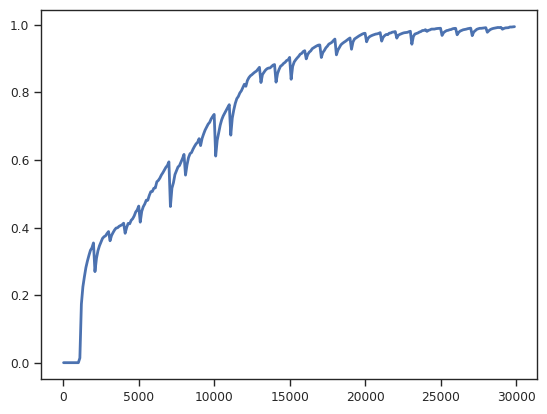

In [11]:
forg['holdout_switch'].plot()

In [17]:
for param_group in toy_bert_model.parameters():
    print(param_group)

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.2574, -0.3721,  0.0404,  ...,  0.4367, -0.5287, -0.4120],
        [-1.0865, -1.7465, -0.9616,  ...,  2.2141, -1.0690, -1.0676],
        ...,
        [ 0.4063,  1.3262, -0.7027,  ..., -1.4285, -0.2514, -0.4260],
        [-0.4331, -1.4403, -1.1921,  ..., -0.9387, -0.3872,  2.0188],
        [ 0.8428,  0.4014,  0.2739,  ..., -0.3042,  0.7096, -0.5171]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0130, -0.0153,  0.0006,  ...,  0.0158,  0.0070, -0.0103],
        [-0.0211,  0.0084, -0.0190,  ..., -0.0436, -0.0192, -0.0024],
        [ 0.0469,  0.0027, -0.0017,  ...,  0.0118,  0.0094,  0.0080],
        ...,
        [ 0.0038, -0.0205,  0.0179,  ..., -0.0264, -0.0198,  0.0141],
        [-0.0130,  0.0182, -0.0043,  ...,  0.0027,  0.0096, -0.0466],
        [-0.0029, -0.0108,  0.0436,  ...,  0.0056, -0.0213,  0.0047]],
       device='cuda:0', requires_grad=True)


In [29]:
hist_df = pd.DataFrame(hist)

In [6]:
prop_amb_all=0.0
tail_end=False
switch=False
random_v=False
holdout_once=True
holdout=False
amb_only=False
non_amb_only=False
device=None

In [5]:
from kneed.knee_locator import KneeLocator

def center_gravity(p=0.05):
    pass

    
def get_pushdown(df_name, skip=2, sep=','):
    df = pd.read_csv(df_name, sep=sep)
    layer_knees = {}
    min_knee, max_knee, sum_diffs = 100000, 0, 0

    if 'Layer' in df.columns:
        df['Layer'] = df['Layer'].apply(lambda x: int(x.split(".")[-1]) + 1 if "." in x else 0)
        df.index = df['Layer']
        df.drop('Layer', axis=1, inplace=True)
    elif 'Unnamed: 0' in df.columns:
        df.index = df['Unnamed: 0']
        df.drop('Unnamed: 0', axis=1, inplace=True)
    df = df.sort_index()
    
    ax = plt.subplot()
    x = [int(v) for v in df.columns.tolist()][skip:]
    for idx in df.index:
        y = df.iloc[idx][skip:]
        # y = y[::-1]
        y = y.rolling(window=8, min_periods=1).mean()
        # y_smooth = y_smooth[::-1]
        # spl = UnivariateSpline(x, y_smooth, k=3)
        # y_smooth = spl(y_smooth)
        # print(len(x), len(y_smooth))
        ax.plot(x, y, label=idx)
        kl = KneeLocator(x, y)#, interp_method='polynomial', polynomial_degree=7)
        # kl.plot_knee()
        layer_knees[idx] = kl.knee
        # print(max(kl.all_knees))
        # if layer_knees[idx] < min_knee:
        #     min_knee = layer_knees[idx]
        # if layer_knees[idx] > max_knee:
        #     max_knee = layer_knees[idx]

    ax.legend()
    for idx in range(len(layer_knees)-1, 0, -1):
        # print(layer_knees, idx)
        sum_diffs += layer_knees[idx] - layer_knees[idx-1]

    plt.figure()
    sns.heatmap(df[::-1], annot=False, cbar_kws={'orientation': 'horizontal'})
    return min_knee, max_knee, sum_diffs

(100000, 0, -40)

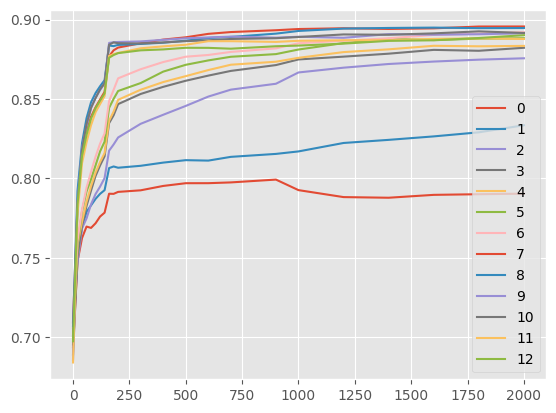

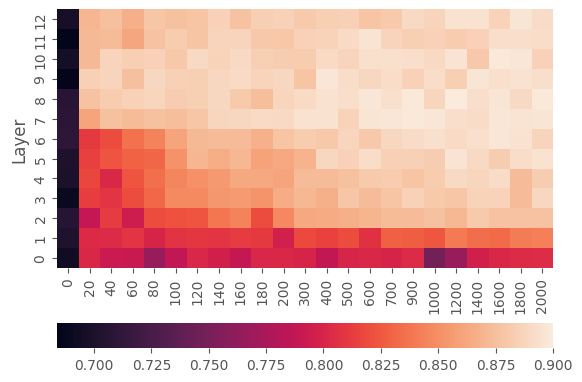

In [25]:
# df = pd.read_csv('../../outputs/en_ewt-ud/seed_0/fpos/Val_Acc.csv', sep='\t')
get_pushdown('../../outputs/en_ewt-ud/seed_0/fpos/Val_Acc.csv', skip=0, sep='\t')

In [19]:
def dir_deriv(df_name):
    df = pd.read_csv(df_name)
    gradient_y, gradient_x = np.gradient(df.values)
    x, y = np.array(range(len(df.columns))), np.array(list(df.index)) #[int(v) for v in df.columns]
    X, Y = np.meshgrid(x, y)
    
    fig, ax = plt.subplots()    
    plt.quiver(X, Y, gradient_x, gradient_y, color='red')
    plt.title('Vector Field of Gradients')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()
    dx, dy = 1 / np.sqrt(2), -1 / np.sqrt(2)
    directional_derivative = gradient_x * dx + gradient_y * dy
    return np.mean(directional_derivative)

In [45]:
import matplotlib.gridspec as gridspec

def timing_plot(prefix="zipf", sf=5000, amb=0.10, vs=1000, a=1.0001, include_switch=True, holdout=False, output_file='../../figures/toy_model/all/zipf_vs=1000_a=1.0001.png'):

    if amb > 0:
        amb = f'{amb:0.2f}'
    else:
        amb = f'{amb:0.1f}'
    df = pd.read_csv(f'../../outputs/toy_model/{prefix}_{sf}-amb_{amb}-vs_{vs}-a_{a}/hist.csv', index_col=0)    
    fig = plt.figure(figsize=(8, 12))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.loc[:, ~df.columns.str.contains('val_loss')]
    df_ambs = df.loc[:, df.columns.str.contains('amb')]
    df = df.loc[:, ~df.columns.str.contains('amb')]
    if a == 0:
        df['unif_amb'] = df_ambs['unif_amb']
        df['unif_nonamb']=df_ambs['unif_nonamb']
    if 'bin_0_amb' in df_ambs.columns and amb:
        df['top_amb'] = df_ambs['bin_0_amb']
        df['bot_amb'] = df_ambs['bin_9_amb']
        df['top_unamb'] = df_ambs['bin_0_nonamb']
        df['bot_unamb'] = df_ambs['bin_9_nonamb']
    if not holdout:
        df = df.drop('holdout_switch',axis=1)
        df = df.drop('holdout',axis=1)
    
        
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
    
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    df = df.T

    for metric in df.columns:
        df[metric].plot(ax=ax1)
    
    # acc.iloc[0].plot(ax=ax1)
    # l1 = 'Tail' if tail else 'Val'
    # if include_switch:
    #     acc_sw.iloc[0].plot(ax=ax1)
    #     ax1.legend([l1, 'Switch'])
        
    ax1.set_title("Masked Token Accuracy")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Accuracy")
    ax1.legend(df.columns)
    print(df.index)
    
    df_results = pd.read_csv(f'../../outputs/toy_model/{prefix}_{sf}-amb_{amb}-vs_{vs}-a_{a}/pos_probing_results_val.csv', index_col=0)
    sns.heatmap(df_results, ax=ax2, annot=False, cbar_kws={'orientation': 'horizontal'})
    print(df_results.index)
    
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Layer")
    ax2.set_title(f"POS Probing")
    if output_file is not None:
        plt.savefig(output_file)

In [22]:
def timing_plot_w_tail(prefix="zipf", vs=1000, a=1.0001, amb=0.0, include_switch=True, output_file='../../figures/toy_model/both/zipf_vs=1000_a=1.0001.png'):
    # if include_switch:
    if amb > 0:
        amb = f'{amb:0.2f}'
    df_sw = pd.read_csv(f'../../outputs/toy_model/{prefix}-amb_{amb}-vs_{vs}-a_{a}/hist_switch.csv')
    acc_sw = df_sw[df_sw['Unnamed: 0'] == 'acc'].drop('Unnamed: 0', axis=1)
    
    df = pd.read_csv(f'../../outputs/toy_model/{prefix}-amb_{amb}-vs_{vs}-a_{a}/hist_val.csv')
    acc = df[df['Unnamed: 0'] == 'acc'].drop('Unnamed: 0', axis=1)
    
    df_tail = pd.read_csv(f'../../outputs/toy_model/{prefix}-amb_{amb}-vs_{vs}-a_{a}/hist_tail.csv')
    acc_tail = df_tail[df_tail['Unnamed: 0'] == 'acc'].drop('Unnamed: 0', axis=1)

    df_sw_tail = pd.read_csv(f'../../outputs/toy_model/{prefix}-amb_{amb}-vs_{vs}-a_{a}/hist_tail_switch.csv')
    acc_sw_tail= df_sw_tail[df_sw_tail['Unnamed: 0'] == 'acc'].drop('Unnamed: 0', axis=1)
    
    fig = plt.figure(figsize=(16, 12))
    
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 3], width_ratios=[1, 1])
    
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax3 = fig.add_subplot(gs[2])
    ax4 = fig.add_subplot(gs[3], sharex=ax3)
    
    acc.iloc[0].plot(ax=ax1)
    if include_switch:
        acc_sw.iloc[0].plot(ax=ax1)
        ax1.legend(['Val', 'Switch'])
        
        
    ax1.set_title("Masked Token Accuracy")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Accuracy")

    acc_tail.iloc[0].plot(ax=ax2)
    if include_switch:
        acc_sw_tail.iloc[0].plot(ax=ax2)
        ax2.legend(['Tail', 'Tail Switch'])
        
    ax2.set_title("Masked Tail Token Accuracy")
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Accuracy")
    
    df = pd.read_csv(f'../../outputs/toy_model/{prefix}-amb_{amb}-vs_{vs}-a_{a}/pos_probing_results_val.csv')
    df.index = df['Unnamed: 0'] 
    df = df.drop('Unnamed: 0', axis=1)
    sns.heatmap(df, ax=ax3, annot=False, cbar_kws={'orientation': 'horizontal'})
    
    ax3.set_xlabel("Step")
    ax3.set_ylabel("Layer")
    ax3.set_title(f"POS Probing")
    
    df_tail = pd.read_csv(f'../../outputs/toy_model/{prefix}-amb_{amb}-vs_{vs}-a_{a}/pos_probing_results_tail.csv')
    df_tail.index = df_tail['Unnamed: 0'] 
    df_tail = df_tail.drop('Unnamed: 0', axis=1)
    sns.heatmap(df_tail, ax=ax4, annot=False, cbar_kws={'orientation': 'horizontal'})
    
    ax4.set_xlabel("Step")
    ax4.set_ylabel("Layer")
    ax4.set_title(f"POS Tail Probing")
    plt.tight_layout()

    plt.savefig(output_file)
    plt.show()
    

In [19]:
# dir = {'zipf': 16, 'zipfb': 32, 'zipfbb': 128}
# for prefix in ["zipf", "zipfb", "zipfbb"]:
#     for vs in [100, 1000, 10000, 20000]:
#         for a in [1.0001, 1.2, 1.5]:
#             try:
#                 dir_num = dir[prefix]
#                 timing_plot_w_tail(prefix=prefix, vs=vs, a=a, include_switch=True, 
#                                    output_file=f'../../figures/toy_model/both/{dir_num}/vs={vs}_a={a}.png')
#             except:
#                 continue

In [77]:
import ast
import json

def plot_hist(prefix='zipf-', output_path='../../figures/toy_model/zipf_16.png', amb=True, holdout=True, vs=1000):
    root_directory = '../../outputs/toy_model/'
    csv_roots = []
    for root, dirs, files in os.walk(root_directory):
        if prefix in os.path.basename(root):
            if 'hist.csv' in files and 'old' not in root and 'old_params' not in root \
            and 'amb_0.0-' not in root and 'vs_100-' not in root and f'vs_{vs}-' in root and 'amb_0.10-' in root:
                csv_roots.append(root)
    # print(csv_roots)
    # csv_files = [f for f in csv_files if '100-' not in f] ## remove 100- files
    nrows = len(csv_roots) // 4 + (len(csv_roots) % 4 > 0)
    ncols = 4
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3.5 * nrows))
    fig.tight_layout(pad=5.0)
    vmax = vmin = None
    titles=['Uniform', r'$\alpha=1.0001$', r'$\alpha=1.2$', r'$\alpha=1.5$']
    for i, root in enumerate(csv_roots):
        df = pd.read_csv(os.path.join(root, 'hist.csv'))
        print(root)
        df.index = df['Unnamed: 0']
        df.drop(['Unnamed: 0'], axis=1, inplace=True)
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        df = df.loc[:, ~df.columns.str.contains('val_loss')]
        df_ambs = df.loc[:, df.columns.str.contains('amb')]
        df = df.loc[:, ~df.columns.str.contains('amb')]
        if 'a_0' in root:
            df['unif_amb'] = df_ambs['unif_amb']
            df['unif_nonamb']=df_ambs['unif_nonamb']
        if 'bin_0_amb' in df_ambs.columns and amb:
            df['top_amb'] = df_ambs['bin_0_amb']
            df['bot_amb'] = df_ambs['bin_9_amb']
            df['top_unamb'] = df_ambs['bin_0_nonamb']
            df['bot_unamb'] = df_ambs['bin_9_nonamb']
        if not holdout:
            df = df.drop('holdout_switch',axis=1)
            df = df.drop('holdout',axis=1)
        # df = df[['holdout_switch', 'holdout']]
        
        if nrows == 1:
            ax = axes[i]
        else:
            ax = axes[i // ncols, i % ncols]

        for metric in df.columns:
            df[metric].plot(ax=ax)

        ax.set_title(titles[i], fontsize=16)
        # ax.set_title('-'.join(root.split('/')[-1].split('-')[1:]))
        ax.set_xlabel("Step", fontsize=12)
        if i == 0:
            ax.set_ylabel("Accuracy", fontsize=12)
        # plt.xticks(rotation=45) 
        # if 'amb_0.0' not in root:
        #     ax.legend(['Val', 'Tail', 'Switch', 'Switch Tail'])
        # else:
        if i == 0 or i == 1:
            ax.legend([col.replace('_', ' ') for col in df.columns], frameon=False, fontsize=10, loc='best')

    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')
    plt.tight_layout()
    plt.savefig(output_path)


def plot_hist_amb(prefix='zipf-', output_path='../../figures/toy_model/zipf_16.png', nonamb_switch=True, vs=1000):
    root_directory = '../../outputs/toy_model/'
    csv_roots = []
    for root, dirs, files in os.walk(root_directory):
        if prefix in os.path.basename(root):
            if 'hist.csv' in files and 'old' not in root and 'old_params' not in root \
            and 'amb_0.0-' not in root and root.split('a_')[-1] != '0' and 'vs_100-' not in root and f'vs_{vs}-' in root:
                csv_roots.append(root)
    # print(csv_roots)
    # csv_files = [f for f in csv_files if '100-' not in f] ## remove 100- files
    nrows = len(csv_roots) // 3 + (len(csv_roots) % 3 > 0)
    ncols = 3
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3.5 * nrows))
    fig.tight_layout(pad=5.0)
    vmax = vmin = None
    
    for i, root in enumerate(csv_roots):
        # print(root)
        df = pd.read_csv(os.path.join(root, 'hist.csv'))
        df.index = df['Unnamed: 0']
        df.drop(['Unnamed: 0'], axis=1, inplace=True)
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        df = df.loc[:, ~df.columns.str.contains('val_loss')]
        
        
        df = df[['bin_0_amb', 'bin_9_amb', 'holdout', 'holdout_switch',
                 'bin_0_nonamb', #'bin_2_amb', 'bin_4_amb', 'bin_7_amb', 
                 'bin_1_nonamb', 'bin_2_nonamb', 'bin_3_nonamb',
                 'bin_4_nonamb', 'bin_5_nonamb', 'bin_6_nonamb', 'bin_7_nonamb', 'bin_8_nonamb', 
                 'bin_9_nonamb', 'bin_0_nonamb_switch', 'bin_9_nonamb_switch']]
        if not nonamb_switch:
            df = df.drop(['bin_0_nonamb_switch', 'bin_9_nonamb_switch'], axis=1)
        df = df.rename({'bin_0_amb': 'top_amb', 
                       'bin_9_amb': 'bot_amb', 
                       'bin_0_nonamb': 'top_nonamb', 
                       'bin_9_nonamb': 'bot_nonamb', 
                       'bin_0_nonamb_switch': 'top_nonamb_switch', 
                       'bin_9_nonamb_switch': 'bot_nonamb_switch'
                       }, axis=1)
        
        if nrows == 1:
            ax = axes[i]
        else:
            ax = axes[i // ncols, i % ncols]

        for metric in df.columns:
            df[metric].plot(ax=ax)
            
        ax.set_title('-'.join(root.split('/')[-1].split('-')[1:]))
        ax.set_xlabel("Step")
        ax.set_ylabel("Accuracy")
        # ax.set_xticklabels(df.index, rotation=45, ha='right') 
        if i == 0:
            ax.legend(df.columns)

        # if 'amb_0.0' not in root:
        #     ax.legend(['Val', 'Tail', 'Switch', 'Switch Tail'])
        # else:
        
    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')
    plt.tight_layout()
    plt.savefig(output_path)

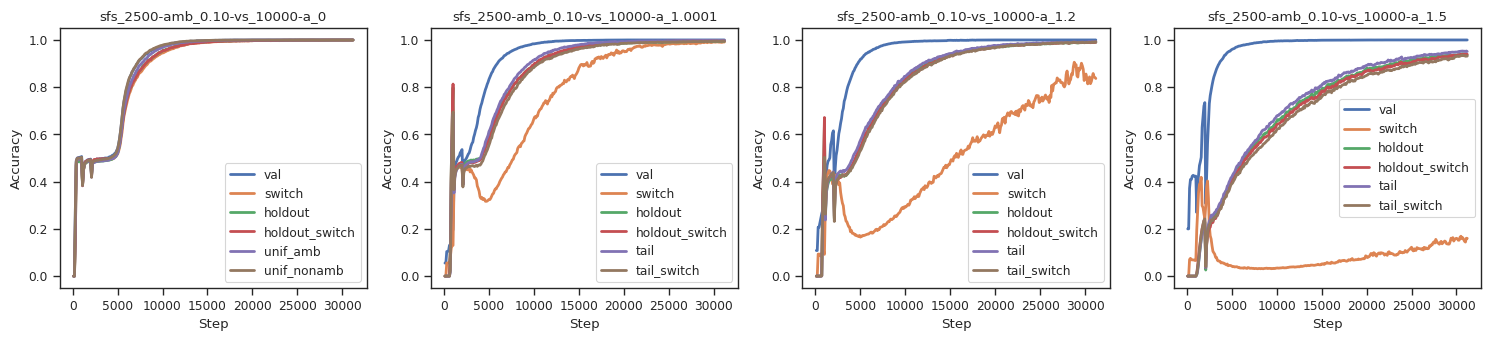

In [13]:
plot_hist(prefix='zipfw-sfs', output_path='../../figures/toy_model/forg-zipf_64_amb.png', amb=False, holdout=True, vs=10000)

../../outputs/toy_model/zipfw-amb_0.10-vs_10000-a_0
../../outputs/toy_model/zipfw-amb_0.10-vs_10000-a_1.0001
../../outputs/toy_model/zipfw-amb_0.10-vs_10000-a_1.2
../../outputs/toy_model/zipfw-amb_0.10-vs_10000-a_1.5


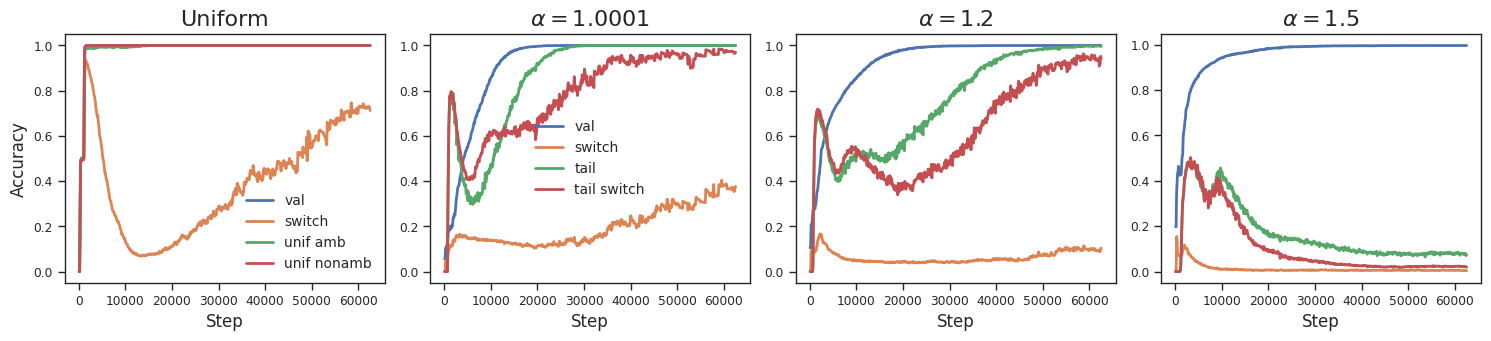

In [78]:
plot_hist(prefix='zipfw-a', output_path='../../figures/toy_model/forg-zipf_64_amb.png', amb=False, holdout=False, vs=10000)
# plot_hist(prefix='zipfw-sf', output_path='../../figures/toy_model/forg-zipf_64_amb.png', amb=False, holdout=True, vs=10000)


In [93]:
def generate_switch_holdout_plots(output_path, forget=False):
    nrows=1
    ncols=3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    fig.tight_layout(pad=5.0)
    legend=['Uniform', r'$\alpha=1.0001$', r'$\alpha=1.2$', r'$\alpha=1.5$']
    root_directory = '../../outputs/toy_model/'
    csv_roots = ['../../outputs/toy_model/zipfw-amb_0.10-vs_10000-a_0',
            '../../outputs/toy_model/zipfw-amb_0.10-vs_10000-a_1.0001',
            '../../outputs/toy_model/zipfw-amb_0.10-vs_10000-a_1.2',
            '../../outputs/toy_model/zipfw-amb_0.10-vs_10000-a_1.5']
    if forget:
        csv_roots = ['../../outputs/toy_model/zipfw-f_1000-amb_0.10-vs_10000-a_0',
            '../../outputs/toy_model/zipfw-f_1000-amb_0.10-vs_10000-a_1.0001',
            '../../outputs/toy_model/zipfw-f_1000-amb_0.10-vs_10000-a_1.2',
            '../../outputs/toy_model/zipfw-f_1000-amb_0.10-vs_10000-a_1.5']

    for idx, metric in enumerate(['Switch Accuracy', 'Tail Switch Accuracy', 'Unseen Token Accuracy']):
        for i, root in enumerate(csv_roots):
            df = pd.read_csv(os.path.join(root, 'hist.csv'), index_col=0)
            if metric == 'Switch Accuracy':
                df['switch'].plot(ax=axes[idx])
            elif metric == 'Tail Switch Accuracy':
                name = 'tail_switch' if i > 0 else 'switch'
                df[name].plot(ax=axes[idx])
            else:
                df['holdout'].plot(ax=axes[idx])
        # axes[idx].set_title(metric, fontsize=18)
        axes[idx].set_xlabel("Step", fontsize=12)
        if metric == 'Switch Accuracy':
            axes[idx].set_ylabel("Accuracy", fontsize=12)
        if idx == 0:
            axes[idx].legend(legend, frameon=False, fontsize=12, loc='best')
        
    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')
    plt.tight_layout()
    plt.savefig(output_path)

def generate_stop_forgetting_control(output_path):
    nrows=1
    ncols=2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    fig.tight_layout(pad=5.0)
    legend=[r'$N=5000$', r'$N=10000$', r'$N=20000$', r'$N=\infty$']
    colors = ["#E0B0FF", "#D291BC", "#800080", "#4B0082"]
    csv_roots = [
        '../../outputs/toy_model/zipfw-sf_5000-amb_0.10-vs_10000-a_1.5',
        '../../outputs/toy_model/zipfw-sf_10000-amb_0.10-vs_10000-a_1.5',
        '../../outputs/toy_model/zipfw-sf_20000-amb_0.10-vs_10000-a_1.5',
        '../../outputs/toy_model/zipfw-f_1000-amb_0.10-vs_10000-a_1.5'
    ]

    for idx, metric in enumerate(['Switch Accuracy', 'Unseen Token Accuracy']):
        for i, root in enumerate(csv_roots):
            df = pd.read_csv(os.path.join(root, 'hist.csv'), index_col=0)
            if metric == 'Switch Accuracy':
                # (df['val'] - df['switch']).plot(ax=axes[idx])
                # (df['val']).plot(ax=axes[idx])
                df['switch'].plot(ax=axes[idx], color=colors[i])
            elif metric == 'Tail Switch Accuracy':
                # (df['tail'] - df['tail_switch']).plot(ax=axes[idx])
                df['tail_switch'].plot(ax=axes[idx], color=colors[i])
                # print('here')
            else:
                df['holdout'].plot(ax=axes[idx], color=colors[i])
        axes[idx].set_title(metric, fontsize=18)
        axes[idx].set_xlabel("Step", fontsize=12)
        if metric == 'Switch Accuracy':
            axes[idx].set_ylabel("Accuracy", fontsize=12)
        if idx == 0:
            axes[idx].legend(legend, frameon=False, fontsize=12, loc='best')
        
    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')
    plt.tight_layout()
    plt.savefig(output_path)

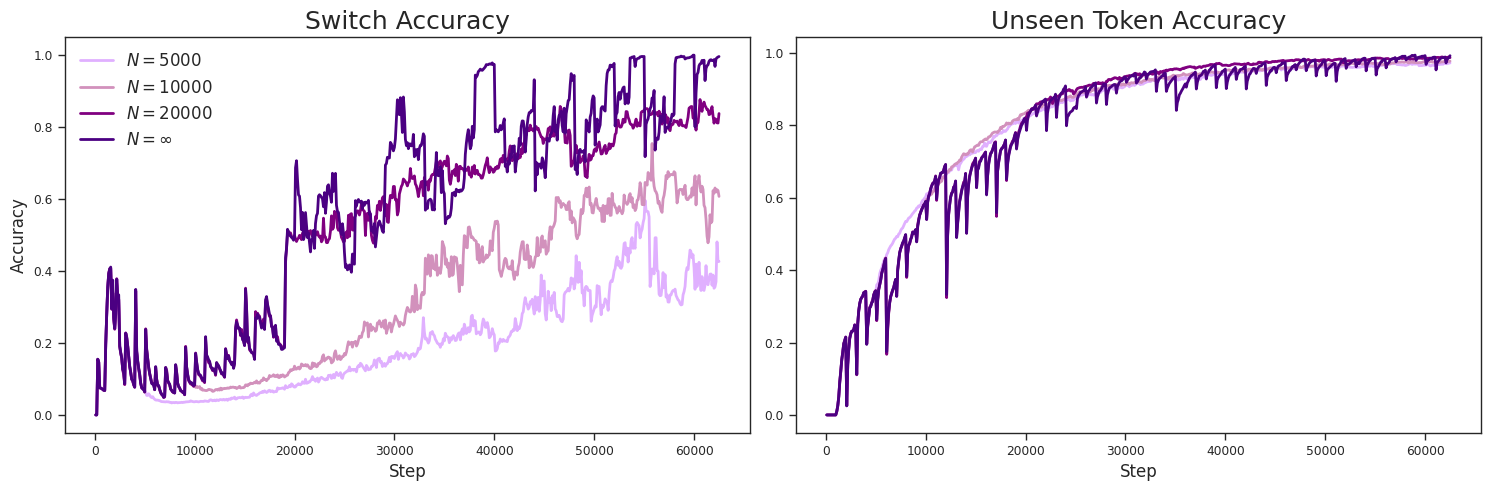

In [94]:
sns.set_theme(context="paper", style="ticks", rc={"lines.linewidth": 2})
# generate_switch_holdout_plots('../../figures/icl_by_dist.png')
# generate_switch_holdout_plots('../../figures/icl_by_dist_af.png', forget=True)
generate_stop_forgetting_control('../../figures/strat_w_sf.png')

In [ ]:
generate_switch_holdout_plots('../../figures/icl_by_dist.png')

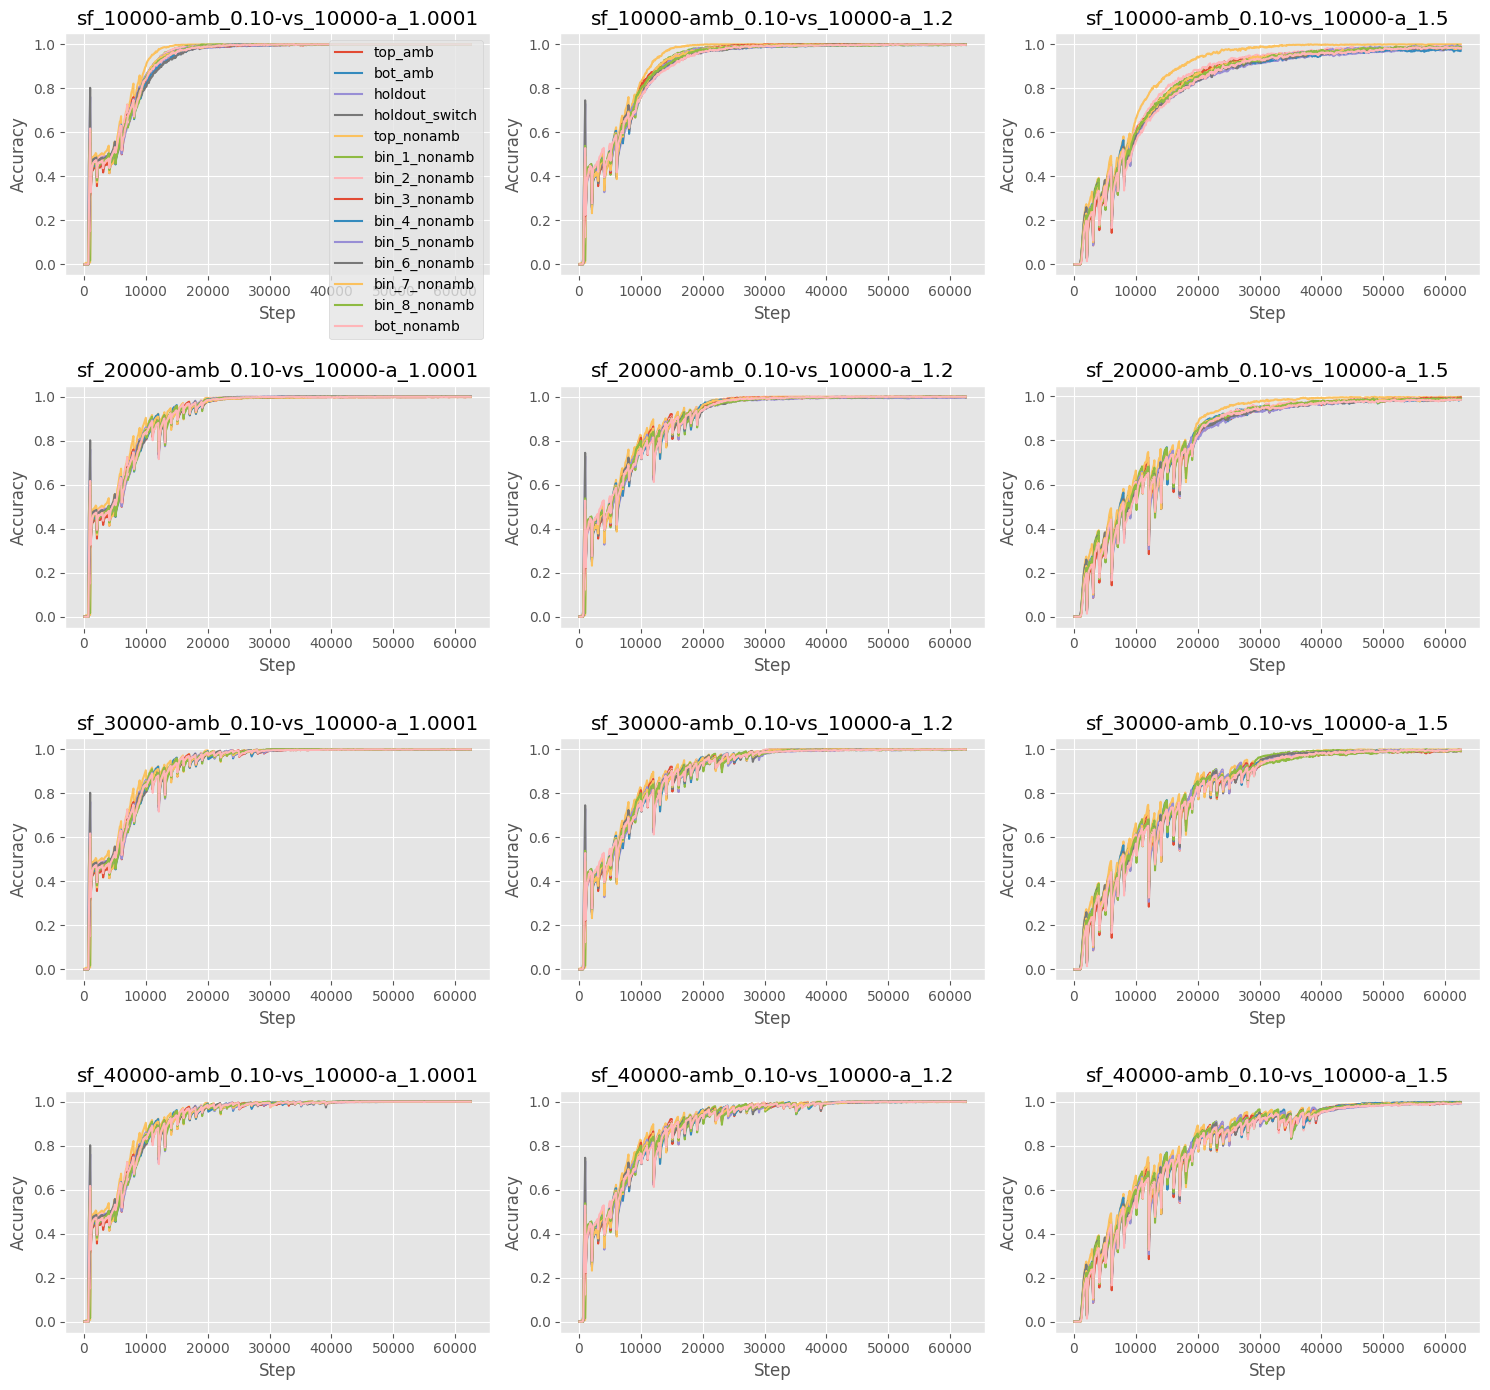

In [9]:
plot_hist_amb(prefix='zipfw-sf', output_path='../../figures/toy_model/forg-zipf_64_amb.png', nonamb_switch=False, vs=10000)

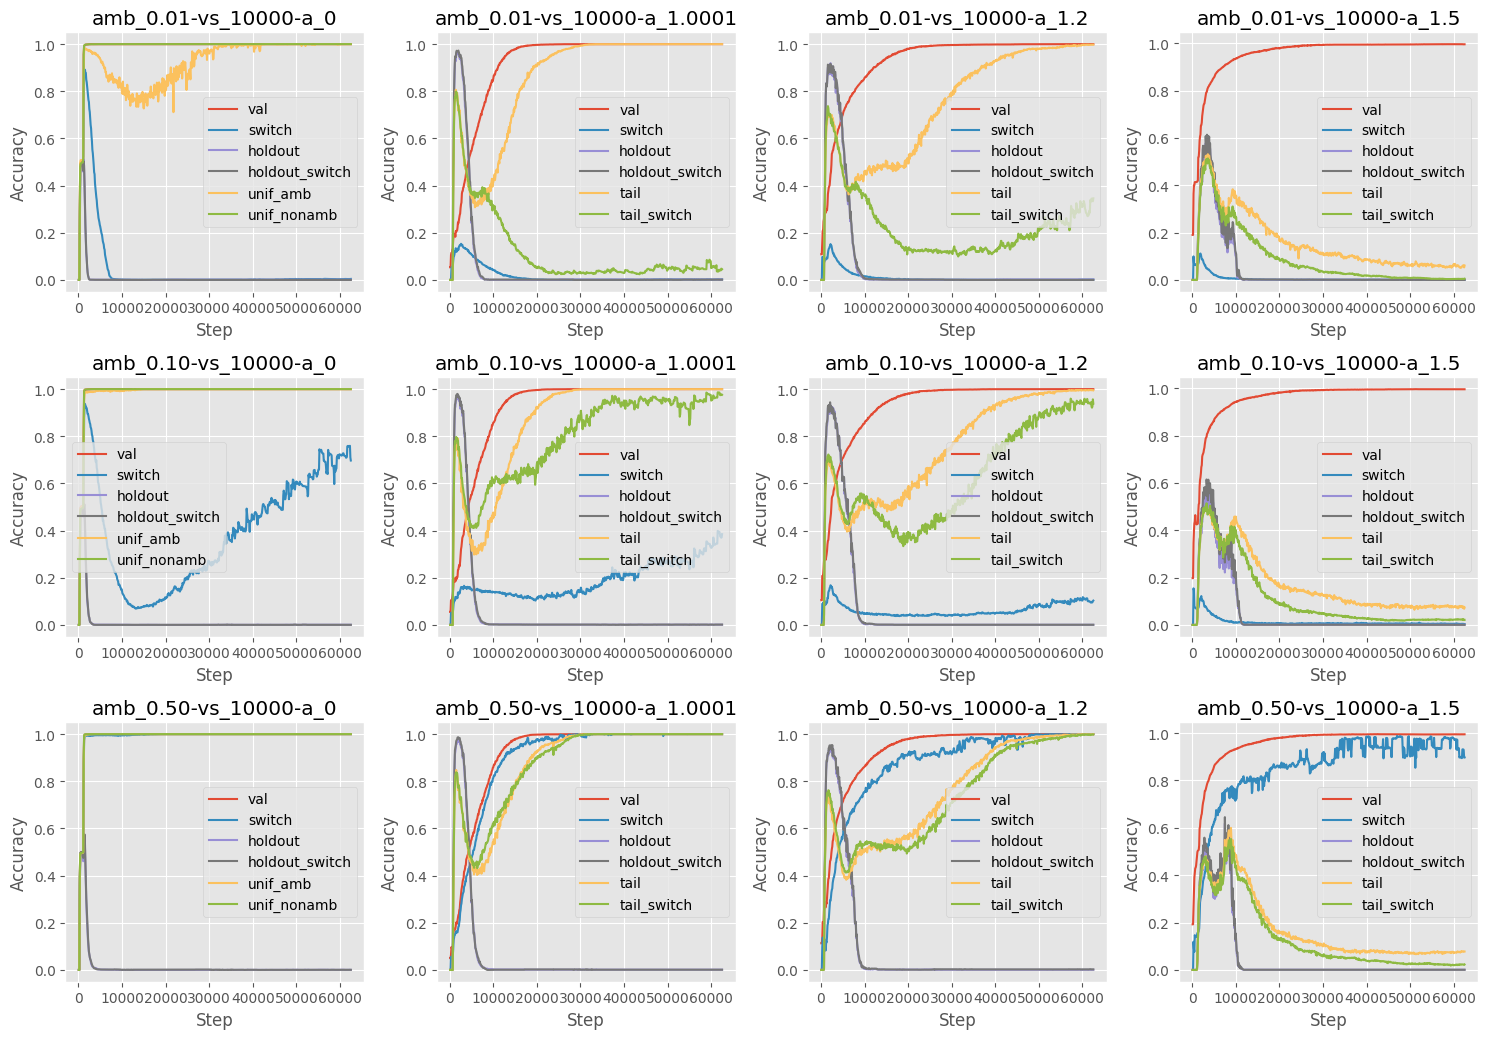

In [67]:
plot_hist(prefix='zipfw-a', output_path='../../figures/toy_model/forg-zipf_64_amb.png', amb=False, holdout=True, vs=10000)

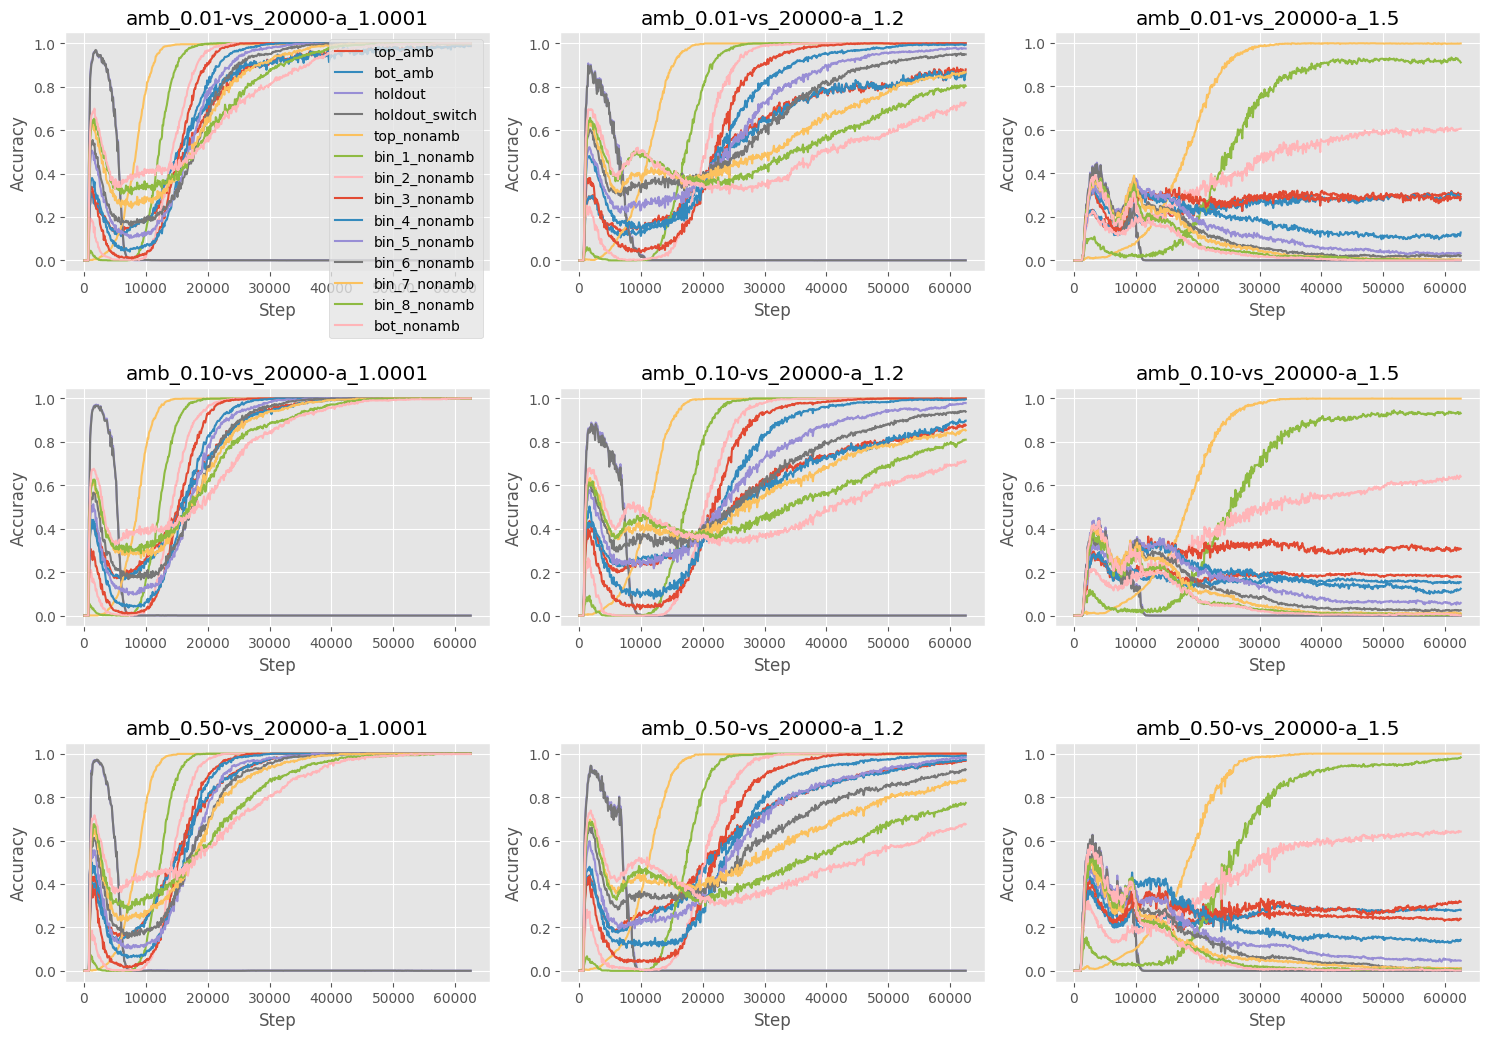

In [73]:
plot_hist_amb(prefix='zipfw-a', output_path='../../figures/toy_model/forg-w-zipf_64_amb.png', nonamb_switch=False, vs=20000)

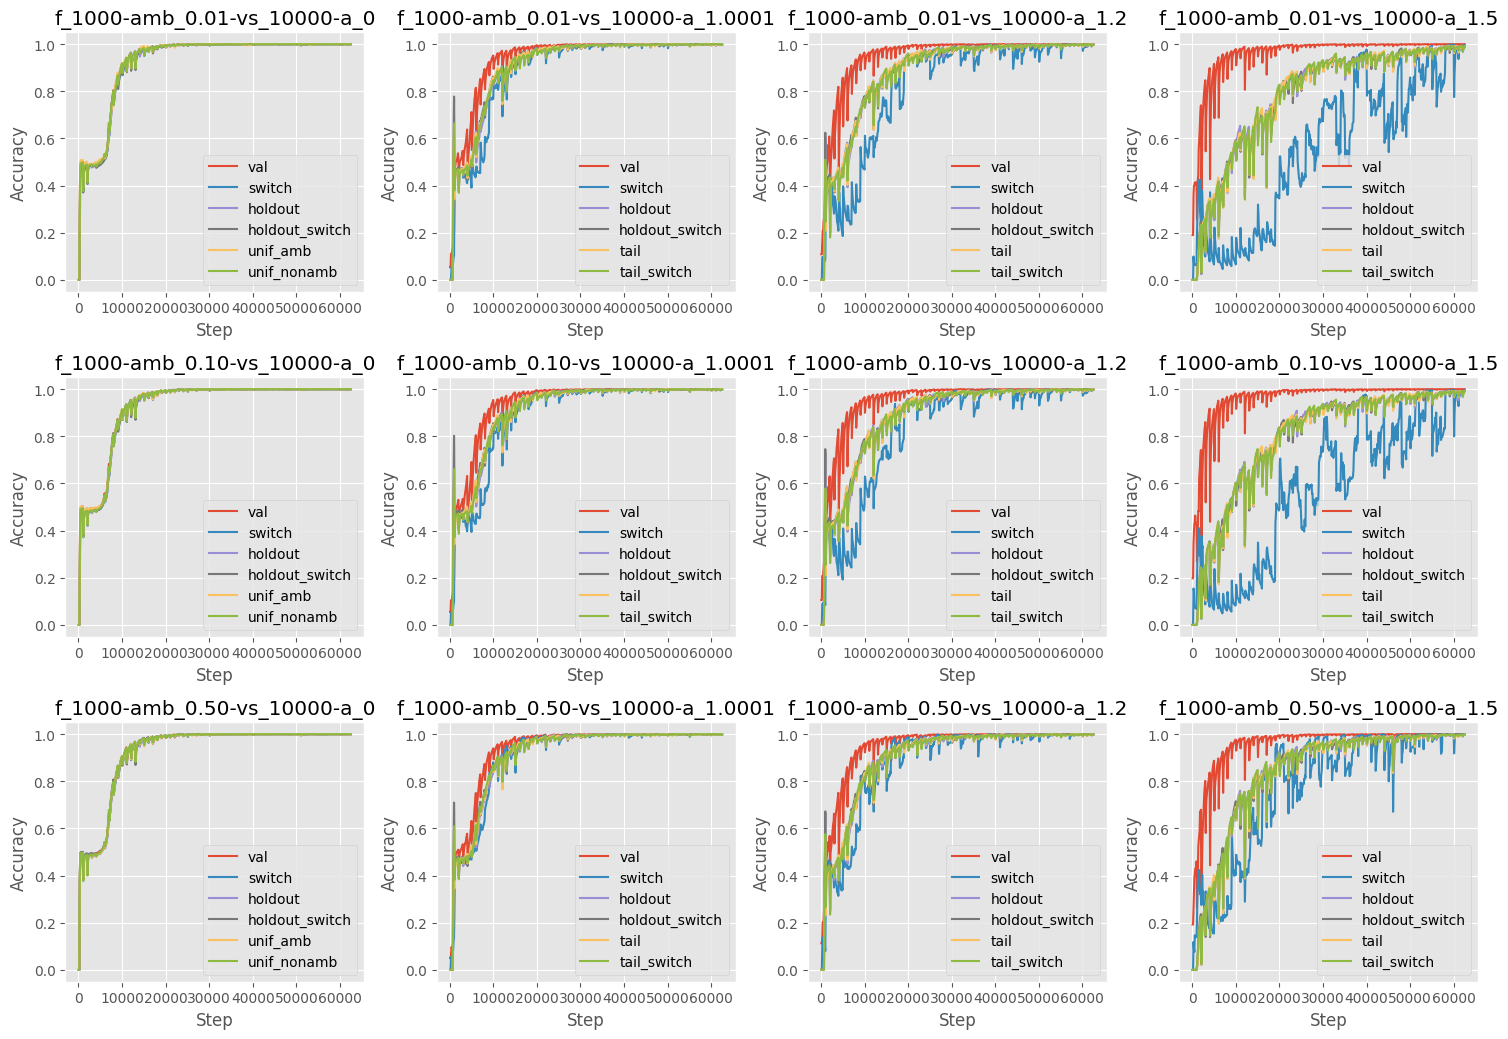

In [4]:
plot_hist(prefix='zipfw-f', output_path='../../figures/toy_model/forg-zipf_64_amb.png', amb=False, holdout=True, vs=10000)

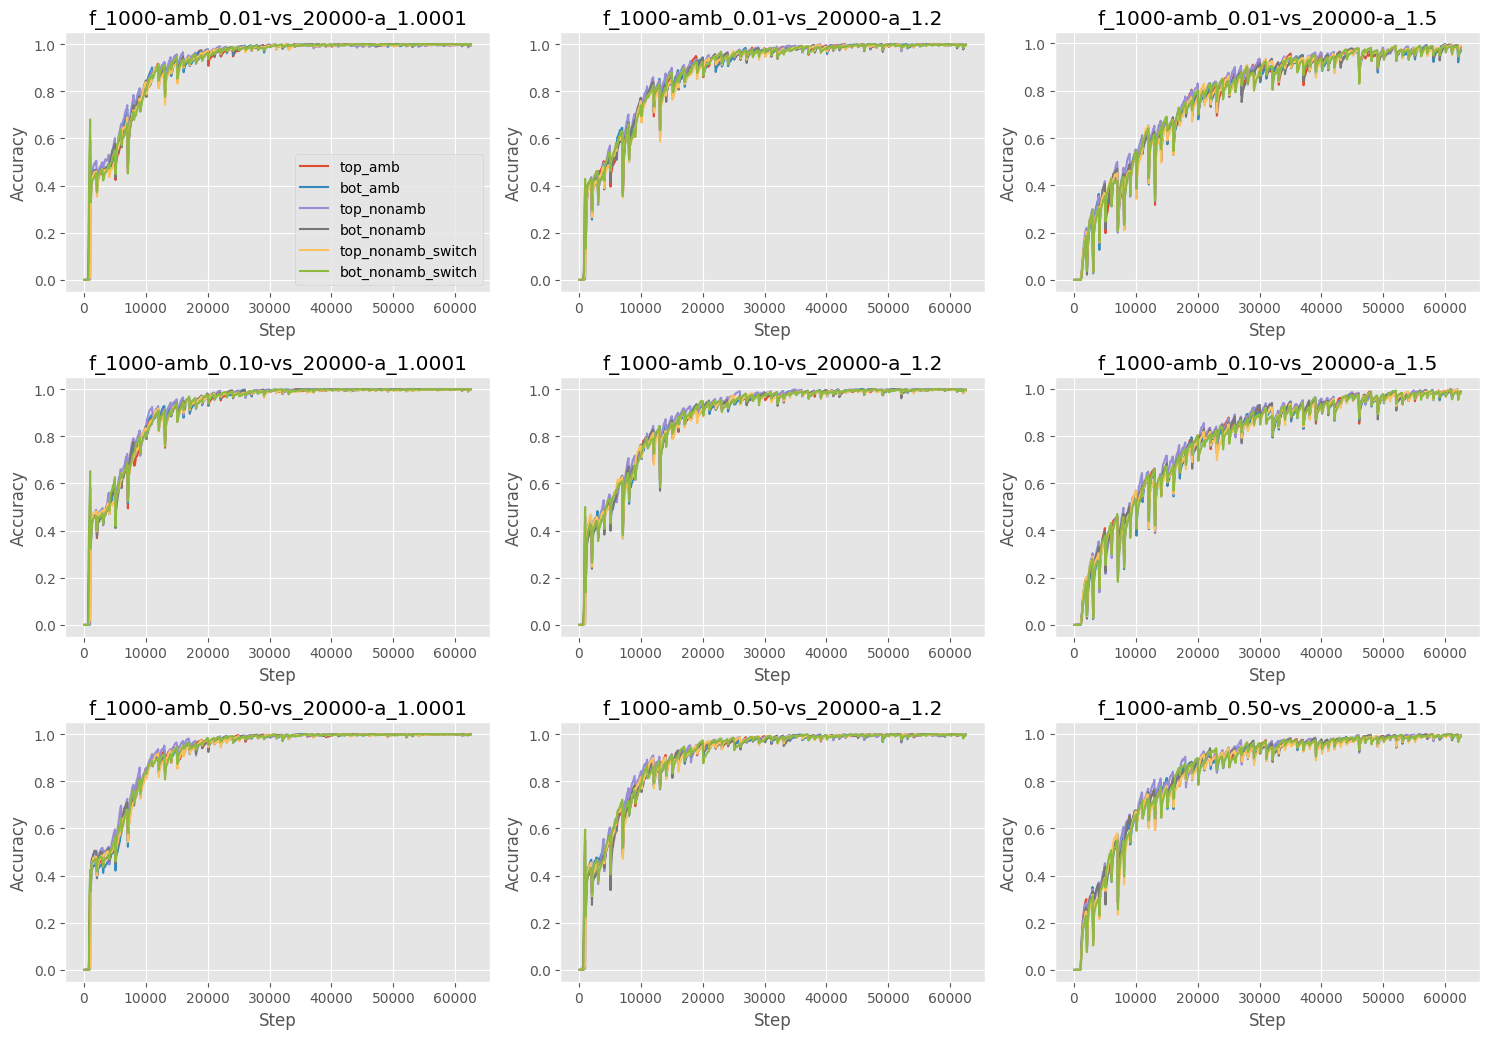

In [69]:
plot_hist_amb(prefix='zipfw-f', output_path='../../figures/toy_model/forg-w-zipf_64_amb.png', nonamb_switch=True, vs=20000)

---------------------

In [39]:
# plot_hist_amb(prefix='zipfr-f', output_path='../../figures/toy_model/forg-w-zipf_64_amb.png', nonamb_switch=True)

In [40]:
# plot_hist(prefix='zipfr-', output_path='../../figures/toy_model/0.01-w-zipf_64_amb.png', amb=False, holdout=False)

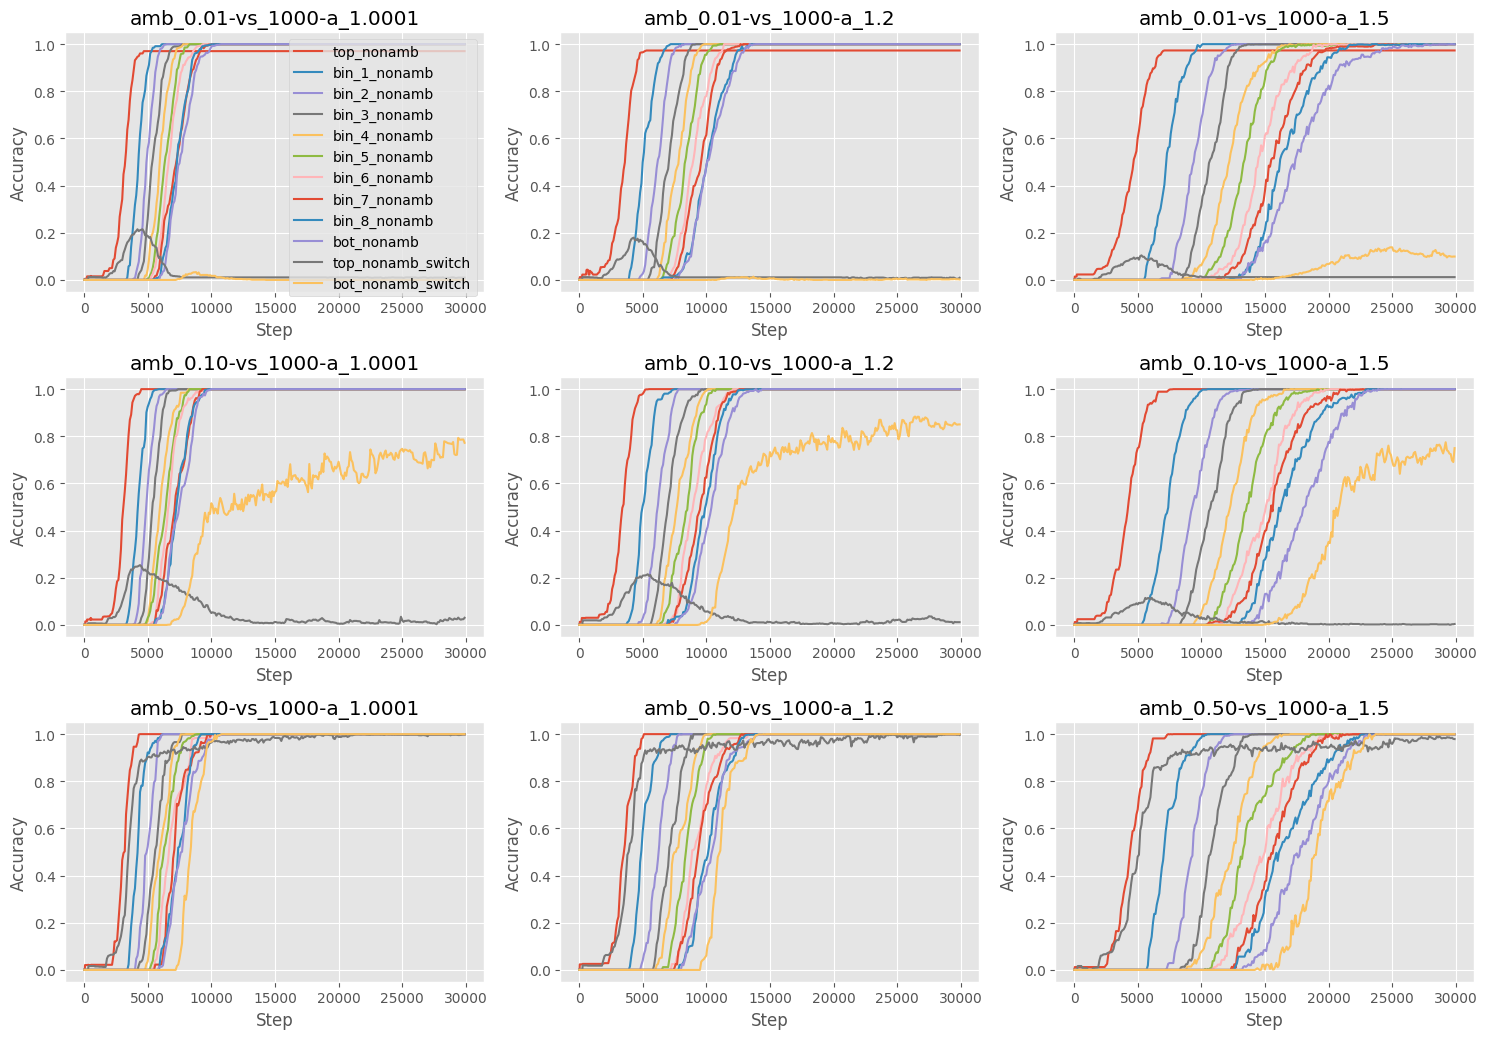

In [60]:
# plot_hist(prefix='zipfw-', output_path='../../figures/toy_model/0.0-w-zipf_64_amb.png')
plot_hist_amb(prefix='zipfr-a', output_path='../../figures/toy_model/0.01-w-zipf_64_amb.png', nonamb_switch=True)

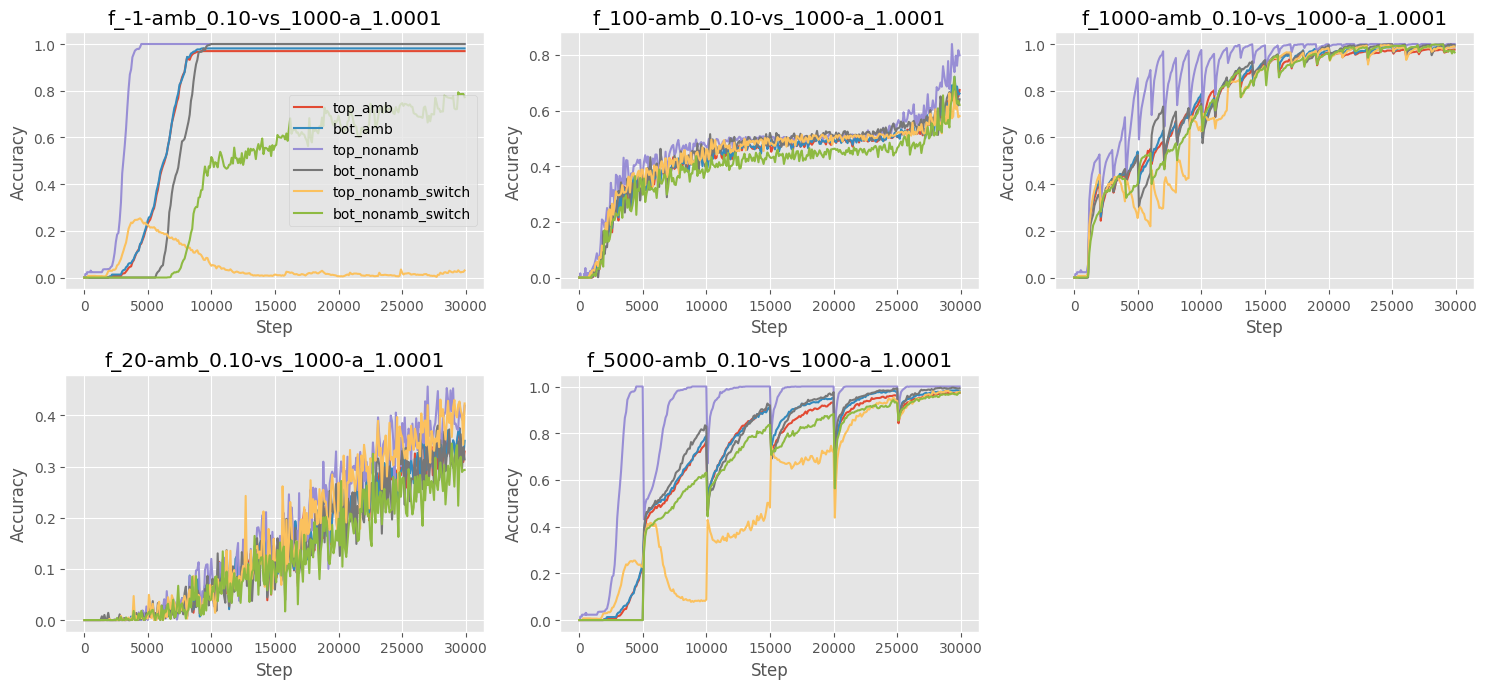

In [42]:
plot_hist_amb(prefix='zipfr-f', output_path='../../figures/toy_model/0.01-w-zipf_64_amb.png', nonamb_switch=True)

In [78]:
def plot_grid_acc(prefix='zipf-', output_path='../../figures/toy_model/zipf_16.png'):
    root_directory = '../../outputs/toy_model/'
    csv_roots = []
    for root, dirs, files in os.walk(root_directory):
        if prefix in os.path.basename(root):
            if 'hist_tail.csv' in files and 'hist_val.csv' in files and 'hist_switch.csv' in files and 'old' not in root and 'old_params' not in root \
            and 'amb_0.01' not in root: #and 'vs_10000' in root:
                csv_roots.append(root)
    # print(csv_roots)
    # csv_files = [f for f in csv_files if '100-' not in f] ## remove 100- files
    nrows = len(csv_roots) // 3 + (len(csv_roots) % 3 > 0)
    ncols = 3
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3.5 * nrows))
    fig.tight_layout(pad=5.0)
    vmax = vmin = None
    
    for i, root in enumerate(csv_roots):
        dfs = []
        df_val = pd.read_csv(os.path.join(root, 'hist_val.csv'))
        # df_random = pd.read_csv(os.path.join(root, 'hist_random.csv'))
        df_tail = pd.read_csv(os.path.join(root, 'hist_tail.csv'))
        df_switch = pd.read_csv(os.path.join(root, 'hist_switch.csv'))
        df_tail_switch = pd.read_csv(os.path.join(root, 'hist_tail_switch.csv'))
        dfs = [df_val, df_tail, df_switch, df_tail_switch]
        # if 'amb_0.0' not in root:
        #     df_amb = pd.read_csv(os.path.join(root, 'hist_amb.csv'))
        #     df_nonamb = pd.read_csv(os.path.join(root, 'hist_nonamb.csv'))
        #     dfs.extend([df_amb, df_nonamb])

        ax = axes[i // ncols, i % ncols]
        for df in dfs:
            acc = df[df['Unnamed: 0'] == 'acc'].drop('Unnamed: 0', axis=1)
            acc.iloc[0].plot(ax=ax)
            
        ax.set_title('-'.join(root.split('/')[-1].split('-')[1:]))
        ax.set_xlabel("Step")
        ax.set_ylabel("Accuracy")

        # if 'amb_0.0' not in root:
        #     ax.legend(['Val', 'Tail', 'Switch', 'Switch Tail'])
        # else:
        ax.legend(['Val', 'Tail', 'Switch', 'Switch Tail', 'Amb', 'Nonamb'])

    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')
    plt.tight_layout()
    plt.savefig(output_path)

In [75]:
def plot_grid(prefix='zipf-', output_path='../../figures/toy_model/zipf_16.png', tail=False):
    root_directory = '../../outputs/toy_model/'
    csv_files = []
    for root, dirs, files in os.walk(root_directory):
        if os.path.basename(root).startswith(prefix):
            for file in files:
                if file.endswith(f'probing{"_tail" if tail else ""}_results.csv') and 'old' not in root and 'old_params' not in root:
                    csv_files.append(os.path.join(root, file))
    
    # csv_files = [f for f in csv_files if '100-' not in f] ## remove 100- files
    nrows = len(csv_files) // 3 + (len(csv_files) % 3 > 0)
    ncols = 3
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3.5 * nrows))
    fig.tight_layout(pad=5.0)
    vmax = vmin = None
    
    for file in csv_files:
        df = pd.read_csv(file)
        if 'Unnamed: 0' in df.columns:
            df = df.drop('Unnamed: 0', axis=1)
        vmax = max(df.max().max(), vmax) if vmax is not None else df.max().max()
        vmin = min(df.min().min(), vmin) if vmin is not None else df.min().min()
    
    for i, file in enumerate(csv_files):
        df = pd.read_csv(file)
        if 'Unnamed: 0' in df.columns:
            df = df.drop('Unnamed: 0', axis=1)
        df.index = df.index[::-1]
        # df = df[[str(x) for x in list(range(8000, 28000, 1000))]]
        ax = axes[i // ncols, i % ncols]
        sns.heatmap(df, ax=ax) #vmin=vmin, vmax=vmax, cbar=i == len(csv_files) - 1)
        # print(file)
        ax.set_title('-'.join(file.split('/')[4].replace('unif-', '').split('-')[1:]))  # Set subtitle as file name (without extension)
    
    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')
    plt.tight_layout()
    plt.savefig(output_path)

In [76]:
# plot_grid(prefix='zipf-', output_path='../../figures/toy_model/zipf_16.png', tail=False)
# plot_grid(prefix='zipf-', output_path='../../figures/toy_model/zipf_tail_16.png', tail=True)
# plot_grid(prefix='zipfb-', output_path='../../figures/toy_model/zipf_32.png', tail=False)
# plot_grid(prefix='zipfb-', output_path='../../figures/toy_model/zipf_tail_32.png', tail=True)
plot_grid(prefix='zipfbb-', output_path='../../figures/toy_model/zipf_128.png', tail=False)
# plot_grid(prefix='zipfbb-', output_path='../../figures/toy_model/zipf_tail_32.png', tail=True)

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1500x0 with 0 Axes>

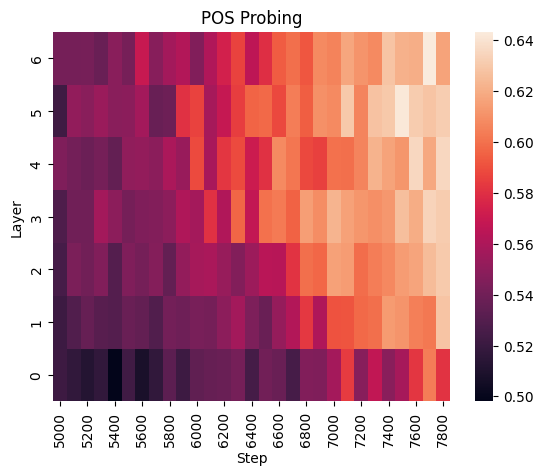

In [27]:
df = pd.read_csv('../../outputs/toy_model/old_params/zipf-layer_6-vs_10000-a_1.0001/pos_probing_results.csv')
df.index = df['Unnamed: 0']
df = df.drop('Unnamed: 0', axis=1)
ax = sns.heatmap(df, annot=False)

ax.set_xlabel("Step")
ax.set_ylabel("Layer")
ax.set_title("POS Probing")
plt.show()
# plt.savefig(os.path.join(output_dir, 'pos_probing_steps.png'))


In [4]:
pythia = AutoModel.from_pretrained('EleutherAI/pythia-160m')
bert = AutoModel.from_pretrained('google/multiberts-seed_0-step_0k')

#### Make Deterministic Plz

In [6]:
class Probe(nn.Module):
    def __init__(dset_gen, num_features: int):
        super().__init__()
        dset_gen.body = nn.Linear(num_features, 1, bias=False)

    def forward(dset_gen, x):
        if isinstance(x, list):
            x, _ = x
        return dset_gen.body(x)
        
def bin_step(model, batch):
    x, y = batch
    logits = model.forward(x)
    loss = F.binary_cross_entropy(torch.sigmoid(logits), y)
    acc = ((logits.squeeze() > 0.5).float() == y.squeeze()).float().mean()
    return loss, {"loss": loss.item(), "acc": acc.item()}

def bin_train_loop(model, train_dataloader, test_dataloader, optimizer, epochs):
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        pbar.set_description(f"Training Epoch {epoch}")
        for batch in train_dataloader:
            model.train()
            optimizer.zero_grad()
            loss, stats = bin_step(model, batch)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(**stats)
            
        model.eval()
        with torch.no_grad():
            pbar.set_description("Validation")
            results = bin_val_loop(model, test_dataloader)
    return results

def bin_val_loop(model, test_dataloader):
    model.eval()
    acc, losses = [], []
    with torch.no_grad():
        pbar = tqdm(test_dataloader)
        for val_batch in pbar:
            loss, stats = bin_step(model, val_batch)
            acc.append(stats["acc"])
            losses.append(stats["loss"])
            results = {"acc": np.mean(acc), "loss": np.mean(losses)}
            pbar.set_postfix(**results)
    return results

In [31]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)

## BERT VOCAB MODEL

### Task POS

In [32]:
num_pos_tokens = 100
assert num_pos_tokens % 2 == 0, "Has to be even"

special_token_dict_pos = {
    'cop': num_pos_tokens,
    'null': num_pos_tokens+1,
    'mask': num_pos_tokens+2
}
noun_tokens = range(num_pos_tokens//2)
adj_tokens = range(num_pos_tokens//2, num_pos_tokens)

def uniform(type='noun'):
    assert type in ['noun', 'adj'], "type not found"
    return random.choice(noun_tokens) if type == 'noun' else random.choice(adj_tokens)

def zipfian(type='noun', a=1.5):
    assert type in ['noun', 'adj'], "type not found"
    if type == 'noun':
        map = {k:v for k,v in zip(range(len(noun_tokens)), noun_tokens)}
    else:
        map = {k:v for k,v in zip(range(len(adj_tokens)), adj_tokens)}    
    value = np.random.zipf(a)
    while value not in map.keys():
        value = np.random.zipf(a)
    return map[value]

def create_dataset_task_pos(num_examples, mask_probability=0.15, masking='train', sample_func=zipfian):
    dataset = []
    labels = []
    alt_labels = []
    for _ in range(num_examples):
        rand_val = random.random()
        if rand_val < 0.40:
            noun = sample_func('noun')
            seq = [special_token_dict_pos['cop'], special_token_dict_pos['null'], noun]
            if rand_val < 0.20:
                adj = random.choice(adj_tokens)
                seq.extend([adj, special_token_dict_pos['null'], special_token_dict_pos['null'], special_token_dict_pos['null']])
            else:
                seq.extend([noun, special_token_dict_pos['null'], noun, noun])
            seq_alt = seq.copy()
              
        elif rand_val < 0.80: 
            noun = sample_func('noun')
            seq = [noun, special_token_dict_pos['cop'], special_token_dict_pos['null']]
            if rand_val < 0.60:
                adj = random.choice(adj_tokens)
                seq.extend([adj, special_token_dict_pos['null'], special_token_dict_pos['null'], special_token_dict_pos['null']])
            else:
                seq.extend([noun, special_token_dict_pos['null'], noun, noun])
            seq_alt = seq.copy()

        elif rand_val < 0.90: 
            adj, noun = sample_func('adj'), sample_func('noun')
            seq = [special_token_dict_pos['cop'], adj, noun]
            seq_alt = seq.copy()
            if rand_val < 0.85:
                seq.extend([adj, adj, adj, adj])
                seq_alt.extend([adj, special_token_dict_pos['null'], special_token_dict_pos['null'], special_token_dict_pos['null']])
            else:
                seq.extend([noun, adj, noun, noun])
                seq_alt.extend([noun, special_token_dict_pos['null'], noun, noun])
                
        else:
            adj, noun = sample_func('adj'), sample_func('noun')
            seq = [noun, special_token_dict_pos['cop'], adj]
            seq_alt = seq.copy()
            if rand_val < 0.95:
                seq.extend([adj, adj, adj, adj])
                seq_alt.extend([adj, special_token_dict_pos['null'], special_token_dict_pos['null'], special_token_dict_pos['null']])
            else:
                seq.extend([noun, adj, noun, noun])
                seq_alt.extend([noun, special_token_dict_pos['null'], noun, noun])

        label_seq = seq.copy()
        alt_labels_seq = seq_alt.copy()
        
        if masking=='train':
            for i in range(len(seq)):
                if random.random() < mask_probability:
                    seq[i] = special_token_dict_pos['mask']
                else:
                    label_seq[i] = -100 # ignore in loss fxn
                    alt_labels_seq[i] = -100
        else:
            for i in range(len(seq)):
                if i >= len(seq) - 3:
                    seq[i] = special_token_dict_pos['mask']
                else:
                    label_seq[i] = -100
                    alt_labels_seq[i] = -100
        dataset.append(seq)
        labels.append(label_seq)
        alt_labels.append(alt_labels_seq)

    return dataset, labels, alt_labels

In [33]:
ns1 = [zipfian('noun') for _ in range(1000)]

In [29]:
ns = [zipfian('noun') for _ in range(1000)]

(array([740.,  91.,  48.,  36.,  32.,  19.,  11.,  10.,   7.,   6.]),
 array([ 1. ,  5.7, 10.4, 15.1, 19.8, 24.5, 29.2, 33.9, 38.6, 43.3, 48. ]),
 <BarContainer object of 10 artists>)

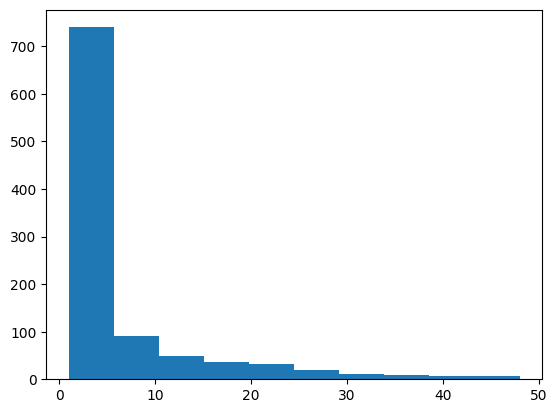

In [30]:
plt.hist(ns)

### Task DEP

In [9]:
special_token_dict_dep = {
    'mask': 400
}
seq_tokens = range(0, 400)
example_len = 20

## try + make harder 
## even smaller w the model

def generate_sequence(length, start_value, step_probability):
    sequence = [start_value]
    current_value = start_value

    for _ in range(length - 1):
        if random.random() < step_probability:
            # Change the value with the defined step change
            current_value += 1
        sequence.append(current_value)
    return sequence
    
def create_dataset_task_dep(num_examples, mask_probability=0.15, masking='train', elastic=True, step_prob = 0.90):
    assert example_len % 2 == 0, "example len must be even"
    seq_len = example_len // 2
    
    dataset = []
    labels = []
    alt_labels = []
    for _ in range(num_examples):
        rand_val = random.random()
        start_index = random.randint(0, len(seq_tokens) - seq_len)
        if elastic:
            seq = generate_sequence(seq_len, seq_tokens[start_index], step_prob) ## can have repeats
        else:
            seq = list(seq_tokens[start_index:start_index + seq_len])
        
        if rand_val < 0.80:
            seq *= 2
            seq_alt = seq.copy()
        else:
            if elastic: 
                change_ind = random.choice(range(2, seq_len+1))
                seq[-change_ind+1], seq[-change_ind] = seq[-change_ind], seq[-change_ind+1]
                seq *= 2
                seq_alt = seq.copy()
                seq[-change_ind+1] = seq[-change_ind]
            else:
                seq[-1], seq[-2] = seq[-2], seq[-1]
                seq *= 2
                seq_alt = seq.copy()
                seq[-1] = seq[-2]

        label_seq = seq.copy()
        alt_labels_seq = seq_alt.copy()
        
        if masking=='train':
            for i in range(len(seq)):
                if random.random() < mask_probability:
                    seq[i] = special_token_dict_dep['mask']
                else:
                    label_seq[i] = -100 # ignore in loss fxn
                    alt_labels_seq[i] = -100
        else:
            for i in range(len(seq)):
                if i >= len(seq) - seq_len:
                    seq[i] = special_token_dict_dep['mask']
                else:
                    label_seq[i] = -100
                    alt_labels_seq[i] = -100
        dataset.append(seq)
        labels.append(label_seq)
        alt_labels.append(alt_labels_seq)
        
    return dataset, labels, alt_labels

### Dataloader Helper

In [10]:
def create_dataloaders(num_train, num_val, device="cpu", task=create_dataset_task_pos):
    inputs_t, labels_t, alt_labels_t = task(num_train, mask_probability=0.15, masking='test')
    inputs_v, labels_v, alt_labels_v = task(num_val, mask_probability=0, masking='test')
    
    inputs_t = torch.tensor(inputs_t).to(device)
    labels_t = torch.tensor(labels_t).to(device)
    alt_labels_t = torch.tensor(alt_labels_t).to(device)
    inputs_v = torch.tensor(inputs_v).to(device)
    labels_v = torch.tensor(labels_v).to(device)
    alt_labels_v = torch.tensor(alt_labels_v).to(device)

    train_dataset = TensorDataset(inputs_t.detach(), labels_t, alt_labels_t)
    val_dataset = TensorDataset(inputs_v.detach(), labels_v, alt_labels_v)
    
    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)
    
    return train_dataloader, val_dataloader

def create_dataloaders_bin(data, labels, device="cpu"):
    train_len = int(0.80 * len(data))
    inputs_t, labels_t = data[:train_len], labels[:train_len]
    inputs_v, labels_v = data[train_len:], labels[train_len:]
    train_dataset = TensorDataset(inputs_t.detach(), labels_t.view(-1, 1))
    val_dataset = TensorDataset(inputs_v.detach(), labels_v.view(-1, 1))
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    return train_dataloader, val_dataloader


### Training BERT Helpers

In [11]:
def pca_pos(model, val_dataloader, title, c_step, probe_results=defaultdict(list)):
    labels, hidden_layers = [], defaultdict(list)
    model.config.output_hidden_states=True
    num_hidden_states = model.config.num_hidden_layers + 1
    fig, axs = plt.subplots(1, num_hidden_states, figsize=(5*num_hidden_states, 5))
    
    for batch in val_dataloader:
        examples, _, _ = batch
        labels.append((examples[:, -4] < 50).float())
        with torch.no_grad():
            outputs = model(examples.to(device))
        for j in range(num_hidden_states):
            hidden_layers[j].append(outputs.hidden_states[j][:, -4, :])
    
    labels = torch.concat(labels, axis=0).unsqueeze(1)
    for i in range(num_hidden_states):
        torch_embed = torch.concat(hidden_layers[i], axis=0).squeeze()
        probe = Probe(torch_embed.shape[1]).to(model.device)
        train_dataloader_bin, val_dataloader_bin = create_dataloaders_bin(torch_embed, labels, device=model.device)
        optim_bin = torch.optim.AdamW(probe.parameters(), lr=1e-3) 
        
        results = bin_train_loop(probe, train_dataloader_bin, val_dataloader_bin, optim_bin, 3)
        probe_results[i].append(results['acc'])

        labels_numpy = labels.cpu().numpy().squeeze()
        np_embed = torch_embed.cpu().numpy()
        
        pca = PCA(n_components=2)
        data_pca = pca.fit_transform(np_embed)
        
        unique_labels = np.unique(labels_numpy)
        colors = plt.cm.get_cmap('viridis', len(unique_labels))
        
        for j, label in enumerate(unique_labels):
            axs[i].scatter(data_pca[labels_numpy == label, 0], data_pca[labels_numpy == label, 1], 
                        alpha=0.5, color=colors(j), label=f"Label {label}")
        
        axs[i].set_title(f"state {i} acc={results['acc']:0.2f}")
        axs[i].set_xlabel("Principal Component 1")
        axs[i].set_ylabel("Principal Component 2")
        axs[i].legend()
        axs[i].grid(True)
                
    plt.suptitle(title)
    # plt.savefig(f'images/pca_step_{c_step}.png')
    # plt.show()
    plt.close()
    
    return probe_results

In [12]:
def step(model, batch, hard_acc=False):
    x, y, alt_y = batch
    output = model.forward(x)
    logits = output.logits.transpose(1, 2)
    loss = criterion(logits, y)
    batch_len = logits.shape[0]

    where = (y != -100)
    y, alt_y = y[where].view(batch_len, -1), alt_y[where].view(batch_len, -1)
    
    preds = logits.argmax(axis=1)[where].view(batch_len, -1)
    
    ## full examples where alt != alt_label
    batch_same = (y == alt_y).all(axis=-1)
    if hard_acc:
        acc = (preds == y).all(axis=-1).float().mean() 
        alt_acc = (preds == alt_y).all(axis=-1).float().mean()
    else:
        acc = (preds == y)[~batch_same].float().mean() 
        alt_acc = (preds == alt_y)[~batch_same].float().mean()
    
    return loss, {"loss": loss.item(), "acc": acc.item(), "alt_acc": alt_acc.item()}

def train_loop(model, train_dataloader, test_dataloader, optimizer, epochs, step_eval=1000, name=None, pca=True):
    pbar = tqdm(range(epochs))
    val_stats = {}
    hist = {}
    c_step = 0
    probe_results = defaultdict(list)
    for epoch in pbar:
        pbar.set_description(f"Training Epoch {epoch}")
        for batch in train_dataloader:
            c_step += 1
            model.train()
            optimizer.zero_grad()
            loss, stats = step(model, batch, hard_acc=True)
            loss.backward()
            optimizer.step()
            stats.update(val_stats)
            pbar.set_postfix(**stats)
            if isinstance(step_eval, int):
                if c_step % step_eval == 0:
                    hist[c_step] = val_loop(model, test_dataloader)
                    if pca:
                        probe_results = pca_pos(model, test_dataloader, f'Step {c_step}', c_step, probe_results)
                    if name is not None:
                        torch.save(model.state_dict(), f'models/{name}_step_{c_step}.pth')
            elif isinstance(step_eval, list):
                if c_step in step_eval:
                    hist[c_step] = val_loop(model, test_dataloader)
                    if pca:
                        probe_results = pca_pos(model, test_dataloader, f'Step {c_step}', c_step, probe_results)
                    if name is not None:
                        torch.save(model.state_dict(), f'models/{name}_step_{c_step}.pth')
            else:
                raise ValueError('Not recognized format for step')
                
                
        model.eval()
        with torch.no_grad():
            pbar.set_description("Validation")
            val_stats = val_loop(model, test_dataloader)
            val_stats = {"val_" + key:val for key,val in val_stats.items()}
            pbar.set_postfix(**val_stats)
    return hist, probe_results
                
def val_loop(model, test_dataloader):
    model.eval()
    acc, acc_alt, losses = [], [], []
    with torch.no_grad():
        pbar = tqdm(test_dataloader)
        for val_batch in pbar:
            loss, stats = step(model, val_batch, hard_acc=True)
            acc.append(stats["acc"])
            acc_alt.append(stats["alt_acc"])
            losses.append(stats["loss"])
            results = {"acc": np.mean(acc), "alt_acc": np.mean(acc_alt), "loss": np.mean(losses)}
            pbar.set_postfix(**results)
    return results

### POS Experiment

In [14]:
num_epochs = 1
device = "cuda:0" if torch.cuda.is_available() else "cpu"
task=create_dataset_task_pos

In [15]:
config = BertConfig(
    vocab_size=103 if task==create_dataset_task_pos else 401,
    hidden_size=16, # 128  
    num_hidden_layers=8,  
    num_attention_heads=2, # 8
    intermediate_size=32 # 512
)
toy_bert_model = BertForMaskedLM(config).to(device)
optimizer = torch.optim.AdamW(toy_bert_model.parameters(), lr=5e-5) 
criterion = nn.CrossEntropyLoss()

In [16]:
max_num_steps = 1_000_000 * 5 /128

In [17]:
train_dataloader, val_dataloader = create_dataloaders(10_000, 10_000, device=device, task=task)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

{'acc': 0.0, 'alt_acc': 0.0, 'loss': 4.422953032240083}


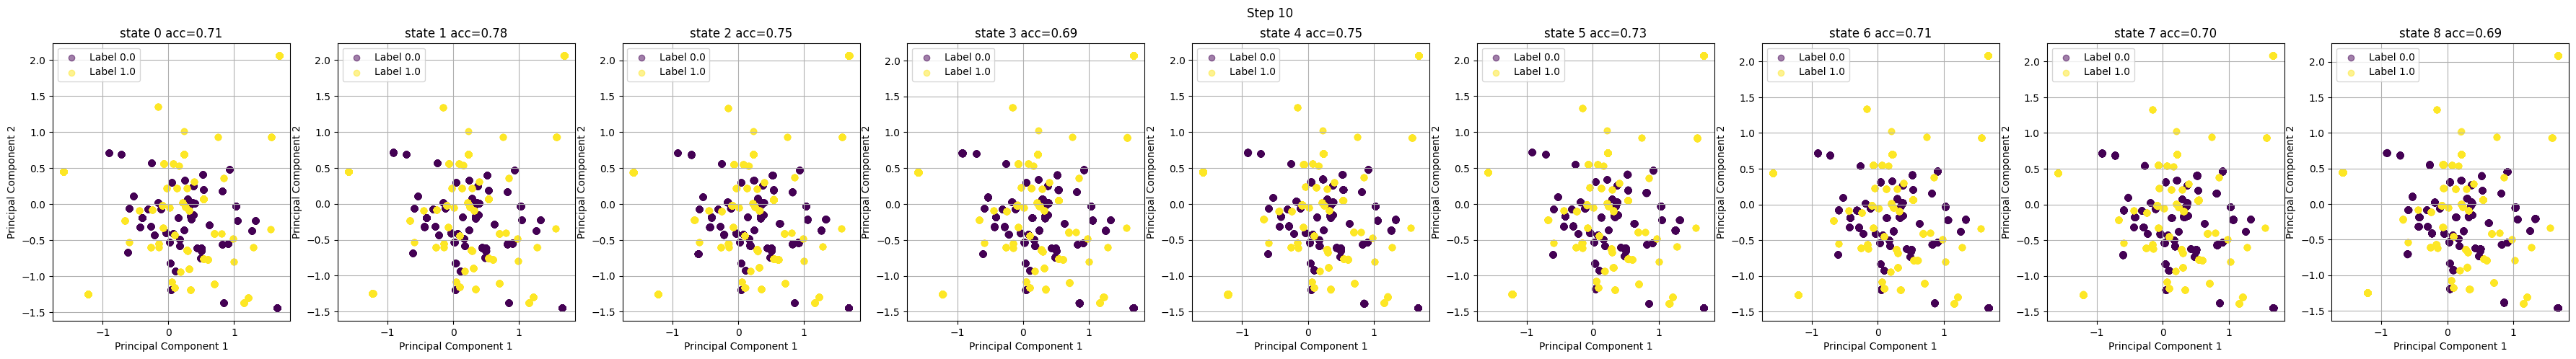

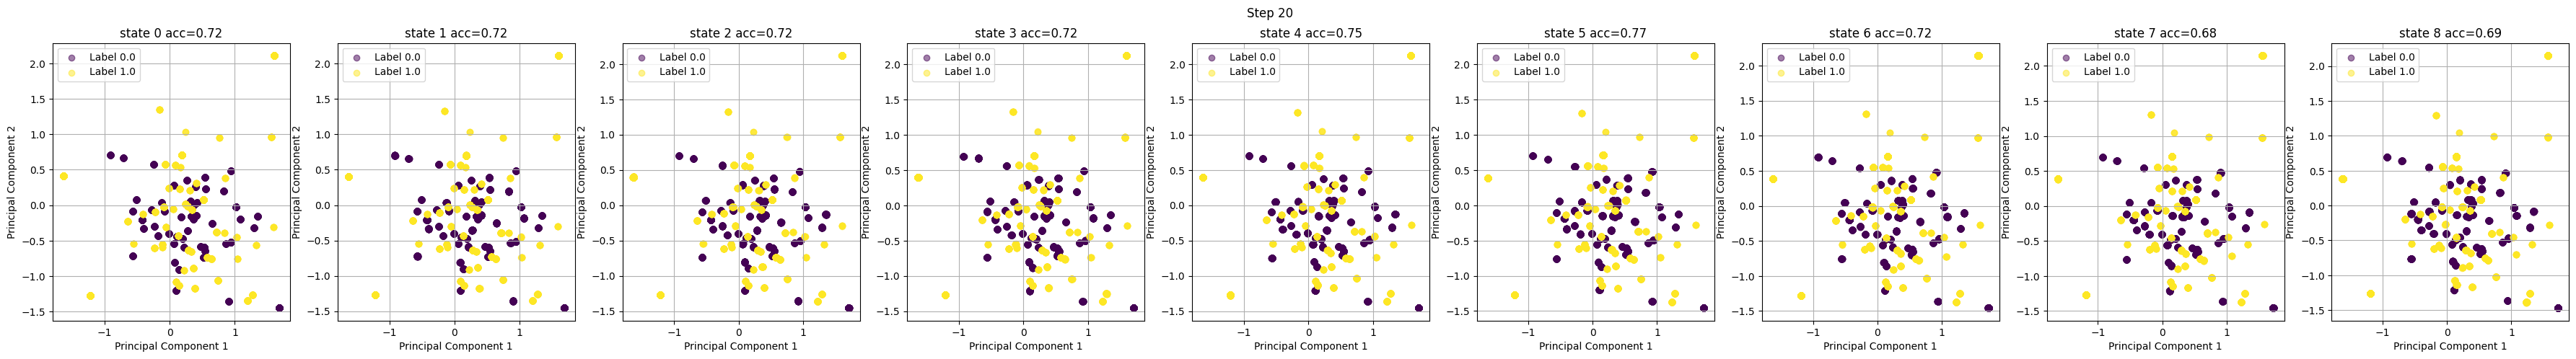

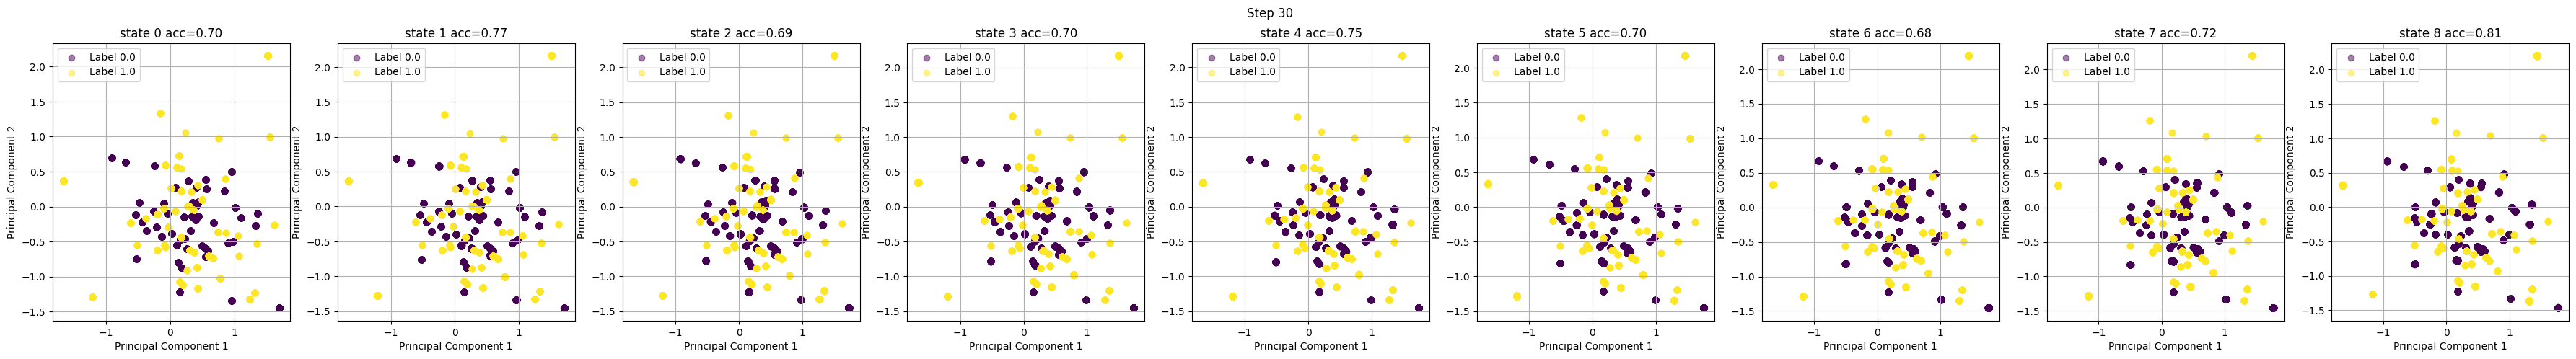

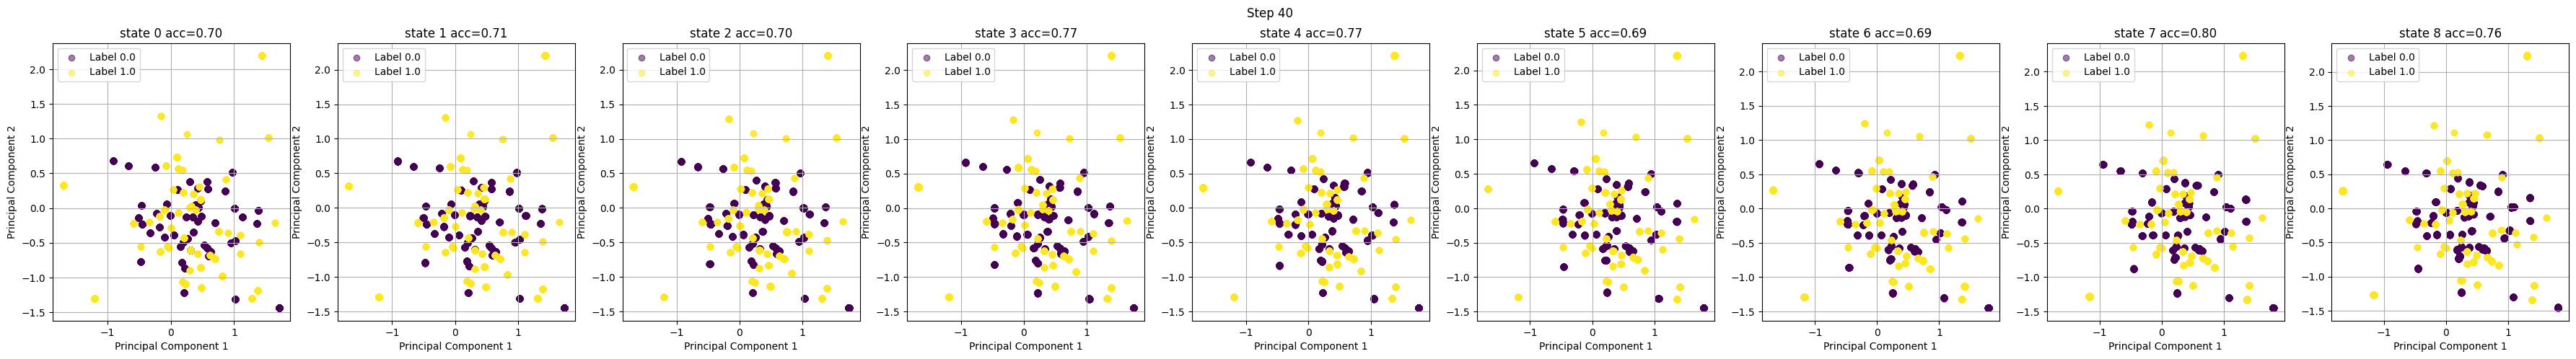

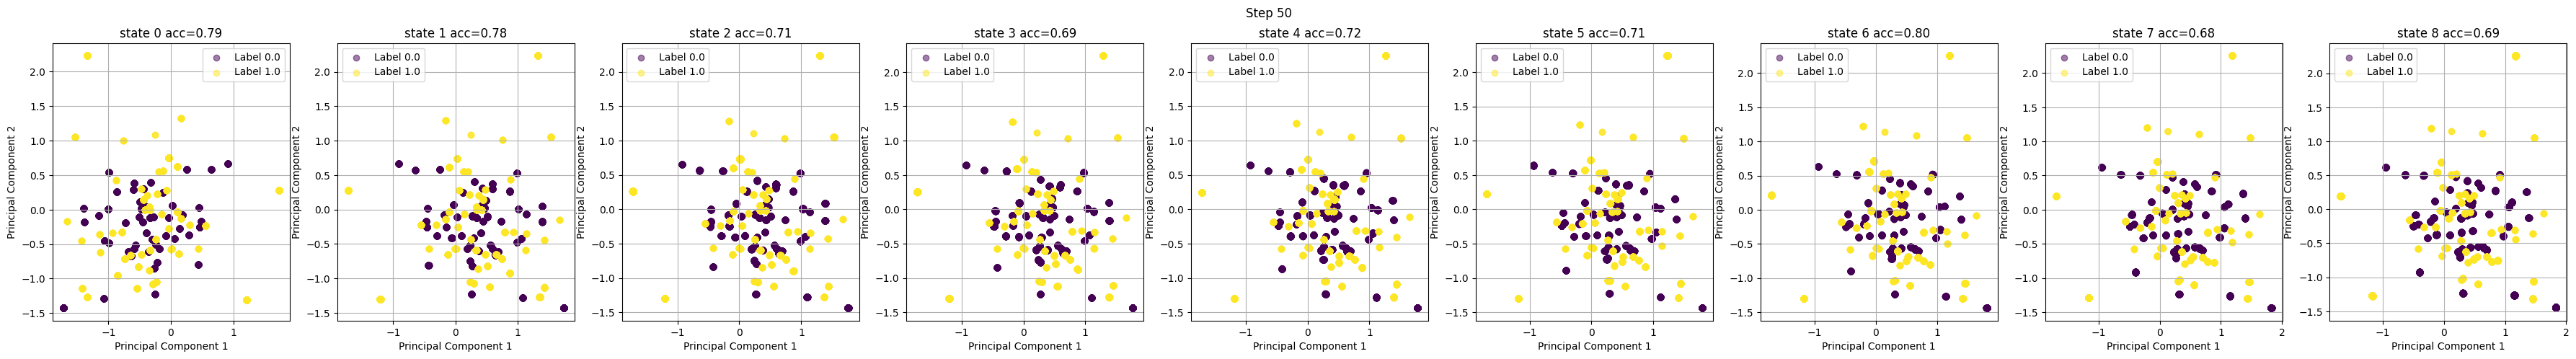

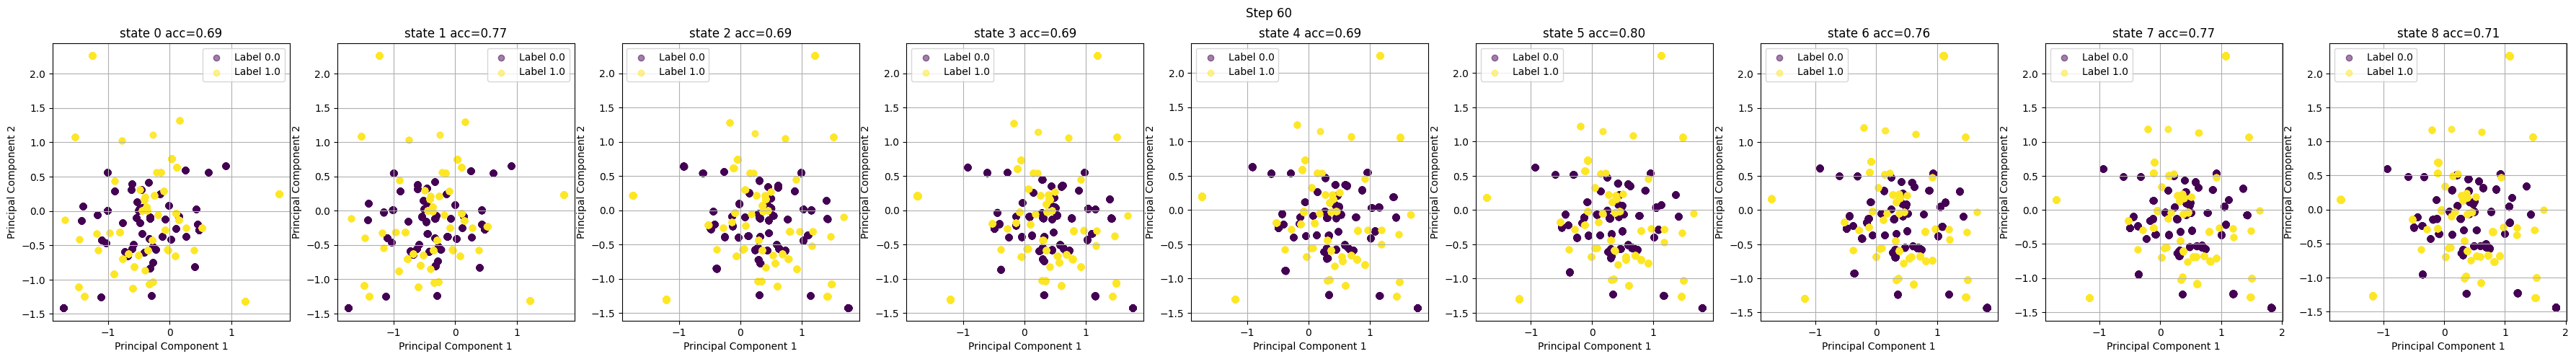

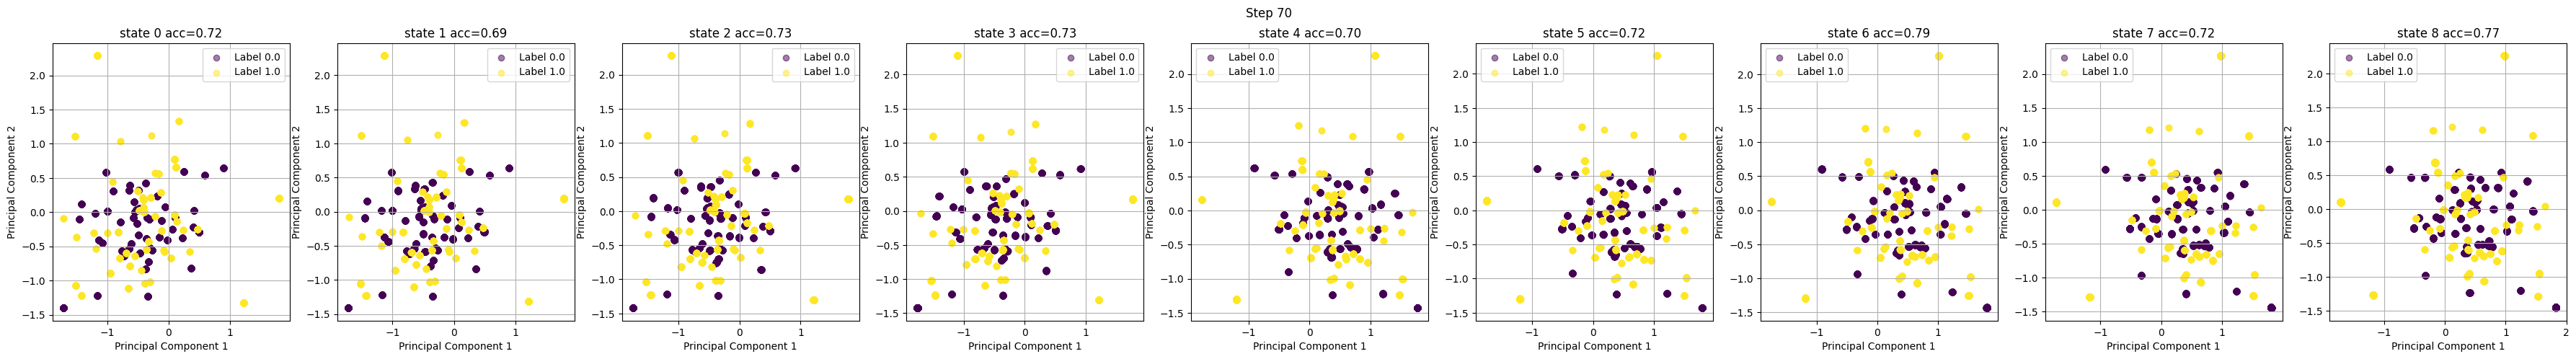

In [18]:
#step_eval = [10, 100, 200, 400, 800, 1000, 2000, 4000, 10000, 38000, 70000]
step_eval = list(range(0, 1000, 10))
hist, probing_results = train_loop(toy_bert_model, train_dataloader, val_dataloader, 
                                   optimizer, num_epochs, 
                                   step_eval=step_eval, name=None)#'pos_model')
val_stats = val_loop(toy_bert_model, val_dataloader)
print(val_stats) # 10 - 80 identical, 10 - 20 1 token 
## make accuracy measurement an all

## pos looks like it is doing alt first actually
## between 4 and 5 epochs looks like strategy changes

In [23]:
df = pd.DataFrame(probing_results)
df = df.transpose()
df.columns = step_eval[:len(df)-2]

df = df[::-1]

In [28]:
pd.DataFrame(hist)

10        20        30        40       50        60        70
acc      0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000
alt_acc  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000
loss     4.593277  4.563362  4.534465  4.507429  4.48288  4.460462  4.440004

In [ ]:
df = pd.DataFrame(probing_results)
df = df.transpose()
df.columns = step_eval[:-1]

df = df[::-1]

ax = sns.heatmap(df, annot=False)

ax.set_xlabel("Step")
ax.set_ylabel("Layer")
ax.set_title("POS Probing")
plt.savefig('pos_probing_1000steps.png')

plt.show()


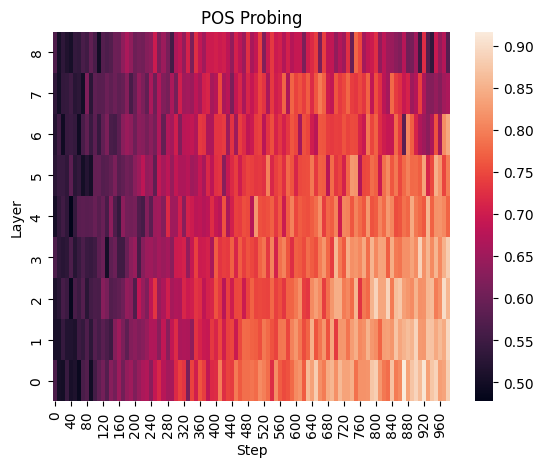

In [66]:
df = pd.DataFrame(probing_results)
df = df.transpose()
df.columns = step_eval[:-1]

df = df[::-1]

ax = sns.heatmap(df, annot=False)

ax.set_xlabel("Step")
ax.set_ylabel("Layer")
ax.set_title("POS Probing")
plt.savefig('pos_probing_1000steps.png')

plt.show()


In [64]:
def sort_key(filename):
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else 0
    
folder_path = '2-layer/images'
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
image_files.sort(key=sort_key)
fig, axs = plt.subplots(len(image_files), 1, figsize=(10, len(image_files) * 5))

if not isinstance(axs, np.ndarray):
    axs = [axs]

for ax, img_file in zip(axs, image_files):
    img_path = os.path.join(folder_path, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off') 

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '2-layer/images'

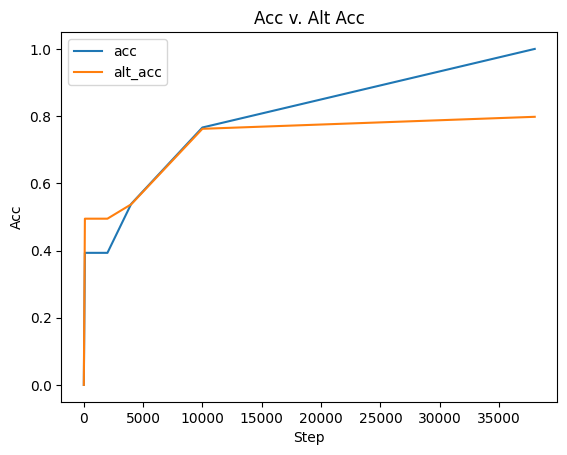

In [44]:
df_hist = pd.DataFrame(hist)
df_hist.transpose().drop('loss', axis=1).plot(kind='line')

plt.xlabel('Step')
plt.ylabel('Acc')
plt.title('Acc v. Alt Acc')
plt.show()


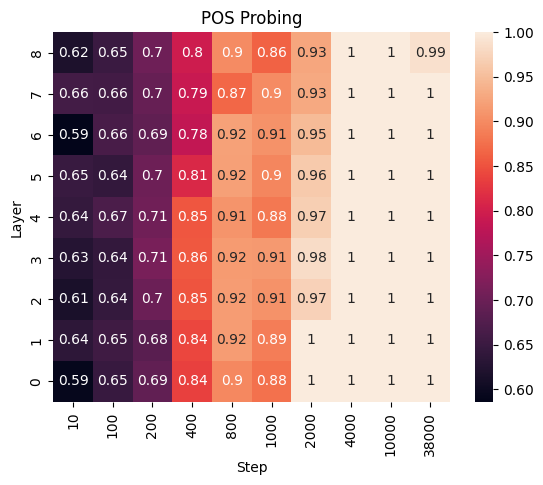

In [45]:
df = pd.DataFrame(probing_results)
df = df.transpose()
df.columns = step_eval[:-1]

df = df[::-1]

ax = sns.heatmap(df, annot=True)

ax.set_xlabel("Step")
ax.set_ylabel("Layer")
ax.set_title("POS Probing")
plt.savefig('pos_probing.png')

plt.show()


RESULTS 2 LAYER

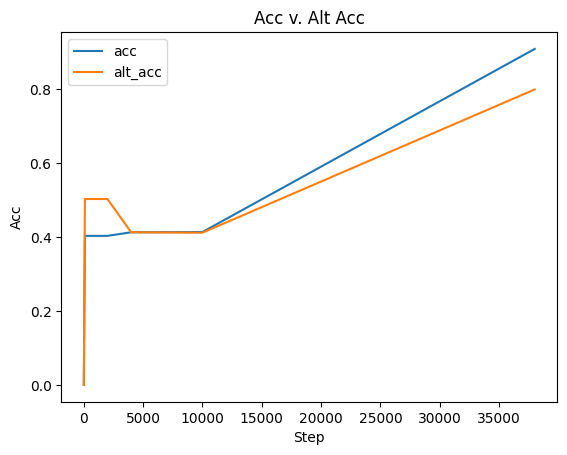

In [22]:
df_hist = pd.DataFrame(hist)
df_hist.transpose().drop('loss', axis=1).plot(kind='line')

plt.xlabel('Step')
plt.ylabel('Acc')
plt.title('Acc v. Alt Acc')
plt.show()


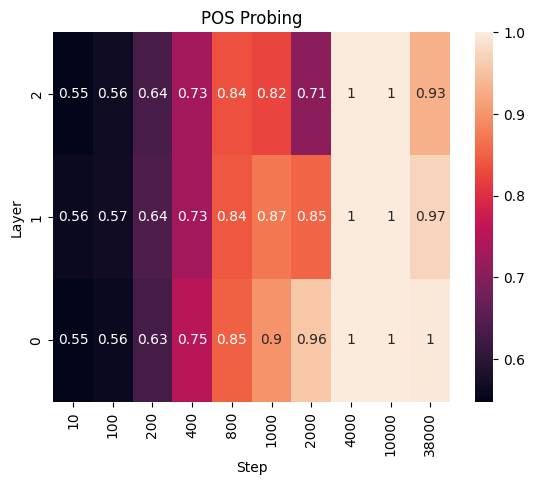

In [27]:
df = pd.DataFrame(probing_results)
df = df.transpose()
df.columns = step_eval[:-1]

df = df[::-1]

ax = sns.heatmap(df, annot=True)

ax.set_xlabel("Step")
ax.set_ylabel("Layer")
ax.set_title("POS Probing")
plt.savefig('pos_probing.png')

plt.show()


| Metric   | One Hidden Layers | Two Hidden Layers | Three Hidden Layers |
|----------|-------------------|-------------------|---------------------|
| acc      |     0.09462       | 0.09734           | 0.00019             |
| alt_acc  |     0.093527      | 0.09136           | 0.00021             |
| loss     |     0.17726       | 0.07501           | 5.99352             |


In [29]:
# dset = val_dataloader.dataset
# for i in range(100):
#     example, label, alt_label = dset.tensors[0][i], dset.tensors[1][i], dset.tensors[2][i]
#     if not torch.all(label == alt_label):
#         where = (label != -100)
#         print("PREDICTION", toy_bert_model(example.unsqueeze(dim=0)).logits.transpose(1, 2).argmax(axis=1)[where.unsqueeze(0)])
#         print("ALT_LABEL", alt_label[where])
#         print("LABEL", label[where])
#         print()

### DEP Experiment

In [30]:
num_epochs = 10
device = "cuda:0" if torch.cuda.is_available() else "cpu"
task=create_dataset_task_dep

In [31]:
config = BertConfig(
    vocab_size=103 if task==create_dataset_task_pos else 401,
    hidden_size=16, # 128  
    num_hidden_layers=2,  
    num_attention_heads=2, # 8
    intermediate_size=32 # 512
)
toy_bert_model = BertForMaskedLM(config).to(device)
optimizer = torch.optim.AdamW(toy_bert_model.parameters(), lr=5e-5) 
criterion = nn.CrossEntropyLoss()

In [32]:
max_num_steps = 1_000_000 * 5 /128

In [33]:
train_dataloader, val_dataloader = create_dataloaders(1_000_000, 10_000, device=device, task=task)

In [34]:
step_eval = [10, 100, 200, 400, 800, 1000, 2000, 4000, 10000, 38000, 70000]
hist, probing_results = train_loop(toy_bert_model, train_dataloader, val_dataloader, optimizer, num_epochs, step_eval=step_eval, name='dep_model', pca=False)
val_stats = val_loop(toy_bert_model, val_dataloader)
print(val_stats) # 10 - 80 identical, 10 - 20 1 token 
## make accuracy measurement an all

## pos looks like it is doing alt first actually
## between 4 and 5 epochs looks like strategy changes

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

{'acc': 0.5743670886075949, 'alt_acc': 0.5581487341772152, 'loss': 0.8008955264393287}


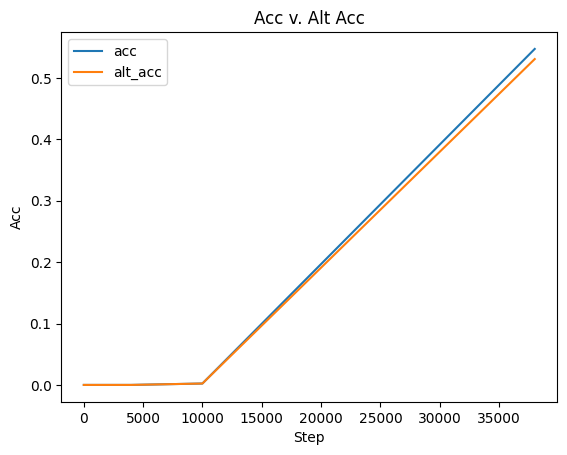

In [35]:
df_hist = pd.DataFrame(hist)
df_hist.transpose().drop('loss', axis=1).plot(kind='line')

plt.xlabel('Step')
plt.ylabel('Acc')
plt.title('Acc v. Alt Acc')
plt.show()

* Trained too few epochs but trend just continues (i.e. never adopts/gets better at alternative strategy)

* Don't know why can't get about 0.429 accuracy
* Tried increasing model width, model num hidden layers, and dataset size
* Alternative strategy accuracy looks better at only very beginning (almost no matter size)

## TOY MODEL

Notes:

1. Residual Connection is not cause
2. Happens with 2 layer (1 interm, head) as well, but separation slightly less present
3. Does not happen when freeze layer 1 in 2 layer (random projection hypothesis)
4. Does not happen when freeze layer 1 in 3 layer (2 interm w/ resid, head) -- figure out why not difference + check layer 2
5. What is happening is not pushback, but rather choosing of a strategy (i.e. fully separable l1 after pt, then simply uses that)

Other Notes:
1. Reducing std hurts, not helps final task (idk why)

In [99]:
class ToyModel(nn.Module):
    def __init__(dset_gen, num_features: int, num_interm : int):
        super().__init__()
        dset_gen.fc1 = nn.Linear(num_features, num_interm)
        # Second fully connected layer
        dset_gen.relu1 = nn.ReLU()
        dset_gen.fc2 = nn.Linear(num_interm, num_interm)
        dset_gen.relu2 = nn.ReLU()
        # dset_gen.fc3 = nn.Linear(num_interm, num_interm)
        # dset_gen.relu3 = nn.ReLU()
        dset_gen.head = nn.Linear(num_interm, 1, bias=False)

    def forward(dset_gen, x):
        if isinstance(x, list):
            x, _ = x
        out = dset_gen.relu1(dset_gen.fc1(x))
        out = dset_gen.relu2(dset_gen.fc2(out)) + out
        # out = dset_gen.relu3(dset_gen.fc3(out)) + out
        return dset_gen.head(out) 

* Train on disambiguated data to detect mean m1
* Train on ambiguated data to detect whole task
* Check whether inetermediate layer data is split by mean m1

### Gen Data Func

In [39]:
## generation hyperparameters

size = 10000
m1, m2, m3, m4 = 0, 0, 2, 3
s1, s2, s3, s4 = 1, 1, 1, 1 ## 1, 1, 1, 1 - dec to 0.2
N, N_p, N_pp = 0, 2, 3
vec_size = 16 ## was 4

heuristic=0.75


In [40]:
def generate_gaussian_inputs(m1, s1, m2, s2, m3, s3, m4, s4, vec_size, N, N_p, N_pp, init_task=True, disamb=0.5, heuristic=None):
    f1 = torch.normal(mean=torch.tensor(m1).repeat((1, vec_size)).float(), std=s1)
    f2 = torch.normal(mean=torch.tensor(m2).repeat((1, vec_size)).float(), std=s2)
    f3 = torch.normal(mean=torch.tensor(m3).repeat((1, vec_size)).float(), std=s3)
    f4 = torch.normal(mean=torch.tensor(m4).repeat((1, vec_size)).float(), std=s4)
    f1_gt_N = (torch.mean(f1) > N)
    f2_gt_N = (torch.mean(f2) > N)
    if random.random() < disamb: ## f1 > N != f2 > N (i.e. ambiguous)
        while f1_gt_N == f2_gt_N:
            f1 = torch.normal(mean=torch.tensor(m1).repeat((1, vec_size)).float(), std=s1)
            f2 = torch.normal(mean=torch.tensor(m2).repeat((1, vec_size)).float(), std=s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
    else: ## f1 > N == f2 > N (i.e. ambiguous)
        while f1_gt_N != f2_gt_N:
            f1 = torch.normal(mean=torch.tensor(m1).repeat((1, vec_size)).float(), std=s1)
            f2 = torch.normal(mean=torch.tensor(m2).repeat((1, vec_size)).float(), std=s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
            
    if heuristic is not None:
        label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        if random.random() < heuristic:
            while f1_gt_N != label:
                f3 = torch.normal(mean=torch.tensor(m3).repeat((1, vec_size)).float(), std=s3)
                f4 = torch.normal(mean=torch.tensor(m4).repeat((1, vec_size)).float(), std=s4)
                label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        else:
            while f1_gt_N == label:
                f3 = torch.normal(mean=torch.tensor(m3).repeat((1, vec_size)).float(), std=s3)
                f4 = torch.normal(mean=torch.tensor(m4).repeat((1, vec_size)).float(), std=s4)
                label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
                
    full = torch.concat([f1, f2, f3, f4], dim=1) 
    if init_task:
        label = f1_gt_N
        alt_label = f2_gt_N
    else:
        label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        alt_label = (torch.mean(f3) > N_p) if f2_gt_N else (torch.mean(f4) > N_pp) 
    return full, label, alt_label

In [41]:
def mixture(m_a, m_b, s=0.2): 
    if random.random() > 0.5: 
        return torch.normal(mean=torch.tensor(m_a).repeat((1, vec_size)).float(), std=s)
    else: 
        return torch.normal(mean=torch.tensor(m_b).repeat((1, vec_size)).float(), std=s)
        
def generate_gaussian_mixture_inputs_w_heur(m1, s1, m2, s2, m3, s3, m4, s4, vec_size, N, N_p, N_pp, init_task=True, disamb=0.5, heuristic=None):
    f1 = mixture(m1 - 1, m1 + 1, s1)
    f2 = mixture(m2 - 1, m2 + 1, s2)
    f3 = mixture(m3 - 1, m3 + 1, s3)
    f4 = mixture(m4 - 1, m4 + 1, s4)
    f1_gt_N = (torch.mean(f1) > N)
    f2_gt_N = (torch.mean(f2) > N)
    if random.random() < disamb: ## f1 > N != f2 > N (i.e. ambiguous)
        while f1_gt_N == f2_gt_N:
            f1 = mixture(m1 - 1, m1 + 1, s1)
            f2 = mixture(m2 - 1, m2 + 1, s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
    else: ## f1 > N == f2 > N (i.e. ambiguous)
        while f1_gt_N != f2_gt_N:
            f1 = mixture(m1 - 1, m1 + 1, s1)
            f2 = mixture(m2 - 1, m2 + 1, s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
    if heuristic is not None:
        label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        if random.random() < heuristic:
            while f1_gt_N != label:
                f3 = mixture(m3 - 1, m3 + 1, s3)
                f4 = mixture(m4 - 1, m4 + 1, s4)
                label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        else:
            while f1_gt_N == label:
                f3 = mixture(m3 - 1, m3 + 1, s3)
                f4 = mixture(m4 - 1, m4 + 1, s4)
                label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
                
    full = torch.concat([f1, f2, f3, f4], dim=1) 
    if init_task:
        label = f1_gt_N
        alt_label = f2_gt_N
    else:
        label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        alt_label = (torch.mean(f3) > N_p) if f2_gt_N else (torch.mean(f4) > N_pp)
    return full, label, alt_label

In [42]:
def create_dataset(init_task, disamb, size=size, heuristic=None):
    inputs = []
    labels = []
    alt_labels = []
    
    for i in tqdm(range(size)):
        input, label, alt_label = generate_gaussian_inputs(m1, s1, m2, s2, m3, s3, m4, s4, 
                                                                          vec_size, N, N_p, N_pp, 
                                                                          init_task=init_task, disamb=disamb, heuristic=heuristic)
        inputs.append(input)
        labels.append(label)
        alt_labels.append(alt_label)
        
    inputs = torch.vstack(inputs)
    labels = torch.vstack(labels).float()
    alt_labels = torch.vstack(alt_labels).float()
    
    train_size = int(0.8 * len(inputs))
    
    inputs_t, labels_t, alt_labels_t = inputs[:train_size], labels[:train_size], alt_labels[:train_size]
    inputs_v, labels_v, alt_labels_v = inputs[train_size:], labels[train_size:], alt_labels[train_size:]

    train_dataset = TensorDataset(inputs_t.detach(), labels_t.view(-1, 1))
    val_dataset = TensorDataset(inputs_v.detach(), labels_v.view(-1, 1))

    train_dataset_alt = TensorDataset(inputs_t.detach(), alt_labels_t.view(-1, 1))
    val_dataset_alt = TensorDataset(inputs_v.detach(), alt_labels_v.view(-1, 1))

    return train_dataset, val_dataset, train_dataset_alt, val_dataset_alt

### Model Params/Functions

In [44]:
## model params/hyperparams

epochs = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
interm_size = 128 ## was 128

In [45]:
def step(model, batch):
    x, y = batch
    logits = model.forward(x)
    loss = F.binary_cross_entropy(torch.sigmoid(logits), y)
    acc = ((logits.squeeze() > 0.5).float() == y.squeeze()).float().mean()
    return loss, {"loss": loss.item(), "acc": acc.item()}

def train_loop(model, train_dataloader, test_dataloader, optimizer, epochs):
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        pbar.set_description(f"Training Epoch {epoch}")
        for batch in train_dataloader:
            model.train()
            optimizer.zero_grad()
            loss, stats = step(model, batch)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(**stats)

        model.eval()
        with torch.no_grad():
            pbar.set_description("Validation")
            for val_batch in test_dataloader:
                loss, stats = step(model, val_batch)
                pbar.set_postfix(**stats)
                
def val_loop(model, test_dataloader):
    model.eval()
    acc, losses = [], []
    with torch.no_grad():
        for val_batch in tqdm(test_dataloader):
            loss, stats = step(model, val_batch)
            acc.append(stats["acc"])
            losses.append(stats["loss"])
    return np.mean(acc), np.mean(losses)

In [46]:
def plot_pcas(interm_train, labels_train, alt_labels_train, title="biased"):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    disamb_learn_numpy = interm_train.detach().numpy()
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(disamb_learn_numpy)
    
    for i, labels_curr in enumerate([labels_train, alt_labels_train]):
        labels_numpy = labels_curr.squeeze()
        unique_labels = np.unique(labels_numpy)
        colors = plt.cm.get_cmap('viridis', len(unique_labels))
        
        for j, label in enumerate(unique_labels):
            axs[i].scatter(data_pca[labels_numpy == label, 0], data_pca[labels_numpy == label, 1], 
                        alpha=0.5, color=colors(j), label=f"Label {label}")
        
        axs[i].set_title(f"Separation of mean(f{i+1}) > N")
        axs[i].set_xlabel("Principal Component 1")
        axs[i].set_ylabel("Principal Component 2")
        axs[i].legend()
        axs[i].grid(True)

    plt.suptitle(title)
    plt.show()

In [47]:
heuristic=None

In [48]:
toy_model = ToyModel(4*vec_size, interm_size)

# for param in toy_model.fc1.parameters():
#     param.requires_grad = False

# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, toy_model.parameters()), lr=0.001)
optimizer = torch.optim.Adam(toy_model.parameters(), lr=0.001)

### Task 1: Learn mean(f1) > N on disambiguated data 

disambiguated = where mean(f2) > N is the same label with p=0.5

In [49]:
def task1(toy_model, optimizer, epochs, heuristic):
    train_dataset, val_dataset, _, _ = create_dataset(init_task=True, disamb=0.5, size=10000, heuristic=heuristic)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

    train_loop(toy_model, train_dataloader, val_dataloader, optimizer, epochs)
    acc, loss = val_loop(toy_model, val_dataloader)
    print(f"ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")
    
task1(toy_model, optimizer, epochs, heuristic)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

ACCURACY: 0.97, LOSS: 0.05


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_1297575/3323052680.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


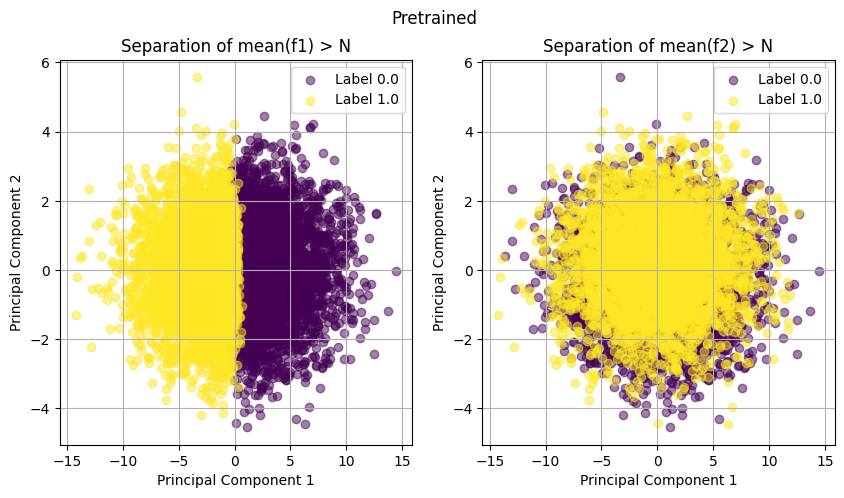

In [50]:
layer1_biased = toy_model.fc1
# layer2_biased = lambda x: toy_model.fc2(toy_model.relu1(toy_model.fc1(x))) + toy_model.fc1(x)

train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=True, disamb=0.5)
labels_train, labels_val = train_dataset.tensors[1], val_dataset.tensors[1]
alt_labels_train, alt_labels_val = alt_train_dataset.tensors[1], alt_val_dataset.tensors[1]

# interm_train_biased, interm_val_biased = layer2_biased(train_dataset.tensors[0]), layer2_biased(val_dataset.tensors[0])
# plot_pcas(interm_train_biased, labels_train, alt_labels_train, title="Pretrained")

interm_train_biased, interm_val_biased = layer1_biased(train_dataset.tensors[0]), layer1_biased(val_dataset.tensors[0])
plot_pcas(interm_train_biased, labels_train, alt_labels_train, title="Pretrained")


### Task 2: Learn mean(f3) > N' if mean(f1) > N else mean(f4) > N'' on ambiguated data 

ambiguated = where mean(f2) > N is the same label with p=0.98

In [51]:
for param in toy_model.fc1.parameters():
    param.requires_grad = True

# new_params = [p for p in toy_model.fc1.parameters() if p.requires_grad]
# optimizer.add_param_group({'params': new_params})

In [61]:
toy_model_new = ToyModel(4*vec_size, interm_size) ## ab 75-80% baseline
optimizer_new = torch.optim.Adam(toy_model_new.parameters(), lr=0.001)
epochs=5

In [62]:
def task2(toy_model, optimizer, epochs, heuristic):
    train_dataset, val_dataset, _, _ = create_dataset(init_task=False, disamb=0.50, heuristic=heuristic)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    train_loop(toy_model, train_dataloader, val_dataloader, optimizer, epochs)
    acc, loss = val_loop(toy_model, val_dataloader)
    print(f"ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

task2(toy_model, optimizer, epochs, heuristic)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

ACCURACY: 0.81, LOSS: 0.42


In [63]:
task2(toy_model_new, optimizer_new, epochs, heuristic=heuristic)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

ACCURACY: 0.74, LOSS: 0.53


### Check: whether intermediate data is better at mean(f1) > N or mean(f2) > N on disambiguated data

In [64]:
train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=False, disamb=1, heuristic=heuristic)

label_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
alt_label_dataloader = DataLoader(alt_val_dataset, batch_size=32, shuffle=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [65]:
acc, loss = val_loop(toy_model, label_dataloader)
print(f"F1 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")
acc, loss = val_loop(toy_model, alt_label_dataloader)
print(f"F2 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

  0%|          | 0/63 [00:00<?, ?it/s]

F1 LABELS ACCURACY: 0.81, LOSS: 0.42


  0%|          | 0/63 [00:00<?, ?it/s]

F2 LABELS ACCURACY: 0.43, LOSS: 1.48


In [66]:
acc, loss = val_loop(toy_model_new, label_dataloader)
print(f"F1 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")
acc, loss = val_loop(toy_model_new, alt_label_dataloader)
print(f"F2 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

  0%|          | 0/63 [00:00<?, ?it/s]

F1 LABELS ACCURACY: 0.73, LOSS: 0.53


  0%|          | 0/63 [00:00<?, ?it/s]

F2 LABELS ACCURACY: 0.49, LOSS: 1.05


In [25]:
layer1_biased = toy_model.fc1
# layer2_biased = lambda x: toy_model.fc2(toy_model.relu1(toy_model.fc1(x))) + toy_model.fc1(x)
layer1_control = toy_model_new.fc1
# layer2_control = lambda x: toy_model_new.fc2(toy_model_new.relu1(toy_model_new.fc1(x))) + toy_model_new.fc1(x)

train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=True, disamb=0.5)
labels_train, labels_val = train_dataset.tensors[1], val_dataset.tensors[1]
alt_labels_train, alt_labels_val = alt_train_dataset.tensors[1], alt_val_dataset.tensors[1]
## need to be ambiguous be maximally random

  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_1297575/3323052680.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


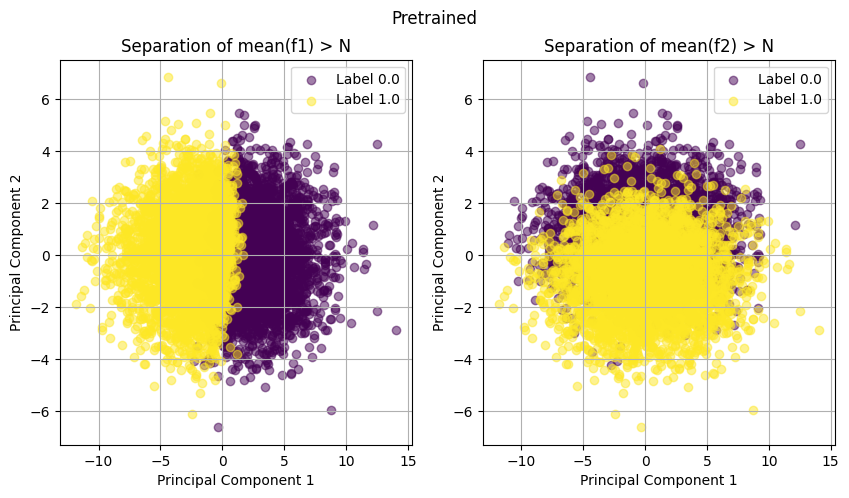

/tmp/ipykernel_1297575/3323052680.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


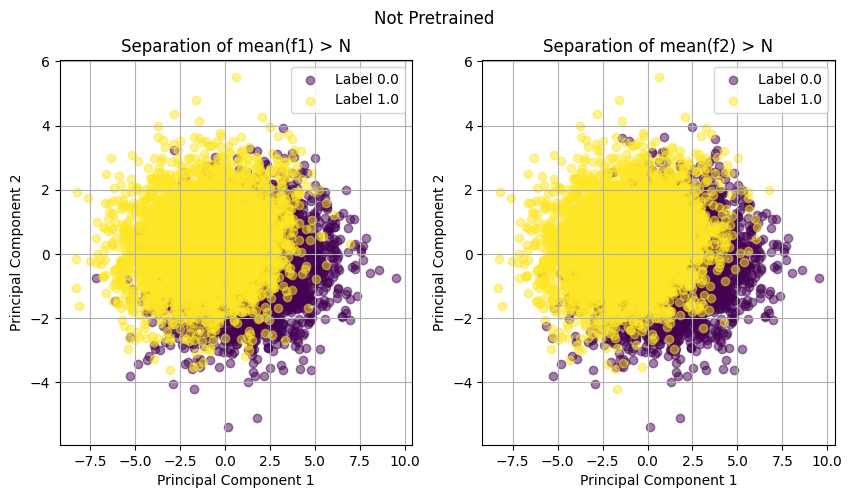

In [26]:
def layer_num_pca(layer_num):
    interm_train_biased, interm_val = eval(f'layer{layer_num}_biased(train_dataset.tensors[0]), layer{layer_num}_biased(val_dataset.tensors[0])')
    plot_pcas(interm_train_biased, labels_train, alt_labels_train, title="Pretrained")

    interm_train_control, interm_val = eval(f'layer{layer_num}_control(train_dataset.tensors[0]), layer{layer_num}_control(val_dataset.tensors[0])')
    plot_pcas(interm_train_control, labels_train, alt_labels_train, title="Not Pretrained")

layer_num_pca(1)

## Covariance Statistics Effect

In [74]:
toy_model_con = ToyModel(6*vec_size, interm_size) ## ab 75-80% baseline
optimizer_con = torch.optim.Adam(toy_model_con.parameters(), lr=0.001)
epochs=6

In [75]:
def task_cov(toy_model, optimizer, epochs, disamb=(0.5, 0.10, 0)):
    train_dataset, val_dataset, _, _ = create_dataset(init_task=False, disamb=disamb, complex=True)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    train_loop(toy_model, train_dataloader, val_dataloader, optimizer, epochs)
    acc, loss = val_loop(toy_model, val_dataloader)
    print(f"ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")
task_cov(toy_model_con, optimizer_con, epochs, disamb=(0.5, 0.20, 0))


TypeError: create_dataset() got an unexpected keyword argument 'complex'

In [ ]:
train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=True, disamb=(0.5, 0.2, 0), complex=True)
label_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
alt_label_dataloader = DataLoader(alt_val_dataset, batch_size=32, shuffle=False)

acc, loss = val_loop(toy_model_cov, label_dataloader)
print(f"F1 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

acc, loss = val_loop(toy_model_cov, alt_label_dataloader)
print(f"F2 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")


In [100]:
toy_model_cov = ToyModel(6*vec_size, interm_size) ## ab 75-80% baseline
optimizer_cov = torch.optim.Adam(toy_model_cov.parameters(), lr=0.001)

In [104]:
task_cov(toy_model_con, optimizer_con, epochs, disamb=(0.5, 0.20, 0))

train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=False, disamb=(0.5, 0.2, 1), complex=True)
label_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
alt_label_dataloader = DataLoader(alt_val_dataset, batch_size=32, shuffle=False)

acc, loss = val_loop(toy_model_cov, label_dataloader)
print(f"F1 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

acc, loss = val_loop(toy_model_cov, alt_label_dataloader)
print(f"F2 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

ACCURACY: 0.91, LOSS: 0.23


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

F1 LABELS ACCURACY: 0.46, LOSS: 0.79


  0%|          | 0/63 [00:00<?, ?it/s]

F2 LABELS ACCURACY: 0.54, LOSS: 0.72


In [ ]:
layer1_biased = toy_model_cov.fc1
layer2_biased = lambda x: toy_model.fc2(toy_model.relu1(toy_model.fc1(x))) + toy_model.fc1(x)
layer1_control = toy_model_new.fc1
layer2_control = lambda x: toy_model_new.fc2(toy_model_new.relu1(toy_model_new.fc1(x))) + toy_model_new.fc1(x)

train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=True, disamb=0.5)
labels_train, labels_val = train_dataset.tensors[1], val_dataset.tensors[1]
alt_labels_train, alt_labels_val = alt_train_dataset.tensors[1], alt_val_dataset.tensors[1]

In [ ]:
layer_num_pca(1)

In [24]:
import scipy

scipy.stats.pearsonr(labels_train.squeeze(), alt_labels_train.squeeze()) 
## uncorrelated

PearsonRResult(statistic=-0.0030117006610420635, pvalue=0.7876732749754165)

In [139]:
disamb_learn_numpy.shape

(8000, 128)

In [140]:
labels_train.shape

torch.Size([8000, 1])

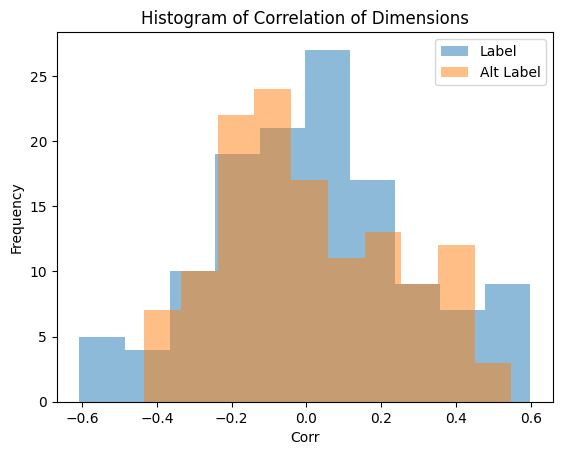

Max Corr Label 0.5988681562903855 , Max Corr Alt Label 0.5482244454480574

Top 10 Corr Label [0.59886816 0.55941821 0.55115218 0.54402599 0.5433952  0.52871933
 0.52069526 0.51768924 0.48808707 0.46045053] 
Top 10 Corr Alt Label [0.54822445 0.47418461 0.46007081 0.43732092 0.42496988 0.41557385
 0.40782031 0.40142805 0.39683998 0.39470528]


In [141]:
corr_label_dims = [scipy.stats.pearsonr(labels_train.squeeze(), interm_train.detach()[:, i]).statistic for i in range(interm_train.shape[1])]
corr_alt_label_dims = [scipy.stats.pearsonr(alt_labels_train.squeeze(), interm_train.detach()[:, i]).statistic for i in range(interm_train.shape[1])]

plt.hist(corr_label_dims, alpha=0.5, label='List 1')
plt.hist(corr_alt_label_dims, alpha=0.5, label='List 2')
plt.title('Histogram of Correlation of Dimensions')
plt.xlabel('Corr')
plt.ylabel('Frequency')
plt.legend(['Label', 'Alt Label'])

plt.show()

print('Max Corr Label', max(corr_label_dims), ', Max Corr Alt Label', max(corr_alt_label_dims))
print('\nTop 10 Corr Label', torch.topk(torch.tensor(corr_label_dims), 10).values.numpy(), '\nTop 10 Corr Alt Label', torch.topk(torch.tensor(corr_alt_label_dims), 10).values.numpy())

Have some higher frequency of correlation, which is important/shows some difference potentially

In [143]:
train_size = int(0.8 * len(interm_train))

train_dataset = TensorDataset(interm_train.detach(), labels_train.view(-1, 1))
val_dataset = TensorDataset(interm_val.detach(), labels_val.view(-1, 1))

train_dataset_alt = TensorDataset(interm_train.detach(), alt_labels_train.view(-1, 1))
val_dataset_alt = TensorDataset(interm_val.detach(), alt_labels_val.view(-1, 1))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_dataloader_alt = DataLoader(train_dataset_alt, batch_size=32, shuffle=True)
val_dataloader_alt = DataLoader(val_dataset_alt, batch_size=32, shuffle=False)

probe_labels = Probe(interm_train.shape[1]).to(device)
probe_alt_labels = Probe(interm_train.shape[1]).to(device)

In [146]:
trainer = Trainer(max_epochs=epochs)
trainer.fit(probe_labels, train_dataloader, val_dataloader)
trainer.validate(probe_labels, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | body | Linear | 128   
--------------------------------
128       Trainable params
0         Non-trainable params
128       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9664999842643738     │
│      val_loss_epoch       │    0.05521305650472641    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.05521305650472641, 'val_acc_epoch': 0.9664999842643738}]

In [147]:
trainer = Trainer(max_epochs=1)
trainer.fit(probe_alt_labels, train_dataloader_alt, val_dataloader_alt)
trainer.validate(probe_alt_labels, val_dataloader_alt)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | body | Linear | 128   
--------------------------------
128       Trainable params
0         Non-trainable params
128       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9564999938011169     │
│      val_loss_epoch       │    0.0874154269695282     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.0874154269695282, 'val_acc_epoch': 0.9564999938011169}]

## TRANSPLANTATION

In [ ]:
PYTHIA_VOCAB_SIZE = 50277 #50304
N_LAYERS=12
MODEL = "EleutherAI/pythia-160m"
PYTHIA_CHECKPOINTS_OLD = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512] + list(range(1000, 143000 + 1, 10000)) + [143000]
PYTHIA_CHECKPOINTS = [512] + list(range(1000, 10000 + 1, 1000))

HeadName = Literal["previous_token_head", "duplicate_token_head", "induction_head"]
HEAD_NAMES = cast(List[HeadName], get_args(HeadName))

In [ ]:
def create_repeats_dataset(num_samples=50, min_vector_size=5, max_vector_size=50, min_num_repeats=5, max_num_repeats=20, max_vocab=PYTHIA_VOCAB_SIZE):
  """Creates a dataset for the experiment."""
  dataset = []
  for _ in range(num_samples):
    vector_size = torch.randint(min_vector_size, max_vector_size, (1,)).item()
    num_repeats = torch.randint(min_num_repeats, max_num_repeats, (1,)).item()
    tokens = torch.randint(0, max_vocab, (1, vector_size))
    tokens = tokens.repeat((1, num_repeats))
    dataset.append(tokens)
  return dataset

In [ ]:
dataset = torch.load('../outputs/aheads/dataset.pt')

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def copy_attention_head(model1, model2, layer_idx, head_idx, dataset):
  if model1.isinstance(HookedTransformer) and model2.isinstance(HookedTransformer):
    model1.W_K.data[layer_idx, head_idx, :, :] = model2.W_K.data[layer_idx, head_idx, :, :]
    model1.W_Q.data[layer_idx, head_idx, :, :] = model2.W_Q.data[layer_idx, head_idx, :, :]
    model1.W_V.data[layer_idx, head_idx, :, :] = model2.W_V.data[layer_idx, head_idx, :, :]
    model1.b_K.data[layer_idx, head_idx, :] = model2.b_K.data[layer_idx, head_idx, :]
    model1.b_Q.data[layer_idx, head_idx, :] = model2.b_Q.data[layer_idx, head_idx, :]
    model1.b_V.data[layer_idx, head_idx, :] = model2.b_V.data[layer_idx, head_idx, :]
  else:
    model1.encoder.layers[layer_idx].dset_gen_attn.in_proj_weight.data[head_idx,:,:] = model2.encoder.layers[layer_idx].dset_gen_attn.in_proj_weight.data[head_idx,:,:]
  return perplexity(model1, dataset), perplexity(model2, dataset)


In [13]:
def calculate_perplexity(corpus, model, device="cpu"):
    encoded_input = model.to_tokens(corpus)
    encoded_input = encoded_input.to(device)
    with torch.no_grad():
      outputs = model(encoded_input).squeeze(0)
      loss = F.cross_entropy(outputs, encoded_input.squeeze(0), reduction='sum')/encoded_input.shape[1]
    perplexity = torch.exp(loss).item()
    return perplexity

In [15]:
def perplexity(model, dataset):
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
  with torch.no_grad():
    for batch in data_loader:
      inputs, targets = batch
      outputs = model(inputs)
      loss = F.cross_entropy(outputs, targets, reduction='sum')
      total_loss += loss.item()
    average_loss = total_loss / len(data_loader.dataset)
    return torch.exp(torch.tensor(average_loss))

# Attn Head Figure Gen

In [224]:
import pandas as pd
import seaborn as sns

In [242]:
home = os.environ['LEARNING_DYNAMICS_HOME']

In [290]:
def make_line_graph(folder_path, layer, task, output_file):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    nrows = len(csv_files) // 3 + (len(csv_files) % 3 > 0)
    ncols = 3
    
    plt.figure(figsize=(10, 6))

    outputs = []
    for i, file in enumerate(csv_files):
        df = pd.read_csv(os.path.join(folder_path, file), delimiter='\t').drop('Layer', axis=1)
        df = df[['20', '40', '60', '80', '100', '200', '1000', '1400', '1600',
       '1800', '2000']]
        df.index = df.index[::-1]
        if 'head' in file:
            head = file.split('head_')[-1].split('.csv')[0]
            outputs.append((head, df.loc[layer].tolist()))  
            plt.plot(df.columns,  df.loc[layer].tolist(), label=f'Head {head}')
            
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.title(f'{task} - Attention Layer {layer}')
    plt.xlabel('Timestep')
    plt.ylabel('Accuracy')
    legend = plt.legend(title='Legend', title_fontsize='13', fontsize='10', loc='best')

    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(1.5)
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()
    return outputs, df.columns

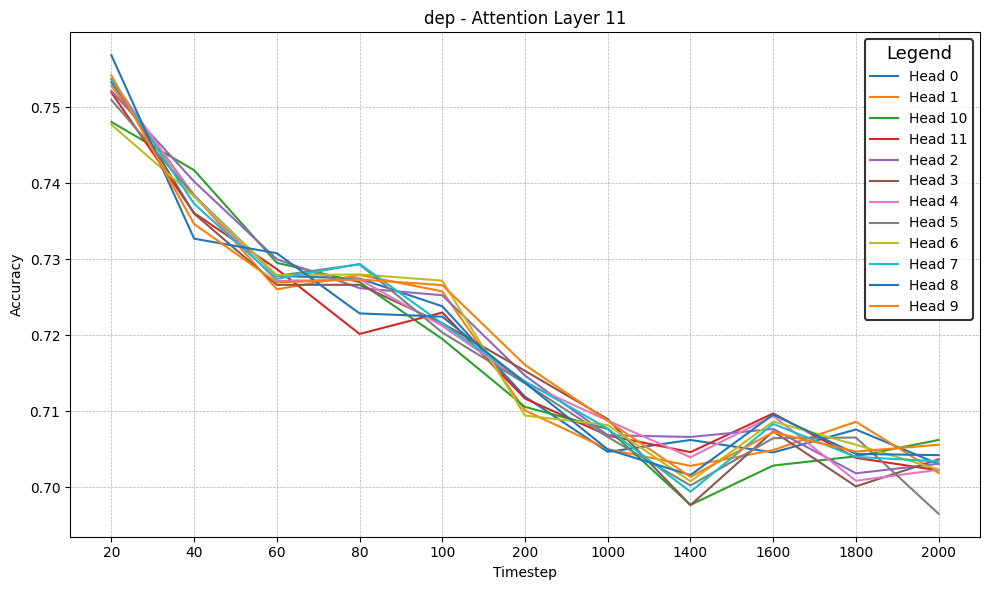

In [291]:

_ = make_line_graph(os.path.join(home, 'outputs/en_ewt-ud/dep/components'), 11, 'dep', os.path.join(home, 'figures/dep_11_heads.png'))

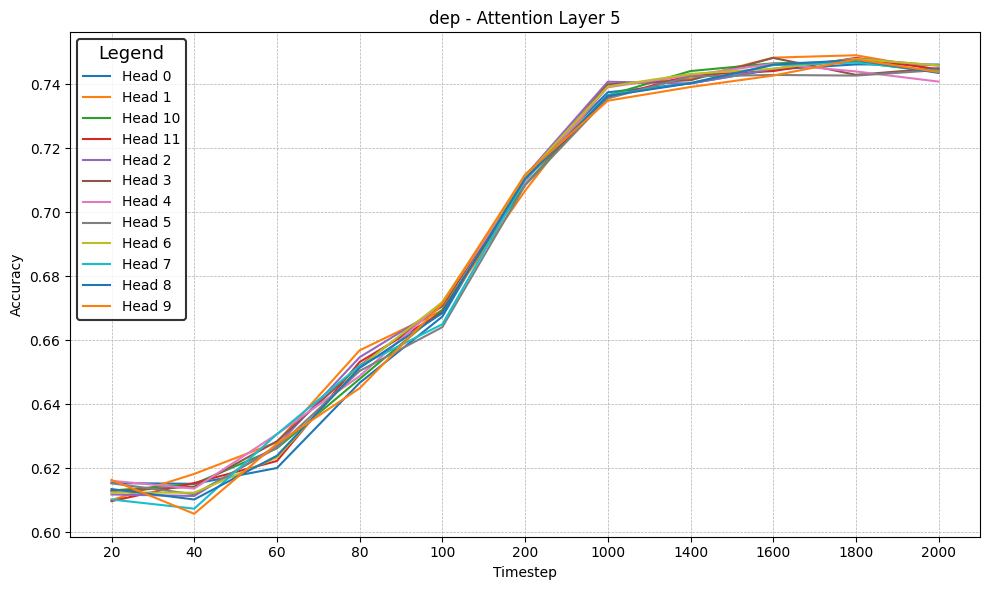

In [292]:
_ = make_line_graph(os.path.join(home, 'outputs/en_ewt-ud/dep/components'), 5, 'dep', os.path.join(home, 'figures/dep_5_heads.png'))

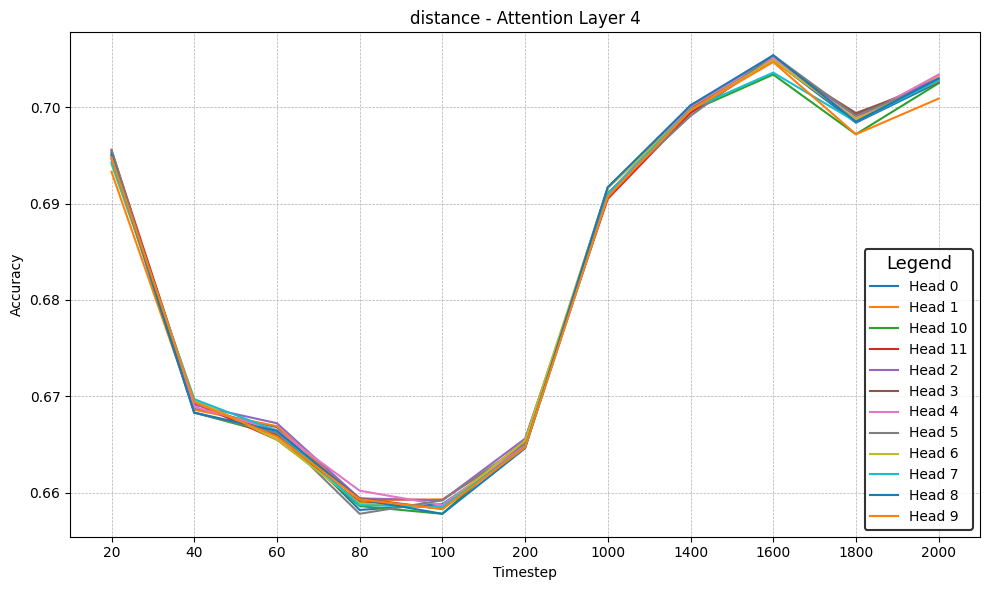

In [310]:
_ = make_line_graph(os.path.join(home, 'outputs/ptb_3/distance/components/DSpr'), 4, 'distance', os.path.join(home, 'figures/head_examples/distance_5_heads.png'))